In [9]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt


In [10]:
import io
import sys

dfs = {}

if os.path.exists('stats.txt'):
    os.remove('stats.txt')

with open('stats.txt', 'w') as log_file:
    for file in os.listdir():
        if file.endswith('.csv'):
            df = pd.read_csv(file)
            print(f"Processing {file}...")
            dfs[file] = df

            # Write file name as header
            log_file.write(f"=== Analysis for {file} ===\n\n")
            
            # Write head()
            log_file.write("HEAD (First 5 rows):\n")
            log_file.write(df.head().to_string())
            log_file.write("\n\n")
            
            # Write describe()
            log_file.write("DESCRIBE (Statistical Summary):\n")
            log_file.write(df.describe().to_string())
            log_file.write("\n\n")
            
            # Write info() - capture the output using StringIO
            log_file.write("INFO (Data types and memory usage):\n")
            buffer = io.StringIO()
            df.info(buf=buffer)
            log_file.write(buffer.getvalue())
            log_file.write("\n")
            
            # Write missing values
            log_file.write(f"MISSING VALUES:\n")
            log_file.write(df.isnull().sum().to_string())
            log_file.write("\n\n")

            
            log_file.write("\n\n" + "="*60 + "\n\n")

print(f"Analysis complete! Data from {len(dfs)} files stored in dfs dictionary.")
print("Statistics written to stats.txt")

Processing billing.csv...
Processing users.csv...
Processing events.csv...
Processing sessions.csv...
Analysis complete! Data from 4 files stored in dfs dictionary.
Statistics written to stats.txt


### By analysing the stats.txt, 4935 rows of app_version missing in session.csv, 38224 rows of region missing in users.csv, see if we could retrieve these missing values by matching with user_id or just not important ig.                  

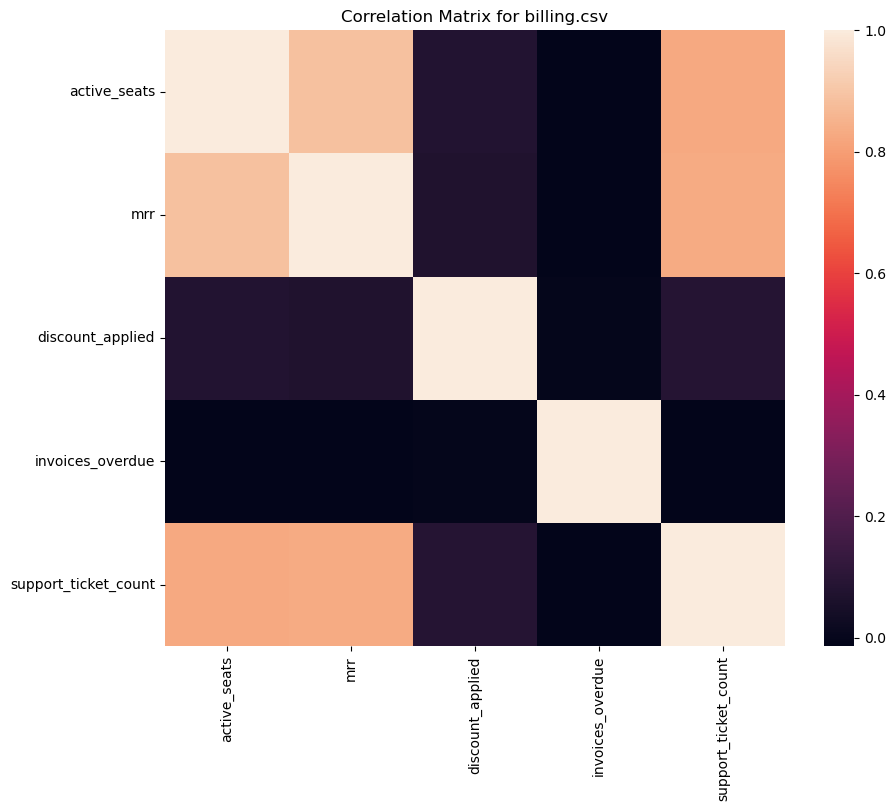

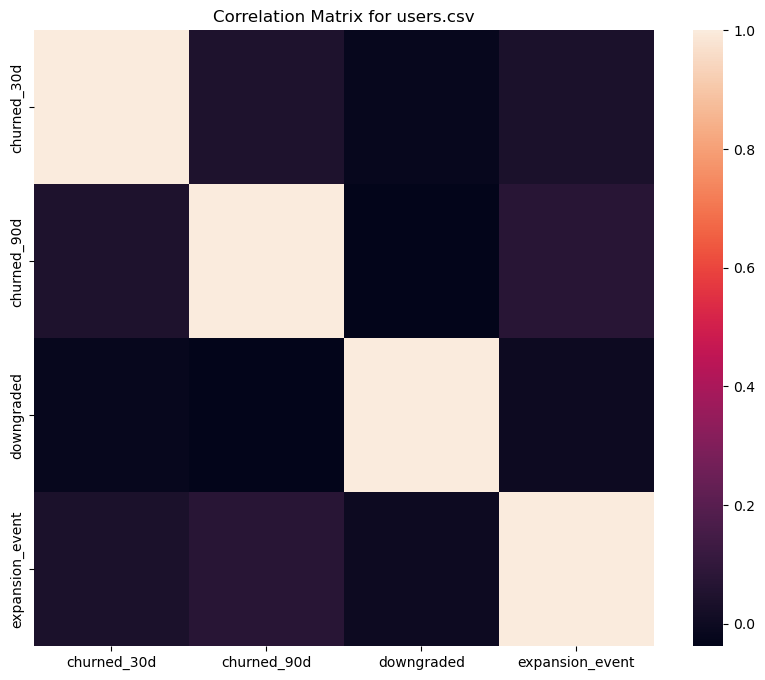

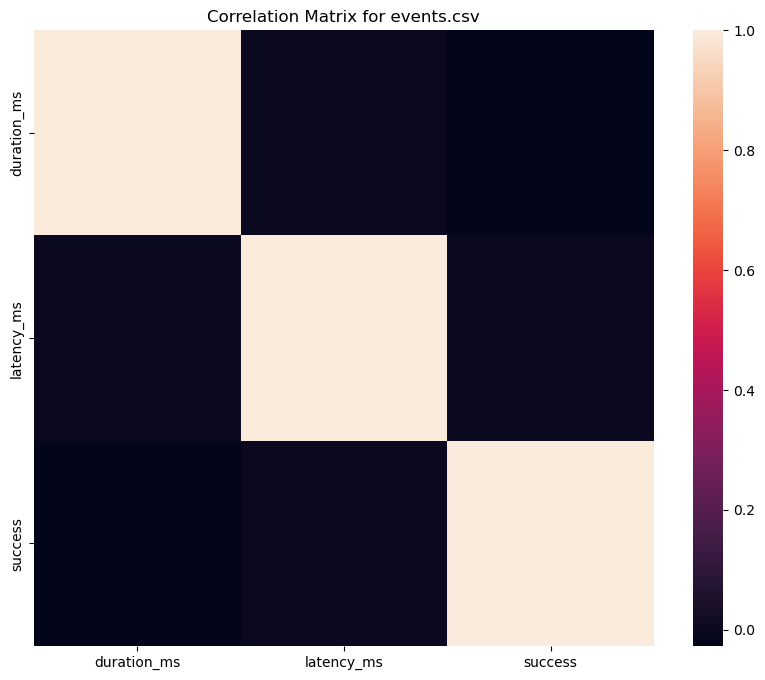

'sessions.csv' has only one numeric column, so no correlation matrix can be generated.


In [4]:
# Generate and display correlation heatmaps for each dataframe

for filename, df in dfs.items():
    # Select only numeric columns for correlation
    numeric_cols = df.select_dtypes(include=['number'])
    
    # Ensure there is more than one numeric column to create a matrix
    if not numeric_cols.empty and len(numeric_cols.columns) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric_cols.corr())
        plt.title(f'Correlation Matrix for {filename}')
        plt.show()
    elif not numeric_cols.empty:
        print(f"'{filename}' has only one numeric column, so no correlation matrix can be generated.")
    else:
        print(f"'{filename}' has no numeric columns to plot a correlation matrix.")

### billing.csv: mrr, active _seats, support_ticket_count are correlated (see them as one group).

In [29]:
for filename, df in dfs.items():
    print(f"--- Analysis for {filename} ---")
    
    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    
    # # --- 1. Print Distinct Values of Categorical Columns ---
    # for col in categorical_cols:
    #     # To avoid printing too many unique values, we'll cap it at 20
    #     if df[col].nunique() <= 20:
    #         print(f"\nDistinct values in '{col}':")
    #         print(df[col].unique())
    #     else:
    #         print(f"\n'{col}' has {df[col].nunique()} unique values (too many to display).")

    # # --- 2. Generate Box Plots for Categorical vs. Numerical ---
    # if len(categorical_cols) > 0 and len(numerical_cols) > 0:
    #     print("\n--- Generating Box Plots ---")
    #     for cat_col in categorical_cols:
    #         # Again, cap the number of categories to plot for readability
    #         if df[cat_col].nunique() <= 15:
    #             for num_col in numerical_cols:
    #                 plt.figure(figsize=(12, 6))
    #                 sns.boxplot(data=df, x=cat_col, y=num_col)
    #                 plt.title(f"Distribution of '{num_col}' across '{cat_col}' categories in {filename}")
    #                 plt.xticks(rotation=45)
    #                 plt.show()
    #         else:
    #             print(f"Skipping box plots for '{cat_col}' due to too many unique values.")
    
    print("-"*(len(filename) + 20))

--- Analysis for billing.csv ---
-------------------------------
--- Analysis for users.csv ---
-----------------------------
--- Analysis for events.csv ---
------------------------------
--- Analysis for sessions.csv ---
--------------------------------


In [6]:
# Import SQL libraries for practicing SQL skills
import sqlite3
import pandas as pd

# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Load all CSV data into SQL tables
print("Loading CSV data into SQL tables...")
for filename, df in dfs.items():
    # Clean table name (remove .csv extension)
    table_name = filename.replace('.csv', '')
    # Load dataframe into SQL table
    df.to_sql(table_name, conn, index=False, if_exists='replace')
    print(f"✓ Loaded {len(df)} rows into '{table_name}' table")

print("\nSQL database is ready! Available tables:")
# Show available tables
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql_query(tables_query, conn)
print(tables_df)

Loading CSV data into SQL tables...
✓ Loaded 1000176 rows into 'billing' table
✓ Loaded 100000 rows into 'users' table
✓ Loaded 1000176 rows into 'billing' table
✓ Loaded 100000 rows into 'users' table
✓ Loaded 234329 rows into 'events' table
✓ Loaded 234329 rows into 'events' table
✓ Loaded 336717 rows into 'sessions' table

SQL database is ready! Available tables:
       name
0   billing
1     users
2    events
3  sessions
✓ Loaded 336717 rows into 'sessions' table

SQL database is ready! Available tables:
       name
0   billing
1     users
2    events
3  sessions


In [19]:
users = dfs['users.csv'].drop_duplicates(subset=['user_id'])

# find the count of churn30, churn90
users['churned_30d'].value_counts(), users['churned_90d'].value_counts()

(churned_30d
 0    87039
 1    12961
 Name: count, dtype: int64,
 churned_90d
 0    77008
 1    22992
 Name: count, dtype: int64)

In [23]:
user_churn_030 = users[users['churned_30d'] == 1]
user_churn_090 = users[users['churned_90d'] == 1]
user_churn_3090 = users[(users['churned_30d'] == 0) & (users['churned_90d'] == 1)]

user_churn_030.groupby('plan_tier').size()

plan_tier
free        9064
premium      891
standard    3006
dtype: int64

Files loaded successfully!
Starting feature engineering...
Merging data sources...
Preprocessing data...
Training the Decision Tree model...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2382642317.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].median())
/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2382642317.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mode()[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 


--- Model Evaluation ---
Accuracy: 0.7701

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.77      1.00      0.87     15402
     Churned       0.00      0.00      0.00      4598

    accuracy                           0.77     20000
   macro avg       0.39      0.50      0.44     20000
weighted avg       0.59      0.77      0.67     20000


Generating and saving the Decision Tree visualization...
Visualization saved as 'decision_tree.png'
Confusion Matrix saved as 'confusion_matrix.png'


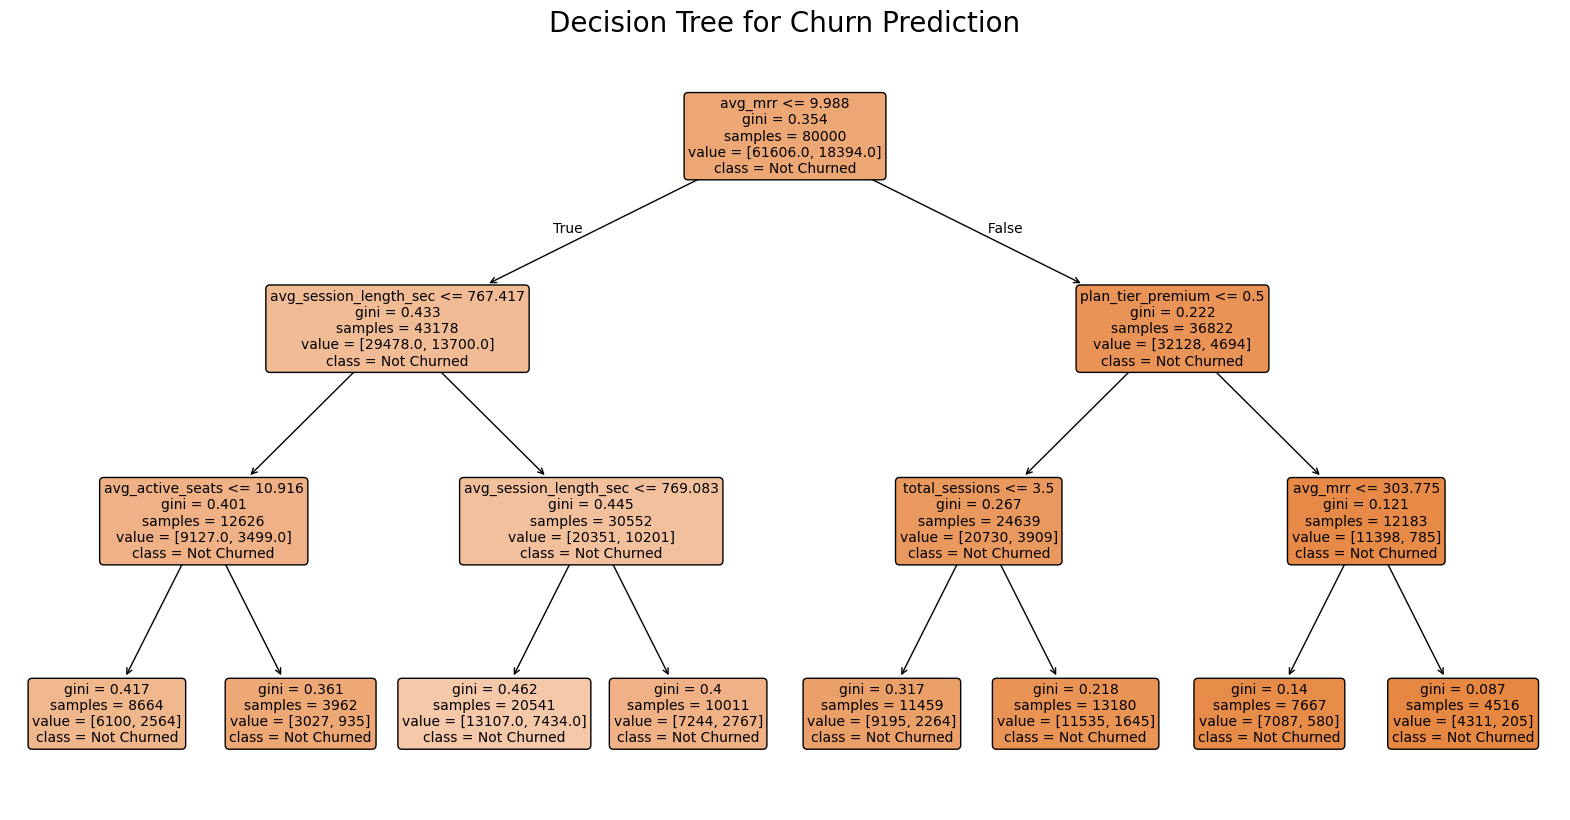

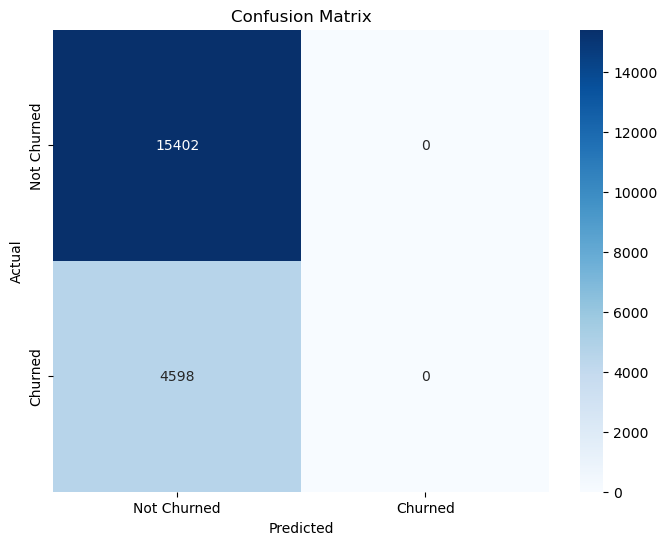

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

# --- 1. Load Data ---

users_df = dfs['users.csv']
billing_df = dfs['billing.csv']
sessions_df = dfs['sessions.csv']   
print("Files loaded successfully!")


# --- 2. Feature Engineering & Data Aggregation ---
# The billing and session data is recorded over time. We need to aggregate it
# to create a single profile for each user.

print("Starting feature engineering...")

# Aggregate billing data: calculate average MRR, total support tickets, etc. for each user.
billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_support_tickets=('support_ticket_count', 'sum'),
    invoices_overdue_count=('invoices_overdue', lambda x: x.sum()),
).reset_index()

# Aggregate session data: calculate average session length and total number of sessions.
sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()

# --- 3. Merge DataFrames ---
# Combine all the data into a single DataFrame based on user_id.
print("Merging data sources...")
# Start with the main users table, ensuring one row per user
model_df = users_df.drop_duplicates(subset='user_id')

# Merge the aggregated data
model_df = pd.merge(model_df, billing_agg, on='user_id', how='left')
model_df = pd.merge(model_df, sessions_agg, on='user_id', how='left')


# --- 4. Data Preprocessing and Cleaning ---
print("Preprocessing data...")

# Define the target variable we want to predict
TARGET_VARIABLE = 'churned_90d'

# Select features for the model. We exclude identifiers, dates, and the other churn column to prevent data leakage.
features_to_use = [
    'plan_tier', 'company_size', 'industry', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_support_tickets', 'invoices_overdue_count',
    'avg_session_length_sec', 'total_sessions'
]

# Separate features (X) and target (y)
X = model_df[features_to_use]
y = model_df[TARGET_VARIABLE]

# Handle Missing Values
# For simplicity, we'll fill missing numerical values with the median and categorical with the mode.
for col in X.select_dtypes(include=['number']).columns:
    X[col] = X[col].fillna(X[col].median())

for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].fillna(X[col].mode()[0])

# Encode Categorical Variables
# Decision trees in scikit-learn require numerical input, so we convert categories into numbers.
X_encoded = pd.get_dummies(X, drop_first=True)

# --- 5. Train the Decision Tree Model ---
print("Training the Decision Tree model...")

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize the Decision Tree Classifier
# We'll set max_depth to 3 to keep the tree simple and prevent overfitting.
# This makes it easier to visualize and understand.
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# --- 6. Evaluate the Model ---
print("\n--- Model Evaluation ---")
# Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))


# --- 7. Visualize the Decision Tree ---
print("\nGenerating and saving the Decision Tree visualization...")
plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=X_encoded.columns,
    class_names=['Not Churned', 'Churned'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Churn Prediction", fontsize=20)
plt.savefig("decision_tree.png")
print("Visualization saved as 'decision_tree.png'")

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
print("Confusion Matrix saved as 'confusion_matrix.png'")


--- Comparing Retained vs. Churned User Behavior ---

Average behavior by user segment:
            user_segment     avg_mrr  avg_active_seats  total_support_tickets  \
0  Early Churner (0-30d)   46.854381         13.562355               2.027431   
1  Late Churner (31-90d)   71.723018         16.151484               2.459578   
2               Retained  221.356475         28.101559               5.476963   

   avg_session_length_sec  total_sessions  
0              837.469539        2.603665  
1              840.006224        3.076742  
2              839.376957        5.083332  

Behavioral comparison chart saved as 'user_segment_comparison.png'


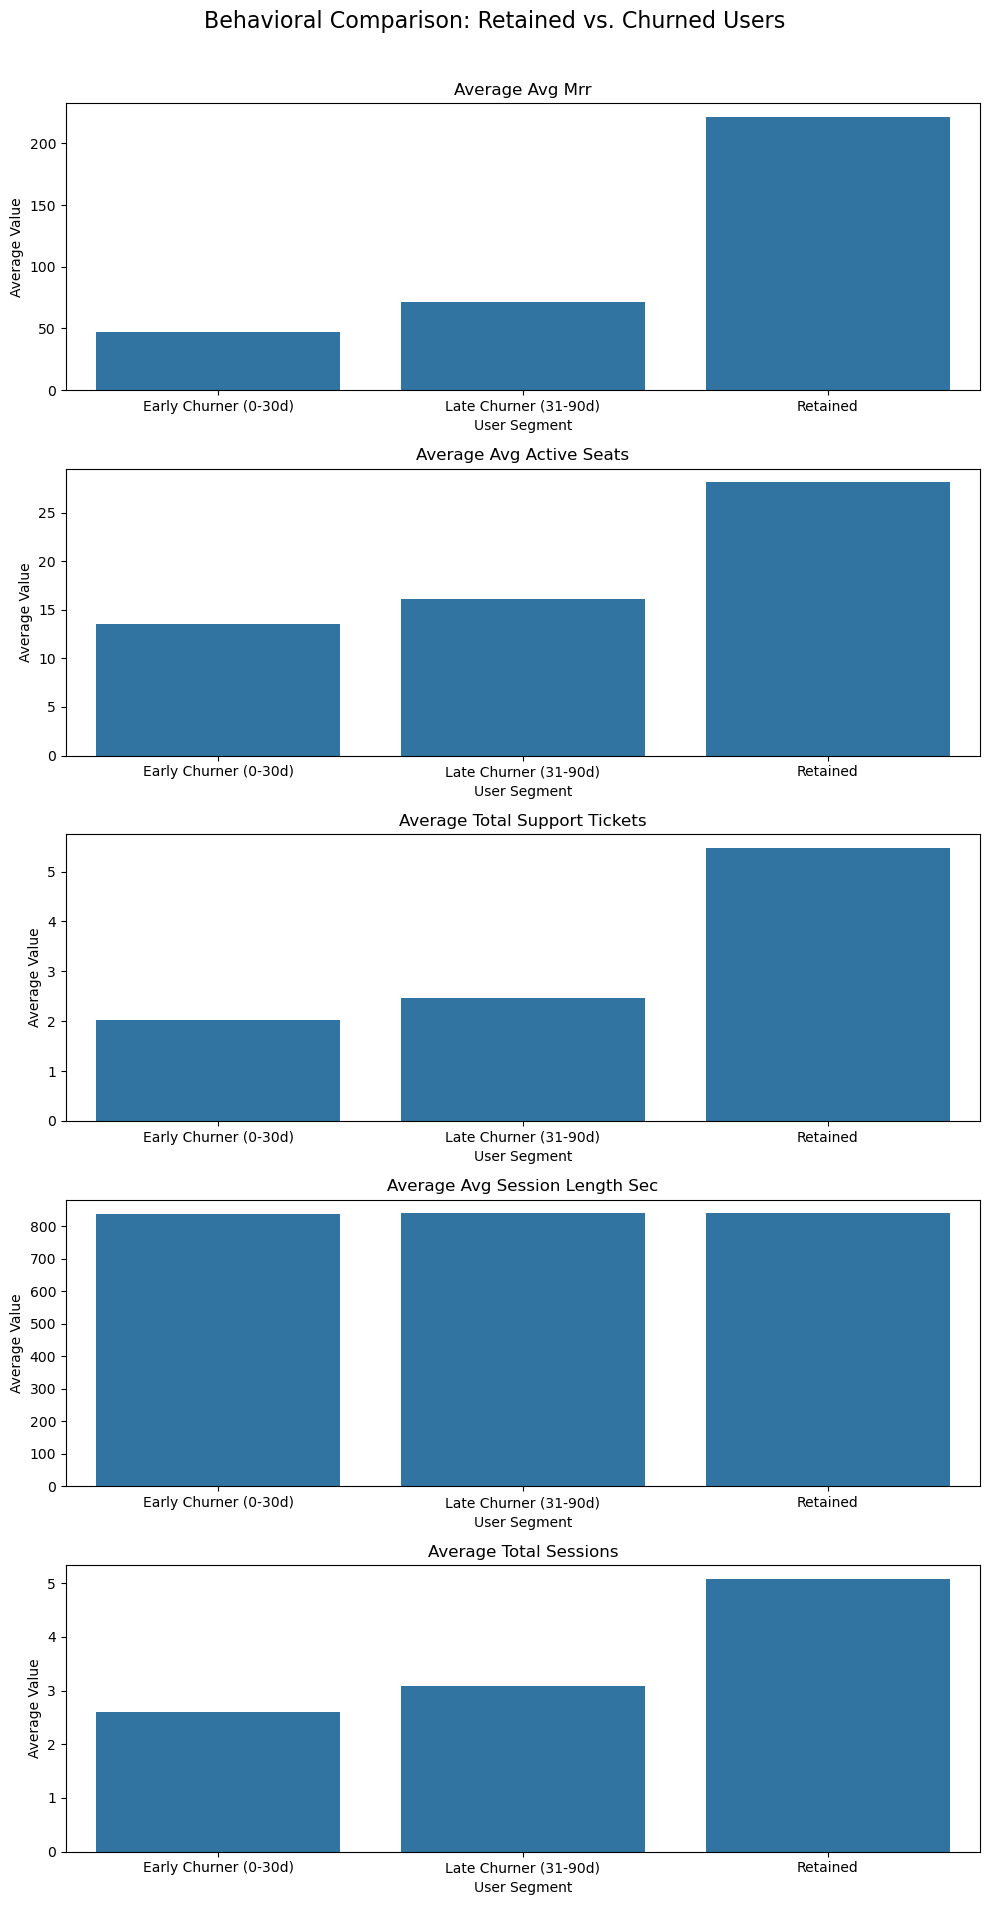

In [26]:
print("\n--- Comparing Retained vs. Churned User Behavior ---")

# Step 1: Create User Segments
def assign_segment(row):
    if row['churned_90d'] == 0:
        return 'Retained'
    elif row['churned_30d'] == 1:
        return 'Early Churner (0-30d)'
    else:
        return 'Late Churner (31-90d)'

model_df['user_segment'] = model_df.apply(assign_segment, axis=1)

# Step 2: Compare Key Metrics Across Segments
comparison_features = [
    'avg_mrr', 'avg_active_seats', 'total_support_tickets',
    'avg_session_length_sec', 'total_sessions'
]

# Group by the new segment and calculate the average for each feature
segment_comparison = model_df.groupby('user_segment')[comparison_features].mean().reset_index()

print("\nAverage behavior by user segment:")
print(segment_comparison)


# Step 3: Visualize the Comparison
# We'll create a bar chart for each feature to make the comparison clear.
fig, axes = plt.subplots(nrows=len(comparison_features), ncols=1, figsize=(10, 20))
fig.suptitle('Behavioral Comparison: Retained vs. Churned Users', fontsize=16)

for i, feature in enumerate(comparison_features):
    sns.barplot(data=segment_comparison, x='user_segment', y=feature, ax=axes[i])
    axes[i].set_title(f'Average {feature.replace("_", " ").title()}')
    axes[i].set_xlabel('User Segment')
    axes[i].set_ylabel('Average Value')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("user_segment_comparison.png")
print("\nBehavioral comparison chart saved as 'user_segment_comparison.png'")


KeyError: 'active_days_30d'

Starting feature engineering...
Merging data sources...
Preprocessing data...
Training the Logistic Regression model...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/1824228474.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].median())
/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/1824228474.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mode()[0])



--- Model Evaluation ---
Accuracy: 0.5735

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.88      0.52      0.65     15402
     Churned       0.32      0.76      0.45      4598

    accuracy                           0.57     20000
   macro avg       0.60      0.64      0.55     20000
weighted avg       0.75      0.57      0.61     20000


Confusion Matrix saved as 'logistic_regression_confusion_matrix.png'


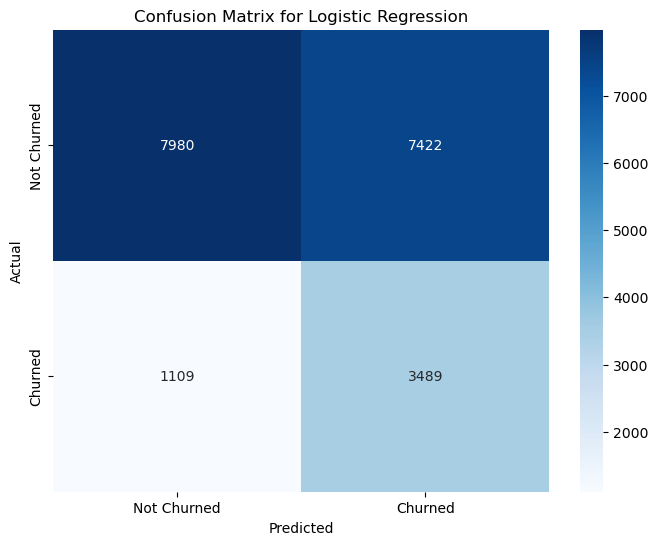

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# --- 2. Feature Engineering & Data Aggregation ---
print("Starting feature engineering...")

# a) Aggregate billing data
billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_support_tickets=('support_ticket_count', 'sum'),
    invoices_overdue_count=('invoices_overdue', lambda x: x.sum()),
).reset_index()

# b) Aggregate session data
sessions_df['session_start_date'] = pd.to_datetime(sessions_df['session_start']).dt.date

# New Feature: Number of active days (unique days with sessions)
user_active_days = sessions_df.groupby('user_id')['session_start_date'].nunique().reset_index()
user_active_days.rename(columns={'session_start_date': 'num_active_days'}, inplace=True)

sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()

# --- 3. Merge DataFrames ---
print("Merging data sources...")
model_df = users_df.drop_duplicates(subset='user_id')
model_df = pd.merge(model_df, billing_agg, on='user_id', how='left')
model_df = pd.merge(model_df, sessions_agg, on='user_id', how='left')
model_df = pd.merge(model_df, user_active_days, on='user_id', how='left') # Merge the new feature


# --- 4. Data Preprocessing and Cleaning ---
print("Preprocessing data...")
TARGET_VARIABLE = 'churned_90d'

# Select features, now including 'num_active_days'
features_to_use = [
    'plan_tier', 'company_size', 'industry', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_support_tickets', 'invoices_overdue_count',
    'avg_session_length_sec', 'total_sessions', 'num_active_days'
]

X = model_df[features_to_use]
y = model_df[TARGET_VARIABLE]

# Handle Missing Values
for col in X.select_dtypes(include=['number']).columns:
    X[col] = X[col].fillna(X[col].median())
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].fillna(X[col].mode()[0])

# Encode Categorical Variables
X_encoded = pd.get_dummies(X, drop_first=True)

# --- 5. Train the Logistic Regression Model ---
print("Training the Logistic Regression model...")
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the model
# We use class_weight='balanced' to handle the imbalanced dataset
log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# --- 6. Evaluate the Model ---
print("\n--- Model Evaluation ---")
y_pred = log_reg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

# --- 7. Visualize the Results ---
# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.savefig("logistic_regression_confusion_matrix.png")
print("\nConfusion Matrix saved as 'logistic_regression_confusion_matrix.png'")

Aggregating data for each user...
Merging data sources...
Preparing data for pairplot...
Using a sample of 2000 users for the plot.
Generating pairplot... this may take a moment.


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2173447923.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = plot_df.groupby('churned_90d').apply(



Pairplot saved as 'churn_analysis_pairplot.png'


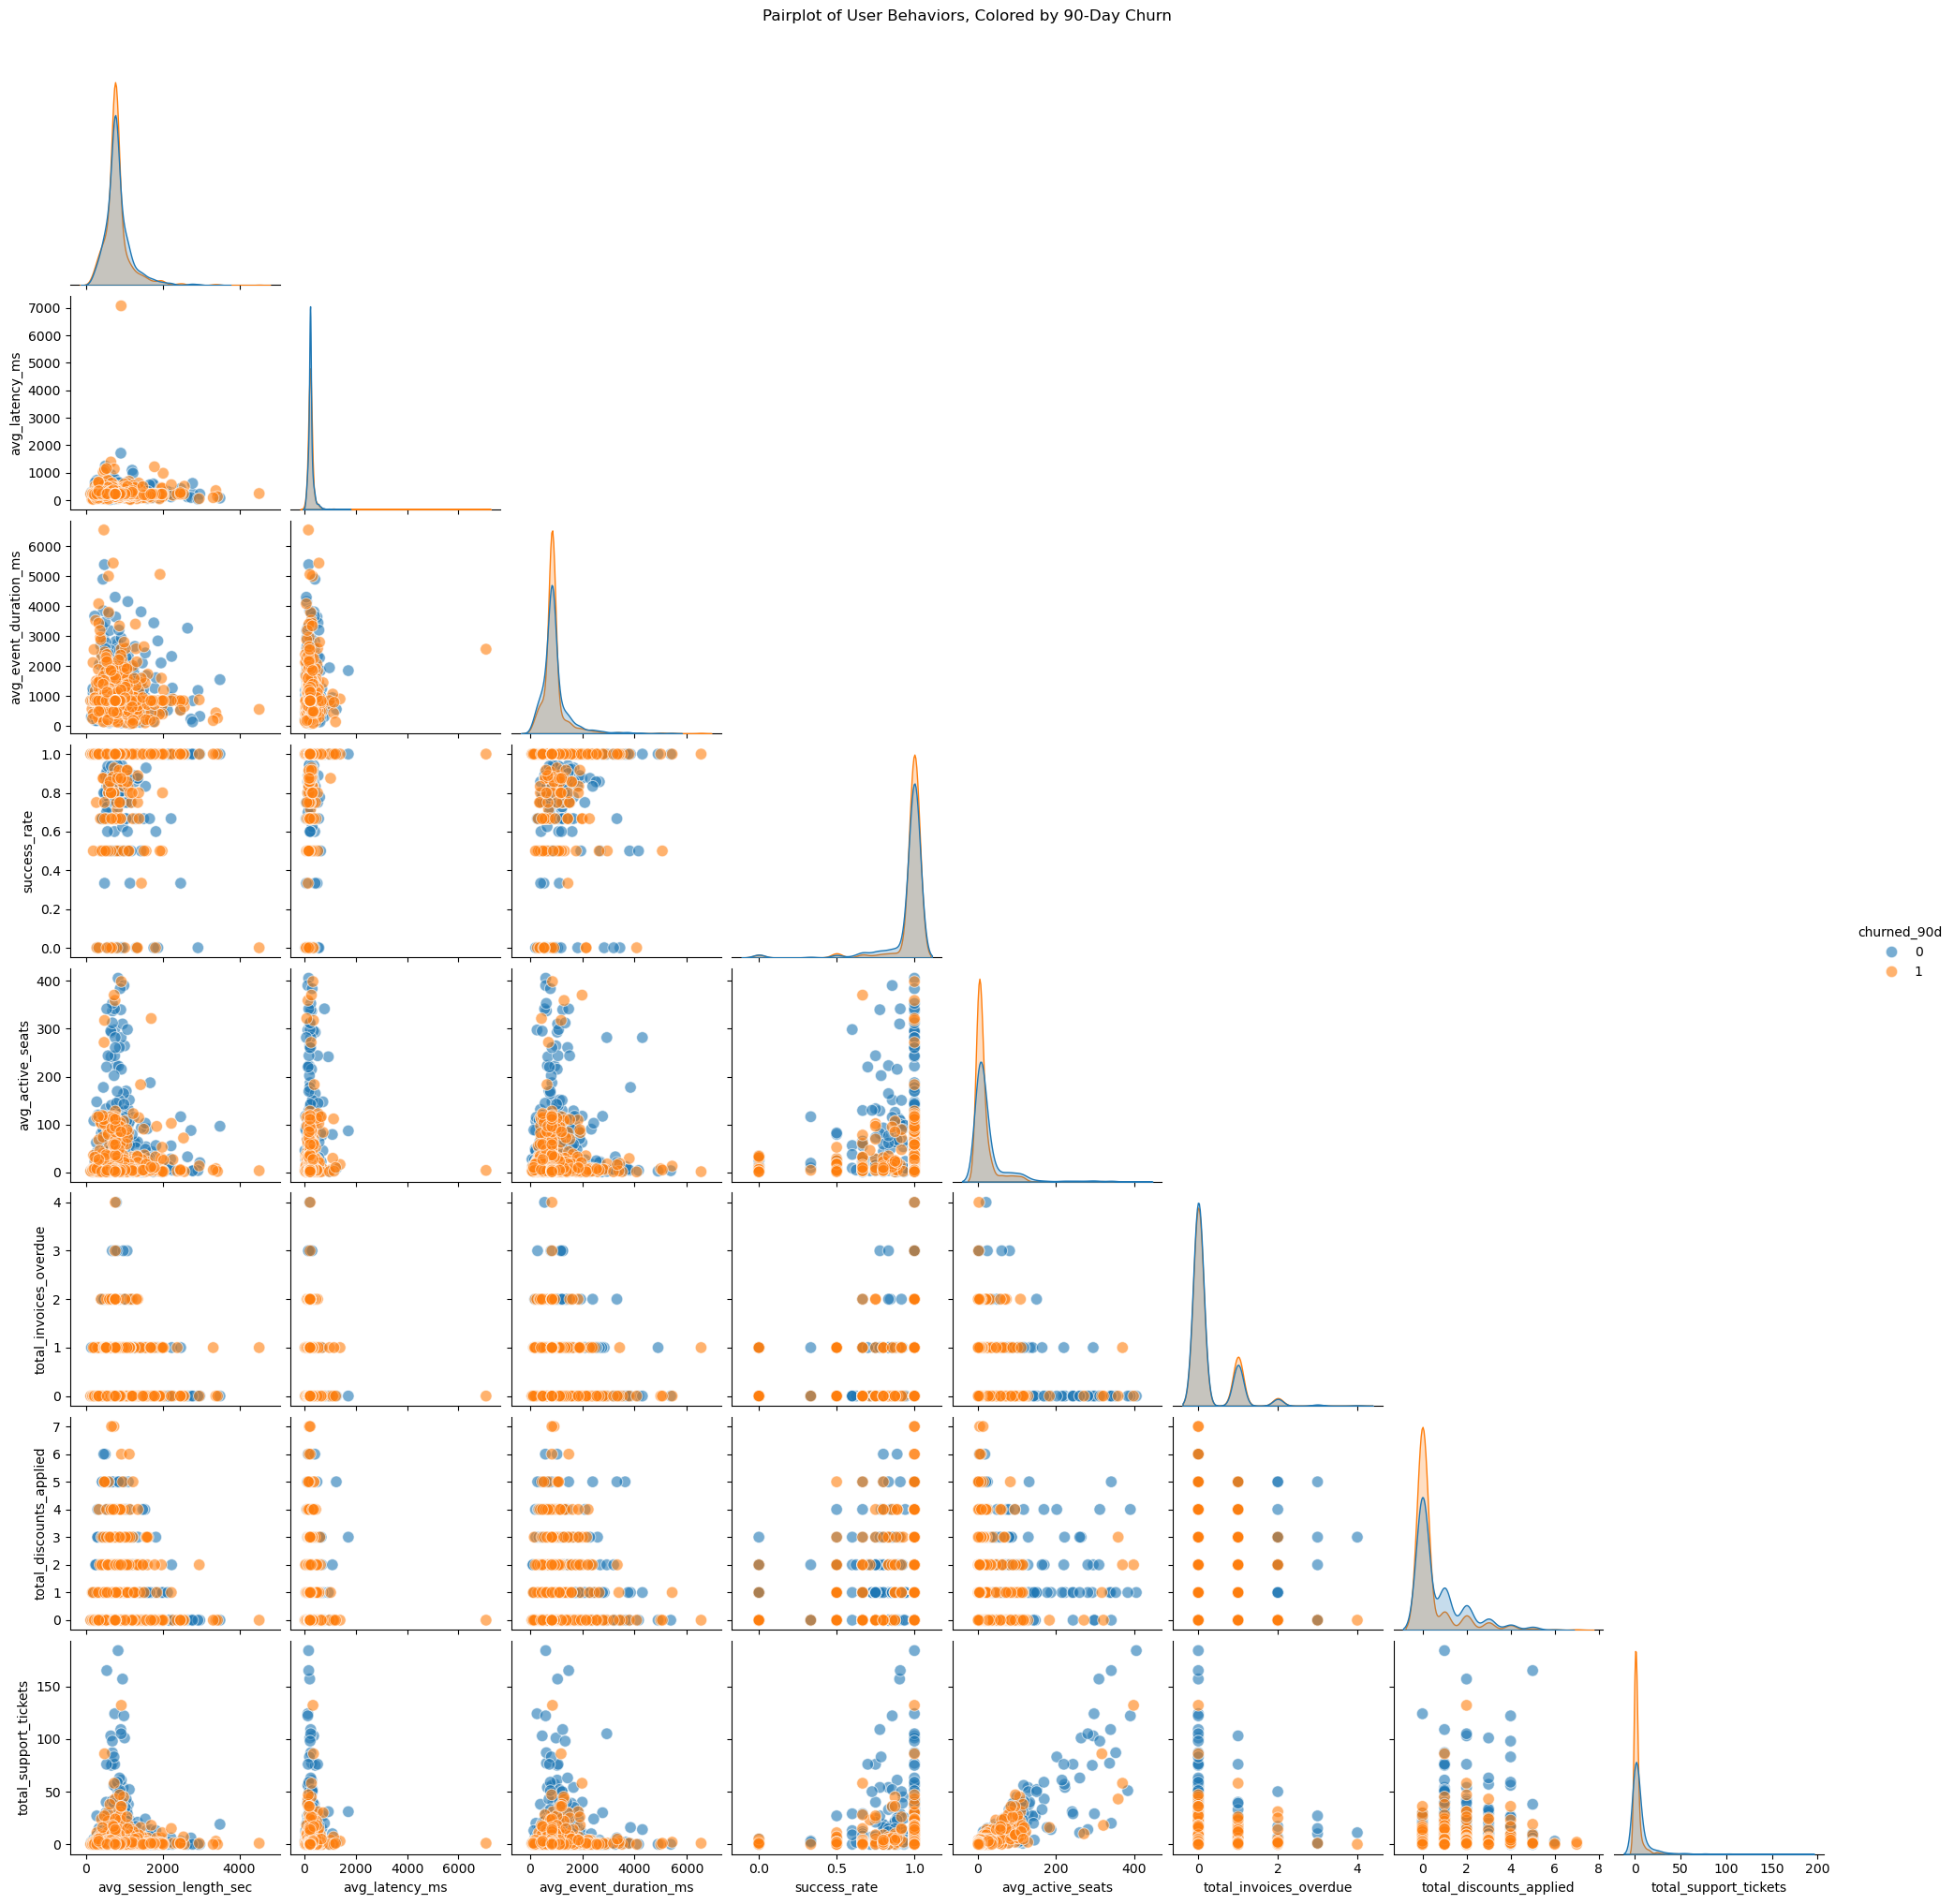

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load All Data ---
users_df = pd.read_csv('users.csv')
billing_df = pd.read_csv('billing.csv')
sessions_df = pd.read_csv('sessions.csv')
events_df = pd.read_csv('events.csv')


# --- 2. Aggregate Data to User Level ---
print("Aggregating data for each user...")

# a) Billing data aggregation
billing_agg = billing_df.groupby('user_id').agg(
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

# b) Session data aggregation
sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()

# c) Event data aggregation
events_agg = events_df.groupby('user_id').agg(
    avg_latency_ms=('latency_ms', 'mean'),
    avg_event_duration_ms=('duration_ms', 'mean'),
    success_rate=('success', lambda x: x.sum() / x.count() if x.count() > 0 else 0)
).reset_index()

# --- 3. Merge All Data into a Single DataFrame ---
print("Merging data sources...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')

# Create the 'upgraded' column from 'expansion_event'
df.rename(columns={'expansion_event': 'upgraded'}, inplace=True)

# --- 4. Prepare Data for Plotting ---
print("Preparing data for pairplot...")

# Select the numerical "sus" variables you wanted to investigate
numerical_vars = [
    'avg_session_length_sec', 'avg_latency_ms', 'avg_event_duration_ms',
    'success_rate', 'avg_active_seats', 'total_invoices_overdue',
    'total_discounts_applied', 'total_support_tickets'
]

# Select the target variables
target_vars = ['churned_30d', 'churned_90d', 'downgraded', 'upgraded']

# Combine the lists and handle potential missing values for plotting
plot_df = df[numerical_vars + target_vars].copy()
plot_df.fillna(plot_df.median(), inplace=True)

# --- 5. Create a Stratified Sample for a Readable Plot ---
# A pairplot on the full dataset would be too slow and dense. We sample the data.
# Stratify by 'churned_90d' ensures we have a representative number of churned/not-churned users.
sample_df = plot_df.groupby('churned_90d').apply(
    lambda x: x.sample(n=min(len(x), 1000), random_state=42)
).reset_index(drop=True)

print(f"Using a sample of {len(sample_df)} users for the plot.")

# --- 6. Generate and Save the Pairplot ---
print("Generating pairplot... this may take a moment.")

# Create the pairplot, colored by our main churn indicator
g = sns.pairplot(
    sample_df,
    vars=numerical_vars, # The variables to show on the axes
    hue='churned_90d',    # Color points by churn status
    diag_kind='kde',      # Show density plots on the diagonal
    plot_kws={'alpha': 0.6, 's': 80}, # Make points slightly transparent
    corner=True           # Only plot the lower triangle to reduce redundancy
)

g.fig.suptitle("Pairplot of User Behaviors, Colored by 90-Day Churn", y=1.02)
plt.savefig("churn_analysis_pairplot.png")

print("\nPairplot saved as 'churn_analysis_pairplot.png'")

Files loaded successfully!
Aggregating data for each user...
Merging data sources...
Preparing data for plotting...
Using a sample of 2000 users for the plots.
Generating boxplots... this may take a few moments.


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/4106307727.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = plot_df.groupby('churned_90d').apply(


Plot saved as 'boxplots_vs_churned_30d.png'
Plot saved as 'boxplots_vs_churned_90d.png'
Plot saved as 'boxplots_vs_downgraded.png'
Plot saved as 'boxplots_vs_upgraded.png'


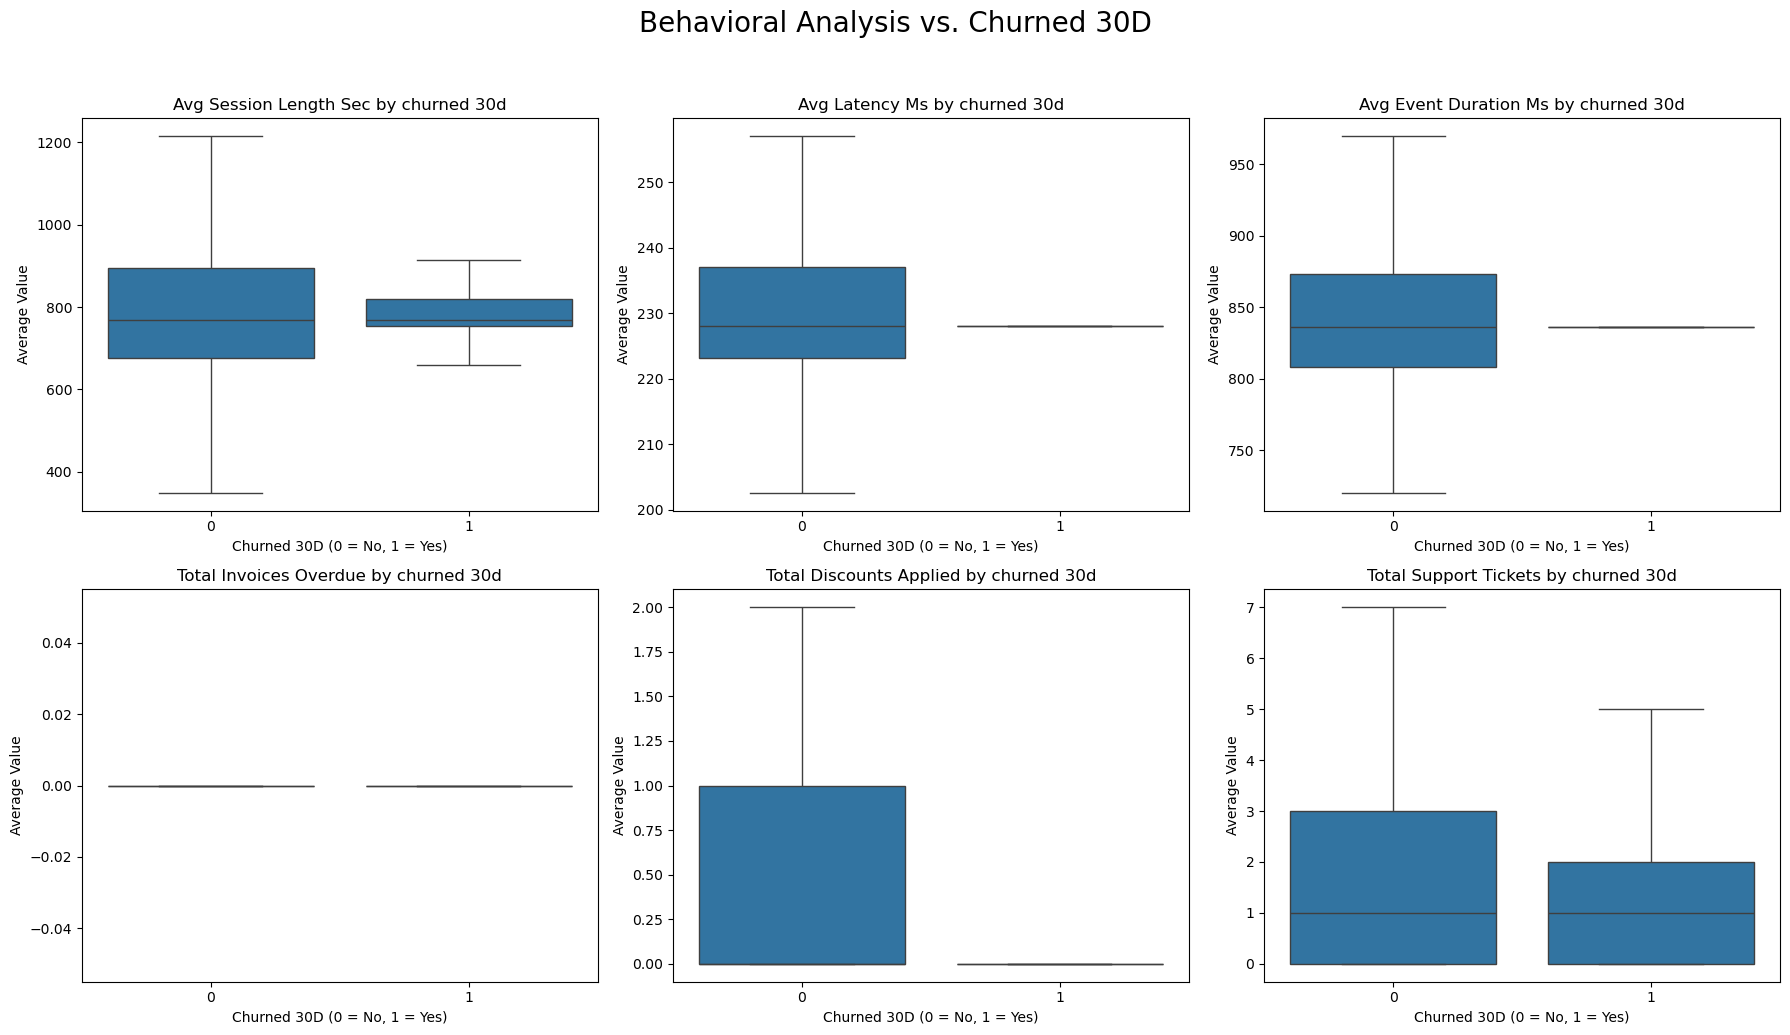

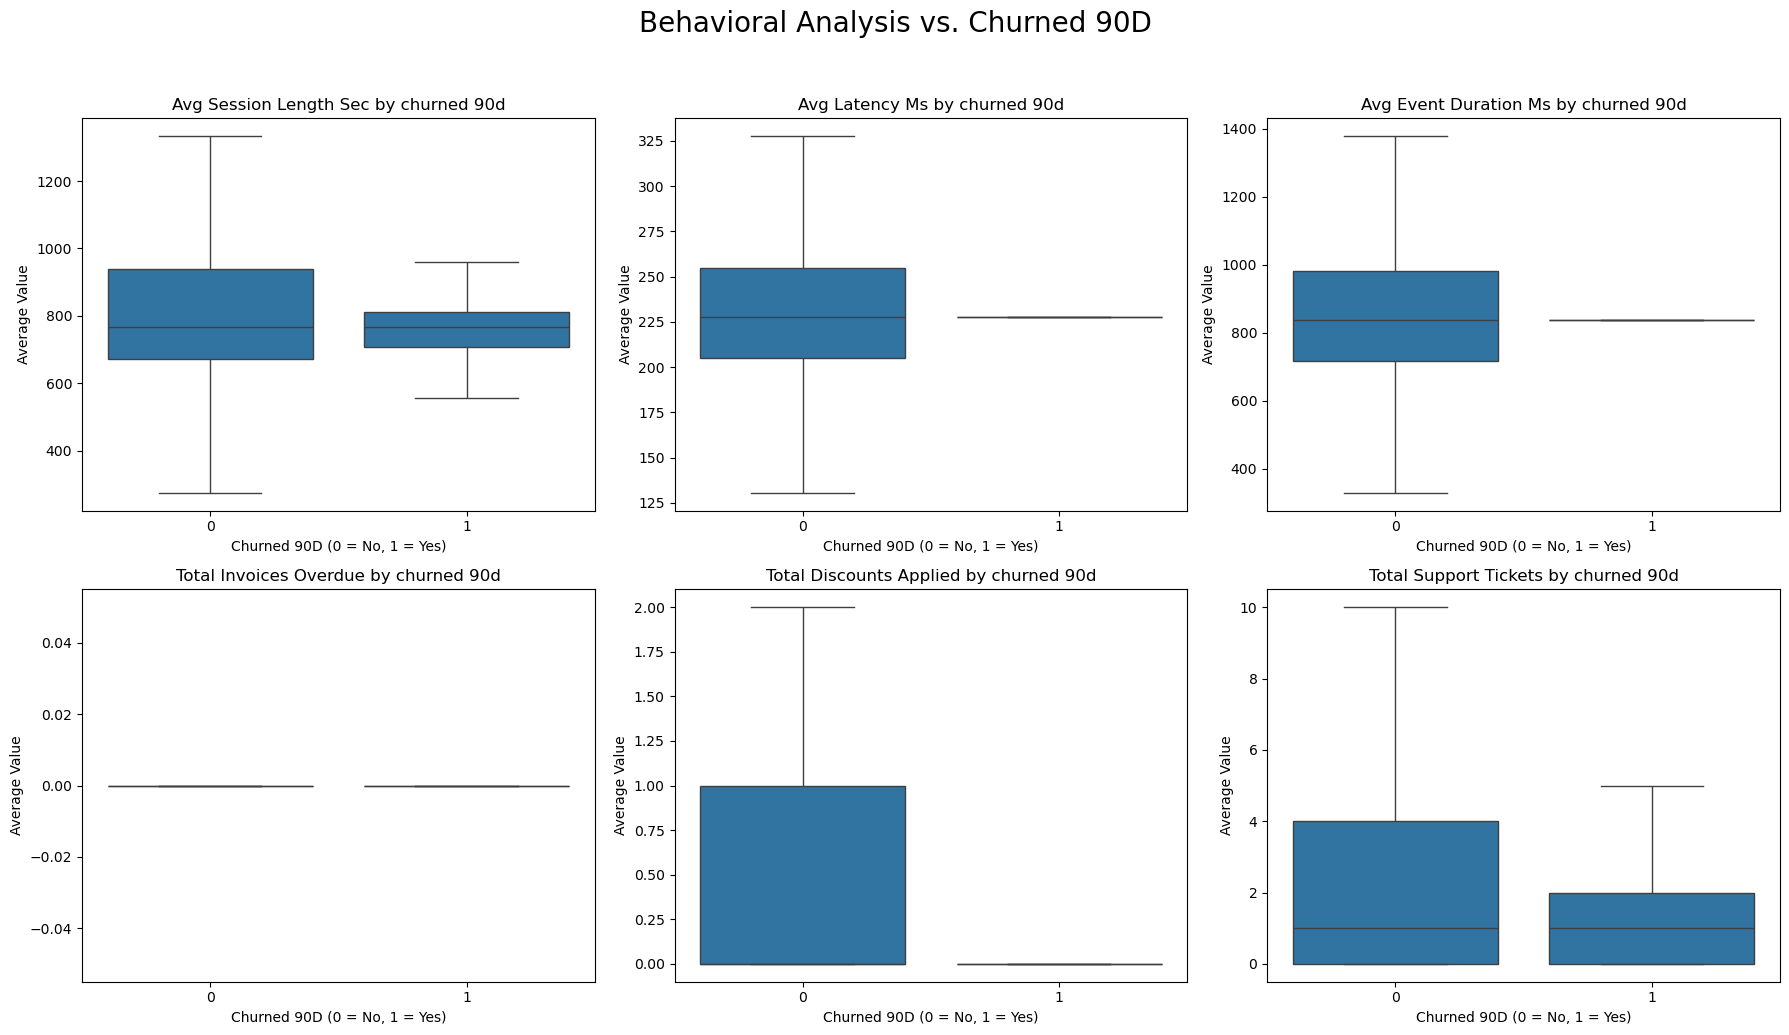

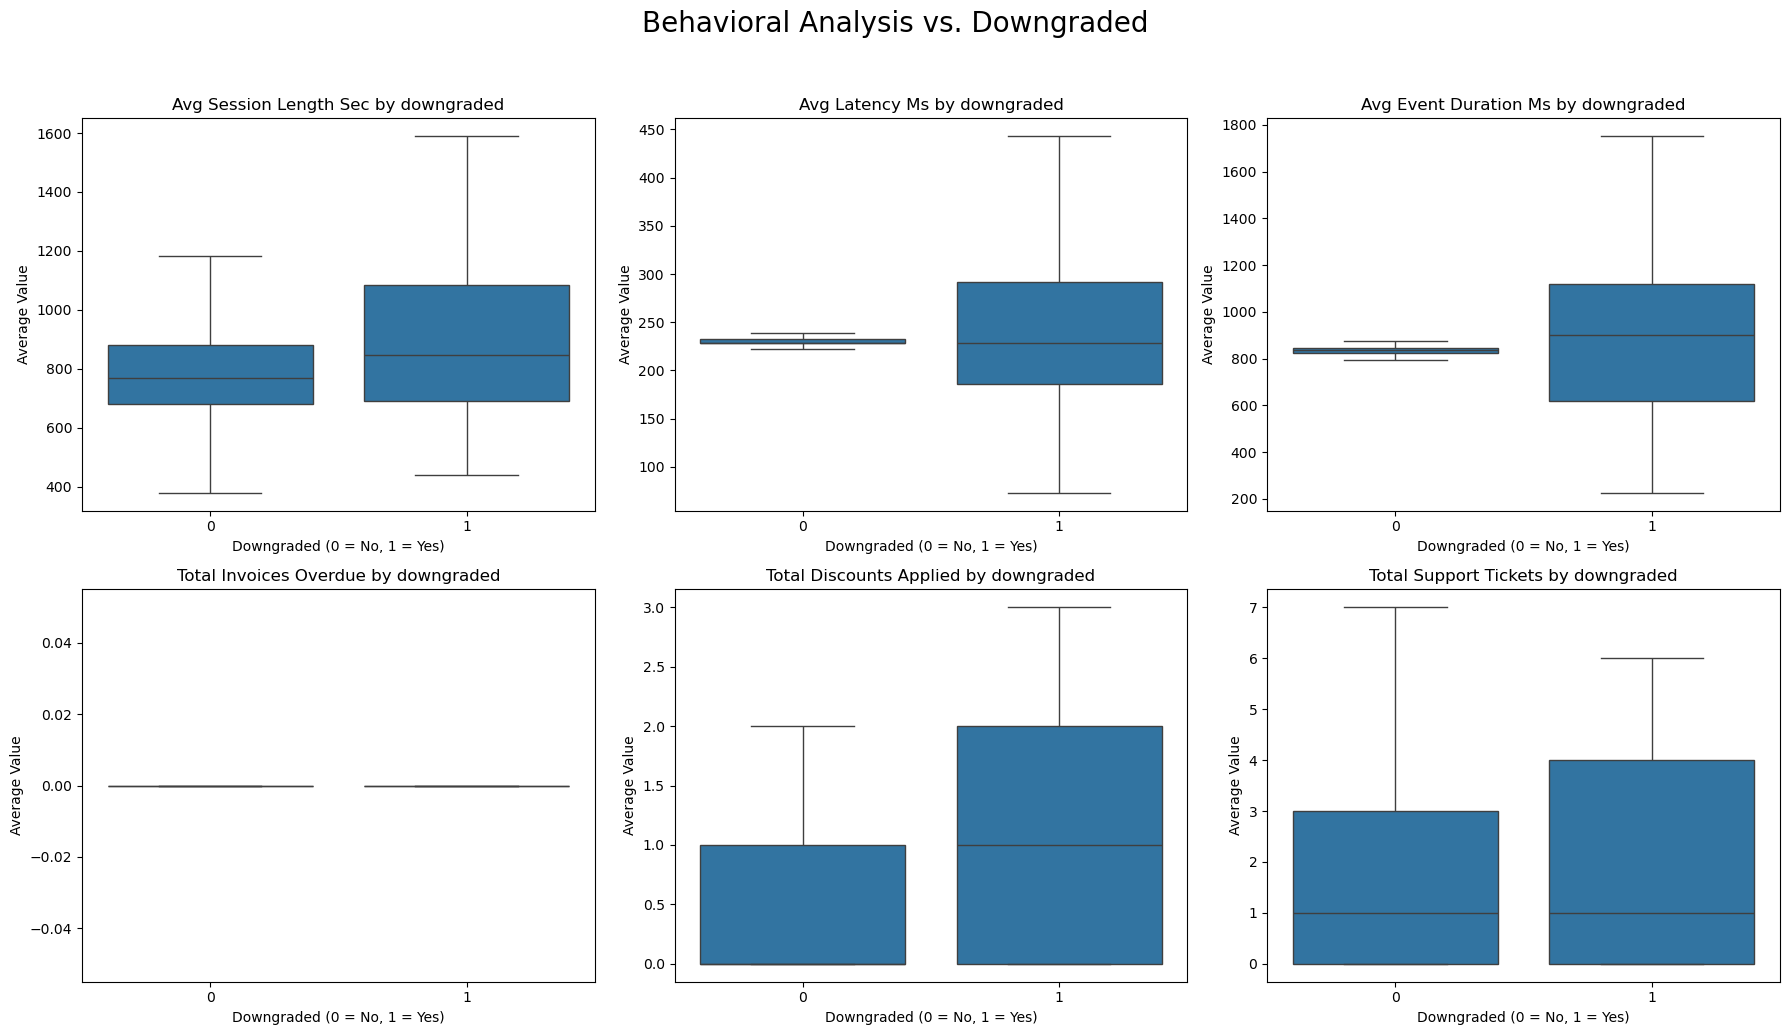

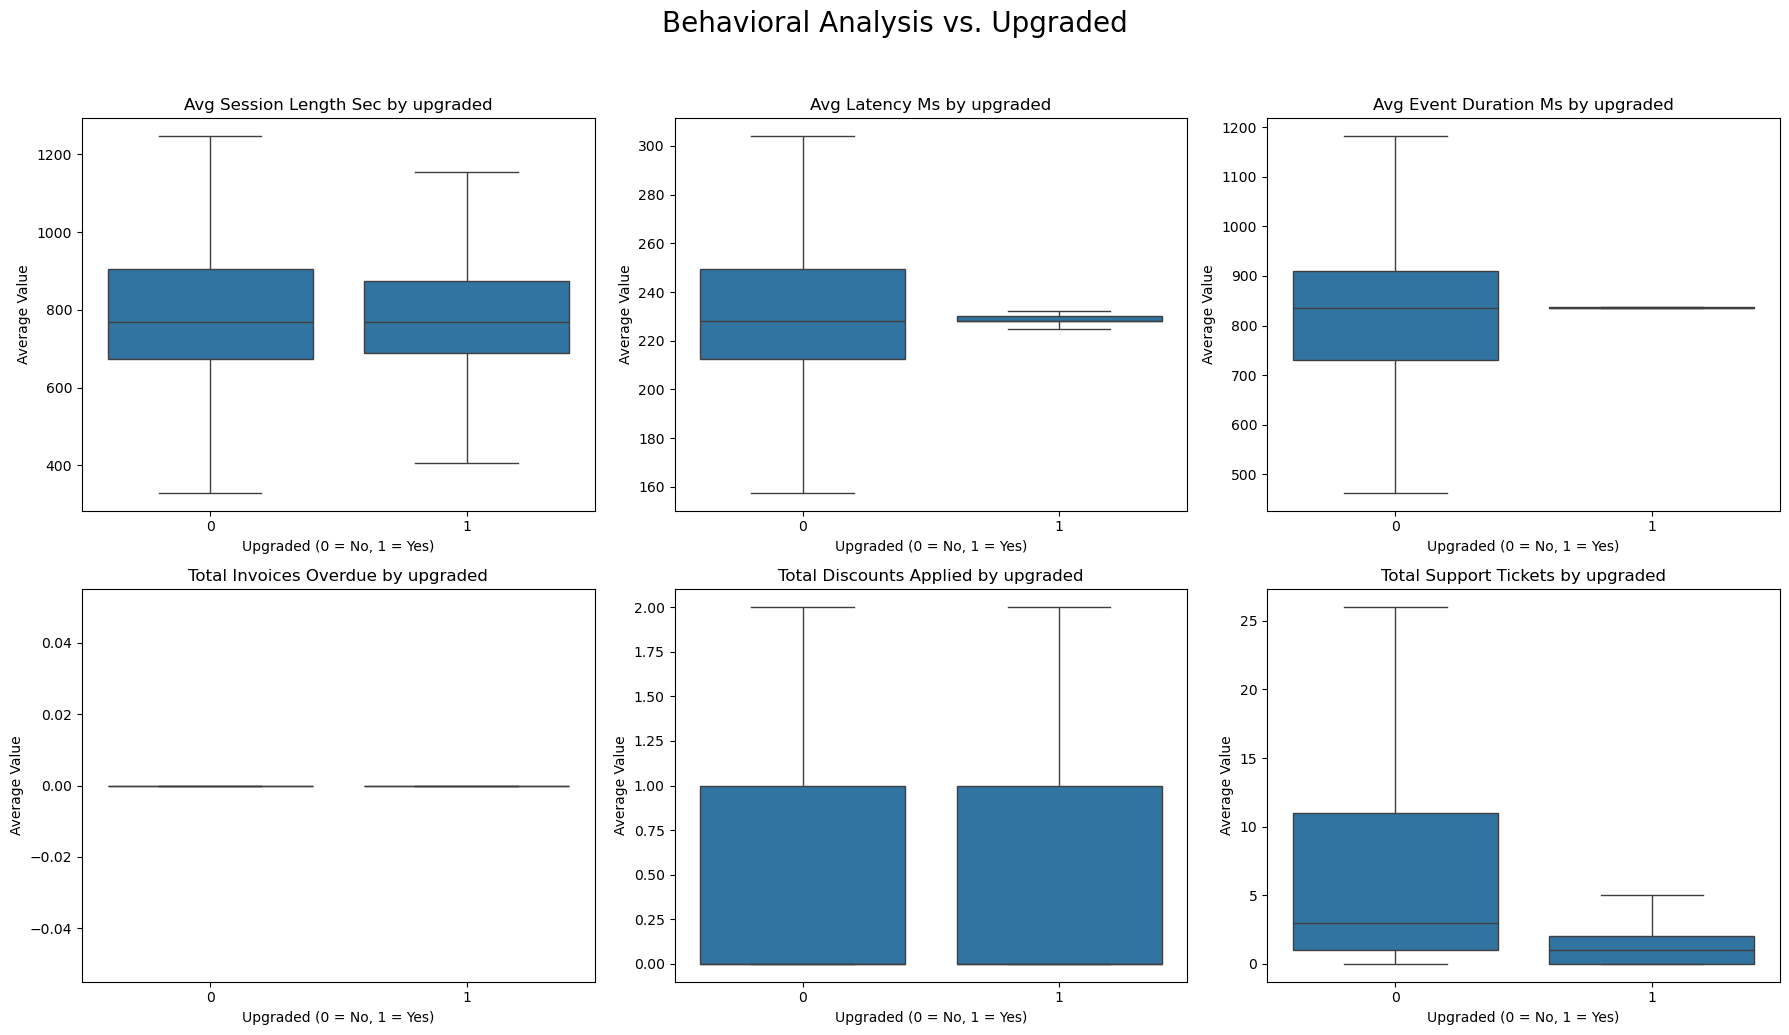

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load All Data ---
try:
    users_df = pd.read_csv('users.csv')
    billing_df = pd.read_csv('billing.csv')
    sessions_df = pd.read_csv('sessions.csv')
    events_df = pd.read_csv('events.csv')
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()


# --- 2. Aggregate Data to User Level ---
print("Aggregating data for each user...")

# a) Billing data aggregation
billing_agg = billing_df.groupby('user_id').agg(
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

# b) Session data aggregation
sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()

# c) Event data aggregation
events_agg = events_df.groupby('user_id').agg(
    avg_latency_ms=('latency_ms', 'mean'),
    avg_event_duration_ms=('duration_ms', 'mean'),
    success_rate=('success', lambda x: x.sum() / x.count() if x.count() > 0 else 0)
).reset_index()

# --- 3. Merge All Data into a Single DataFrame ---
print("Merging data sources...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')

# Create the 'upgraded' column from 'expansion_event'
df.rename(columns={'expansion_event': 'upgraded'}, inplace=True)

# --- 4. Prepare Data for Plotting ---
print("Preparing data for plotting...")

# Updated list of X variables, removing 'avg_active_seats' and 'success_rate'
x_vars = [
    'avg_session_length_sec', 'avg_latency_ms', 'avg_event_duration_ms',
    'total_invoices_overdue', 'total_discounts_applied', 'total_support_tickets'
]

# Your Y variables
y_vars = ['churned_30d', 'churned_90d', 'downgraded', 'upgraded']

# Combine the lists and handle potential missing values
plot_df = df[x_vars + y_vars].copy()
for col in x_vars:
    plot_df[col] = plot_df[col].fillna(plot_df[col].median())

# --- 5. Create a Stratified Sample for Readable Plots ---
sample_df = plot_df.groupby('churned_90d').apply(
    lambda x: x.sample(n=min(len(x), 1000), random_state=42)
).reset_index(drop=True)
print(f"Using a sample of {len(sample_df)} users for the plots.")

# --- 6. Generate and Save a Set of Boxplots for Each Y Variable ---
print("Generating boxplots... this may take a few moments.")

for y_var in y_vars:
    # Create a figure with subplots arranged in 2 rows
    n_cols = 3
    n_rows = (len(x_vars) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    fig.suptitle(f'Behavioral Analysis vs. {y_var.replace("_", " ").title()}', fontsize=20, y=1.03)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, x_var in enumerate(x_vars):
        sns.boxplot(x=y_var, y=x_var, data=sample_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{x_var.replace("_", " ").title()} by {y_var.replace("_", " ")}')
        axes[i].set_xlabel(f'{y_var.replace("_", " ").title()} (0 = No, 1 = Yes)')
        axes[i].set_ylabel('Average Value')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"boxplots_vs_{y_var}.png")
    print(f"Plot saved as 'boxplots_vs_{y_var}.png'")

Aggregating data for each user...
Merging data sources...
Preparing data for plotting...
Using a sample of 2000 users for the plots.
Generating boxplots... this may take a few moments.


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2745171272.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = plot_df.groupby('churned_90d').apply(


Plot saved as 'boxplots_vs_churned_30d.png'
Plot saved as 'boxplots_vs_churned_90d.png'
Plot saved as 'boxplots_vs_downgraded.png'
Plot saved as 'boxplots_vs_upgraded.png'


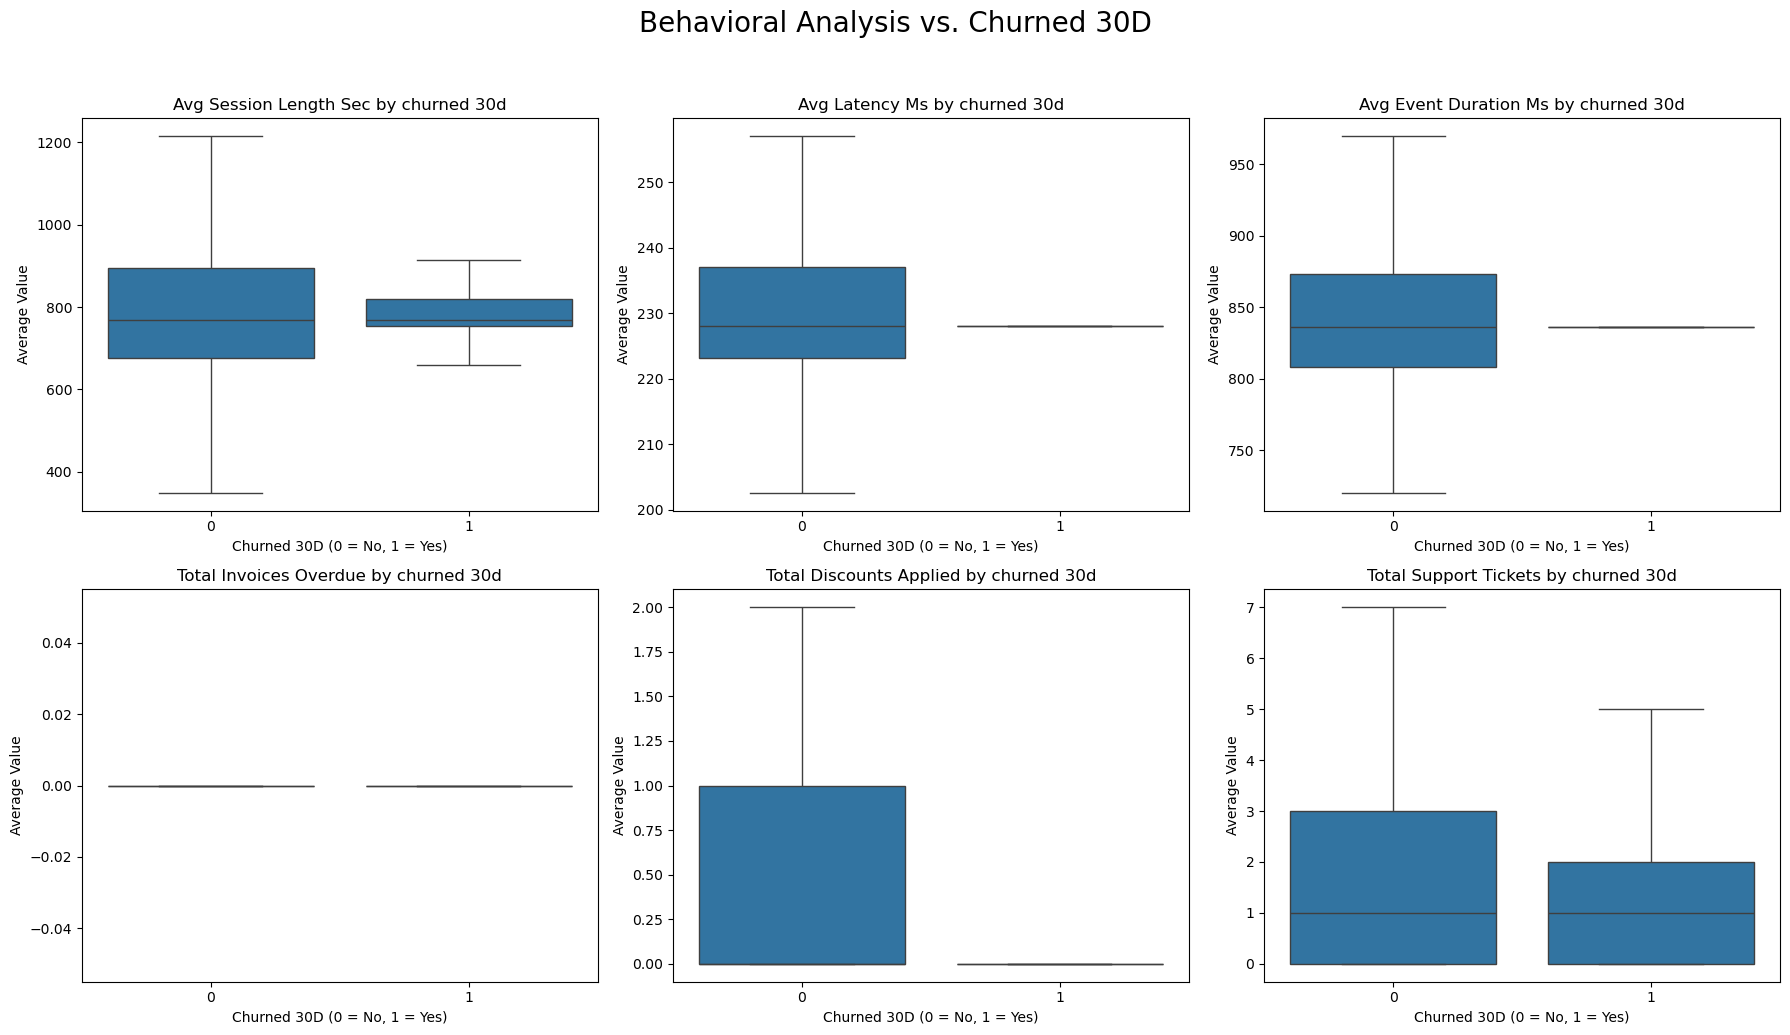

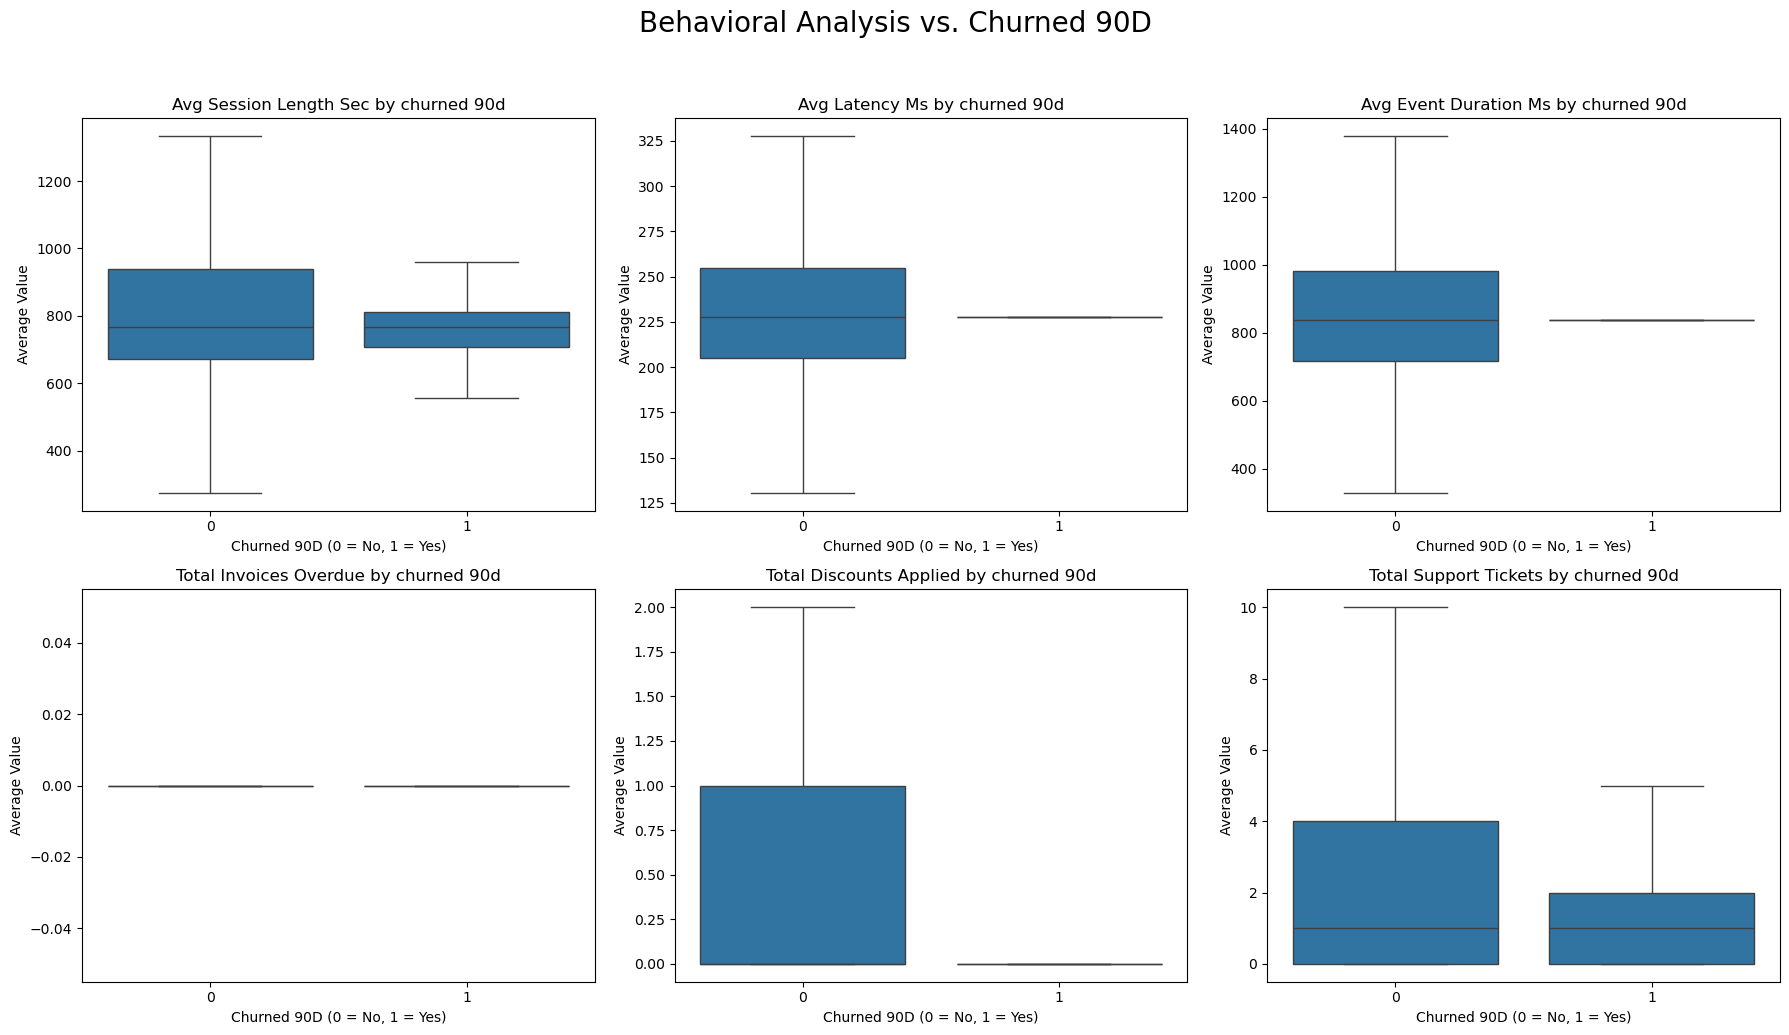

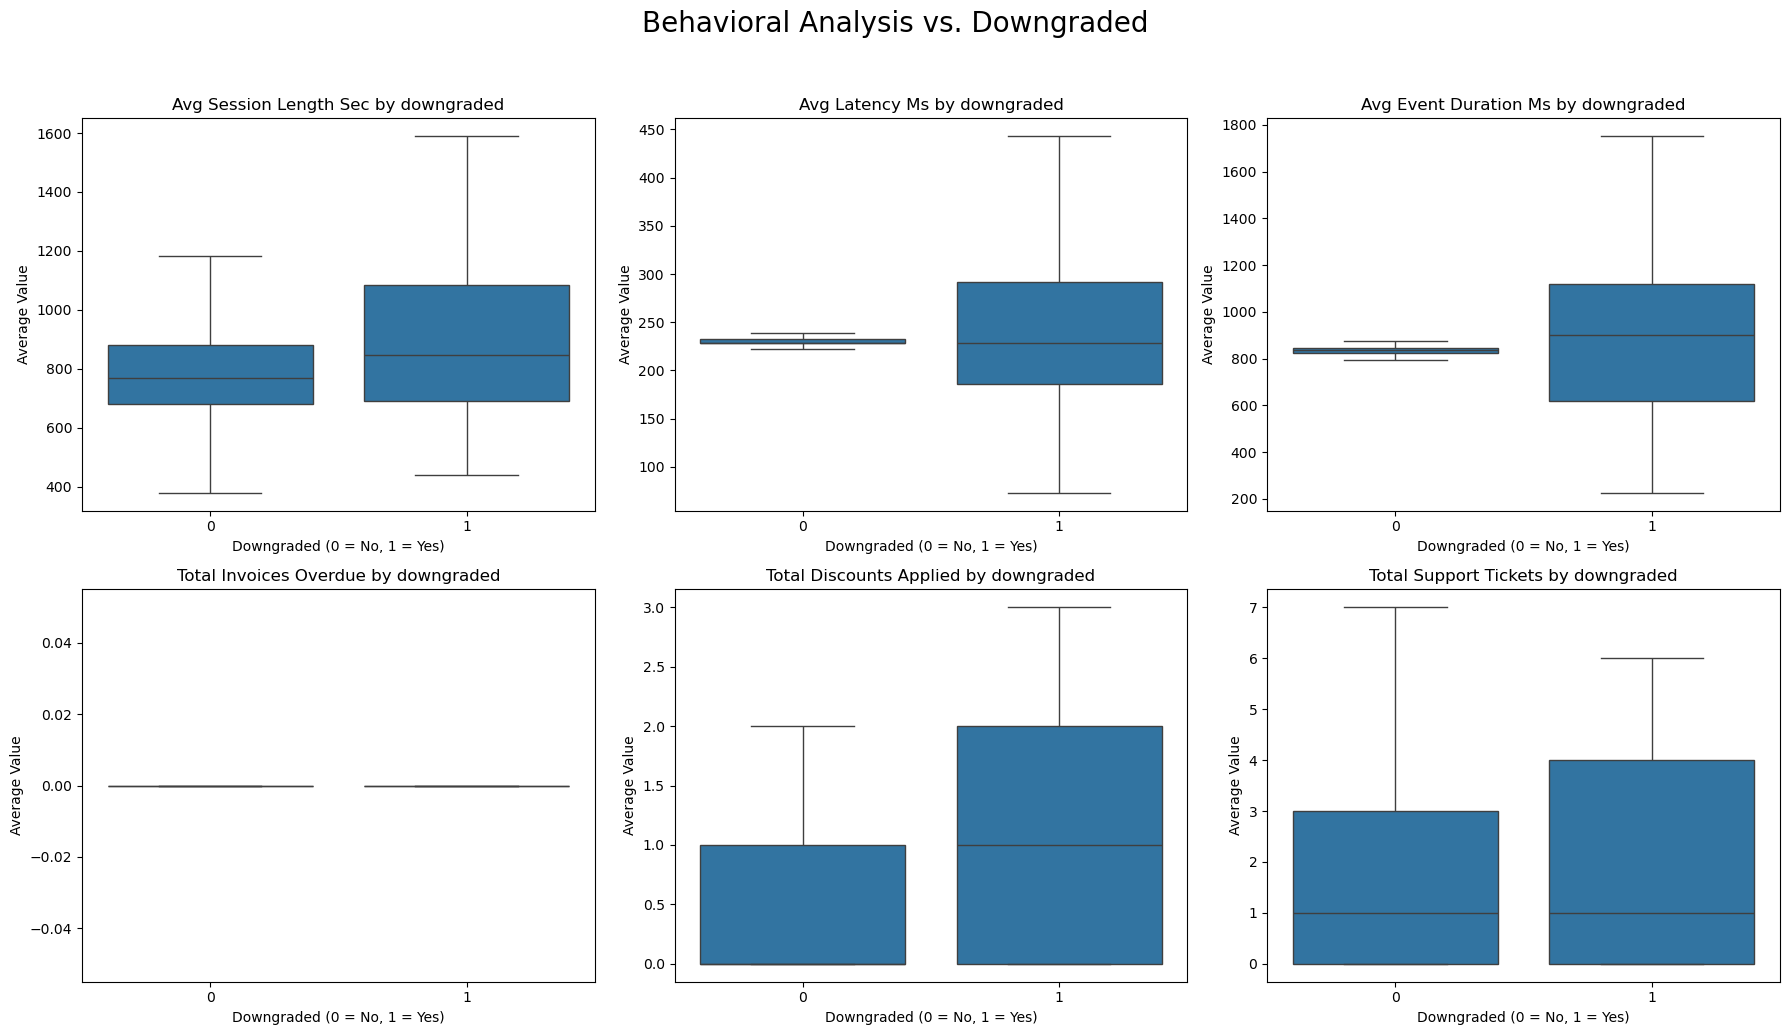

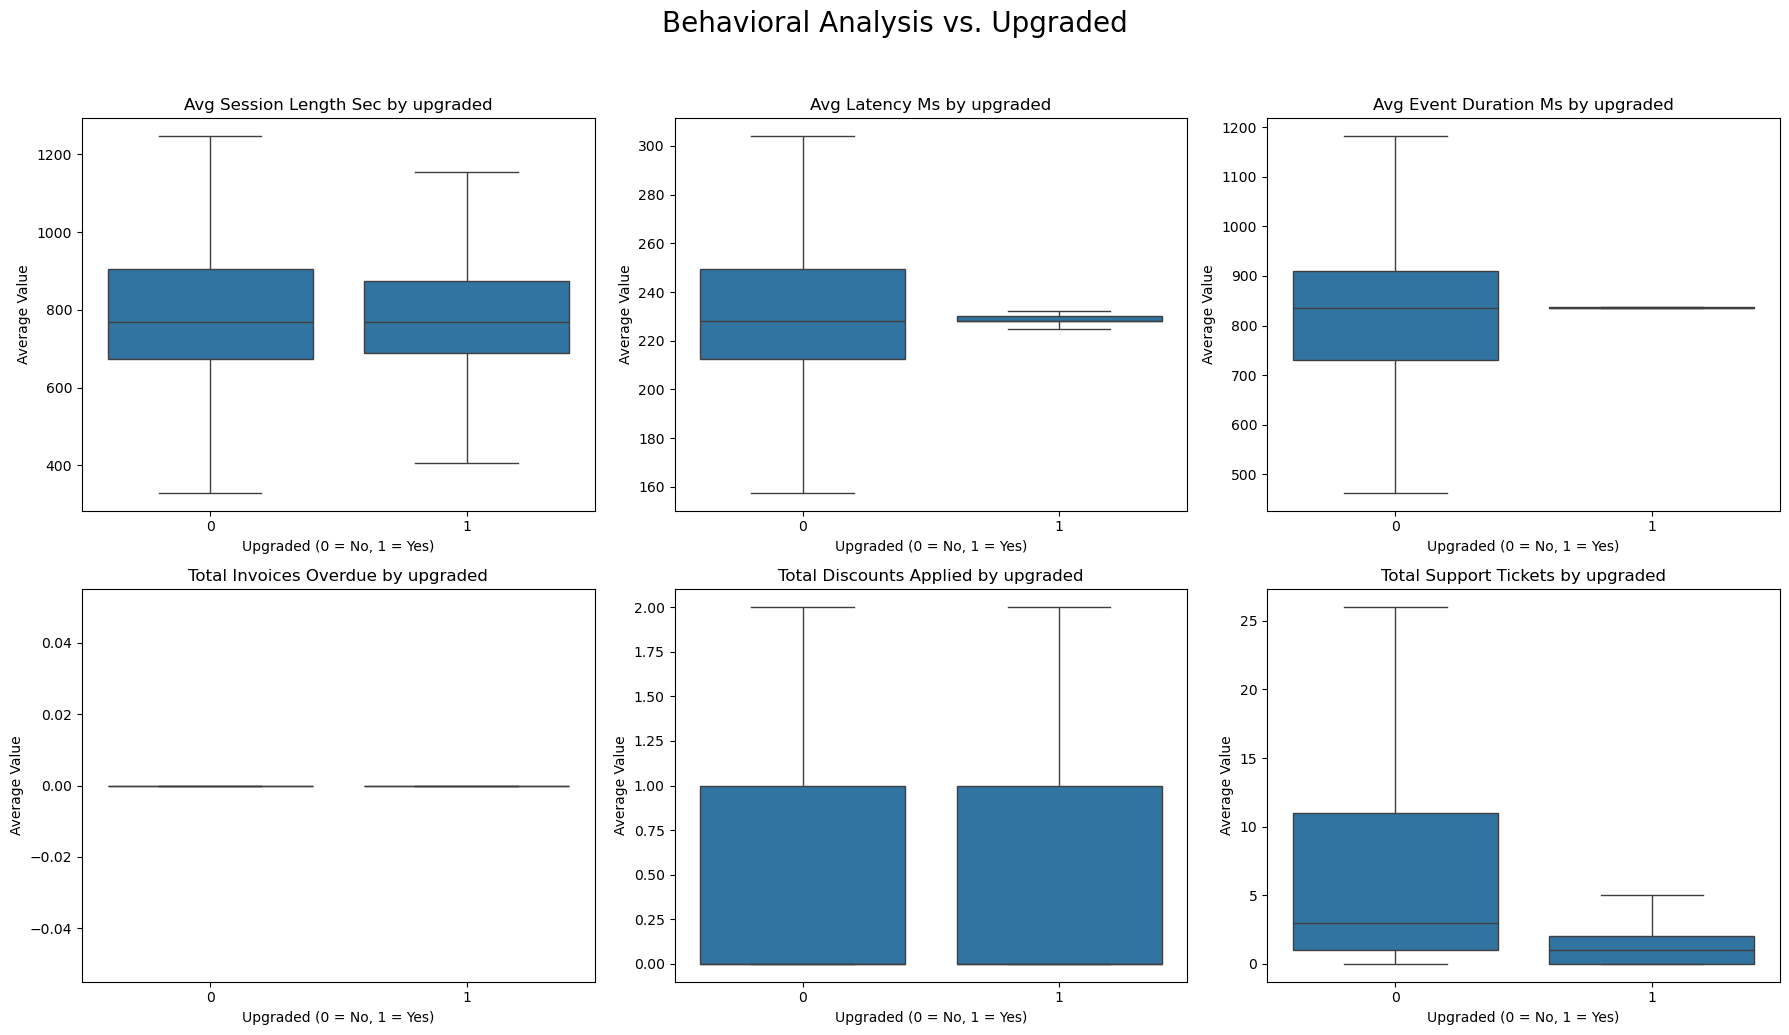

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load All Data ---



# --- 2. Aggregate Data to User Level ---
print("Aggregating data for each user...")

# a) Billing data aggregation
billing_agg = billing_df.groupby('user_id').agg(
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

# b) Session data aggregation
sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()

# c) Event data aggregation
events_agg = events_df.groupby('user_id').agg(
    avg_latency_ms=('latency_ms', 'mean'),
    avg_event_duration_ms=('duration_ms', 'mean'),
    success_rate=('success', lambda x: x.sum() / x.count() if x.count() > 0 else 0)
).reset_index()

# --- 3. Merge All Data into a Single DataFrame ---
print("Merging data sources...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')

# Create the 'upgraded' column from 'expansion_event'
df.rename(columns={'expansion_event': 'upgraded'}, inplace=True)

# --- 4. Prepare Data for Plotting ---
print("Preparing data for plotting...")

# Updated list of X variables, removing 'avg_active_seats' and 'success_rate'
x_vars = [
    'avg_session_length_sec', 'avg_latency_ms', 'avg_event_duration_ms',
    'total_invoices_overdue', 'total_discounts_applied', 'total_support_tickets'
]

# Your Y variables
y_vars = ['churned_30d', 'churned_90d', 'downgraded', 'upgraded']

# Combine the lists and handle potential missing values
plot_df = df[x_vars + y_vars].copy()
for col in x_vars:
    plot_df[col] = plot_df[col].fillna(plot_df[col].median())

# --- 5. Create a Stratified Sample for Readable Plots ---
sample_df = plot_df.groupby('churned_90d').apply(
    lambda x: x.sample(n=min(len(x), 1000), random_state=42)
).reset_index(drop=True)
print(f"Using a sample of {len(sample_df)} users for the plots.")

# --- 6. Generate and Save a Set of Boxplots for Each Y Variable ---
print("Generating boxplots... this may take a few moments.")

for y_var in y_vars:
    # Create a figure with subplots arranged in 2 rows
    n_cols = 3
    n_rows = (len(x_vars) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    fig.suptitle(f'Behavioral Analysis vs. {y_var.replace("_", " ").title()}', fontsize=20, y=1.03)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, x_var in enumerate(x_vars):
        sns.boxplot(x=y_var, y=x_var, data=sample_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{x_var.replace("_", " ").title()} by {y_var.replace("_", " ")}')
        axes[i].set_xlabel(f'{y_var.replace("_", " ").title()} (0 = No, 1 = Yes)')
        axes[i].set_ylabel('Average Value')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"boxplots_vs_{y_var}.png")
    print(f"Plot saved as 'boxplots_vs_{y_var}.png'")


Aggregating data for each user...
Merging data sources...
Preparing data for plotting...
Using a sample of 2000 users for the plots.
Generating scatter plots... this may take a few moments.


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/3795957736.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = plot_df.groupby('churned_90d').apply(


Plot saved as 'scatterplots_vs_churned_30d.png'
Plot saved as 'scatterplots_vs_churned_90d.png'
Plot saved as 'scatterplots_vs_downgraded.png'
Plot saved as 'scatterplots_vs_upgraded.png'


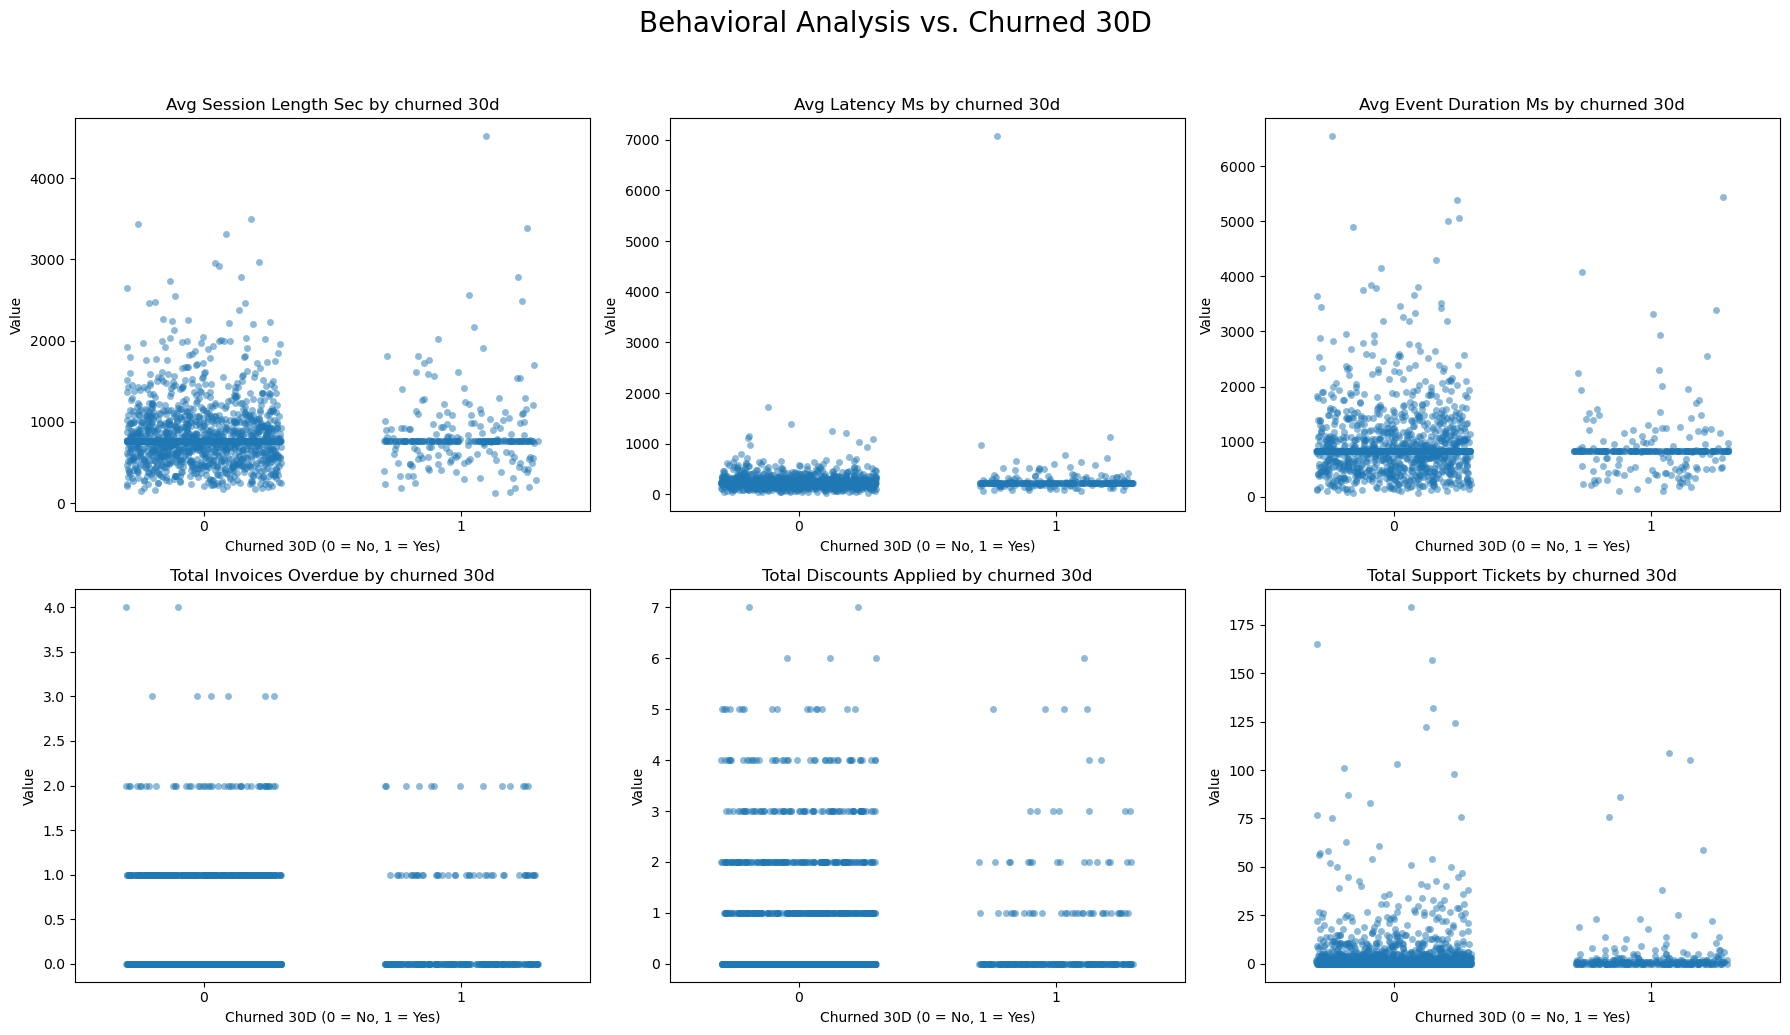

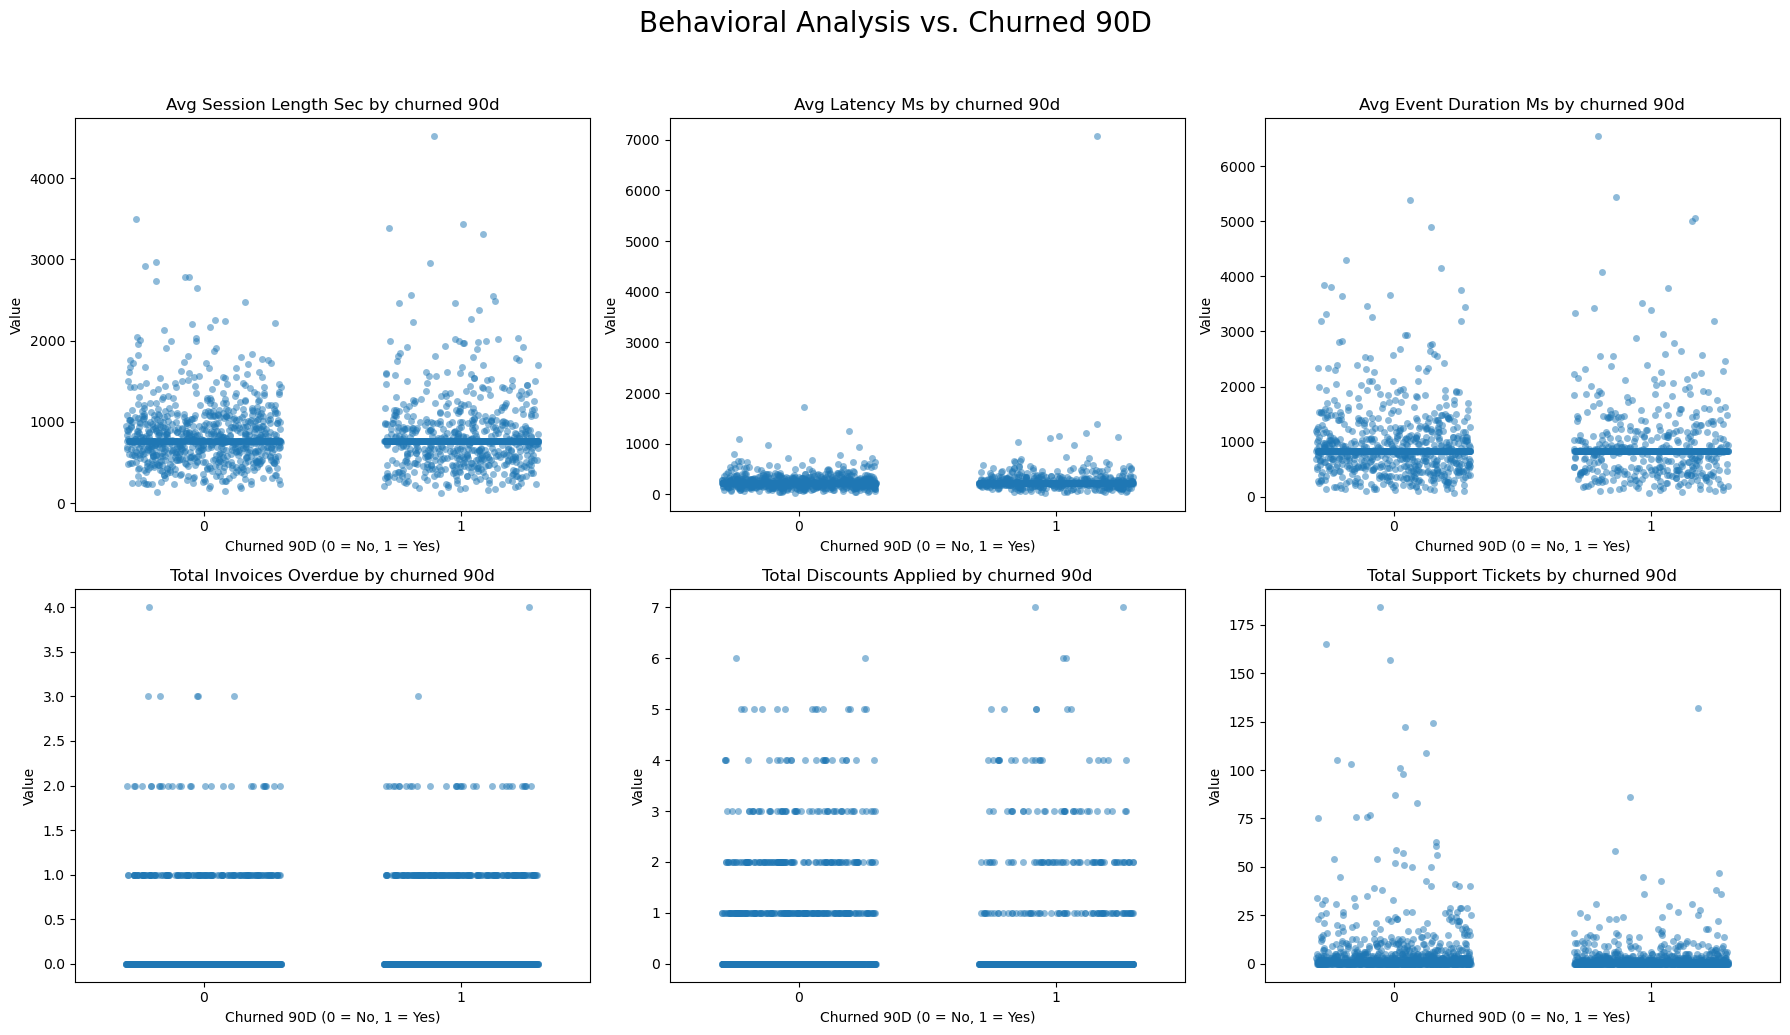

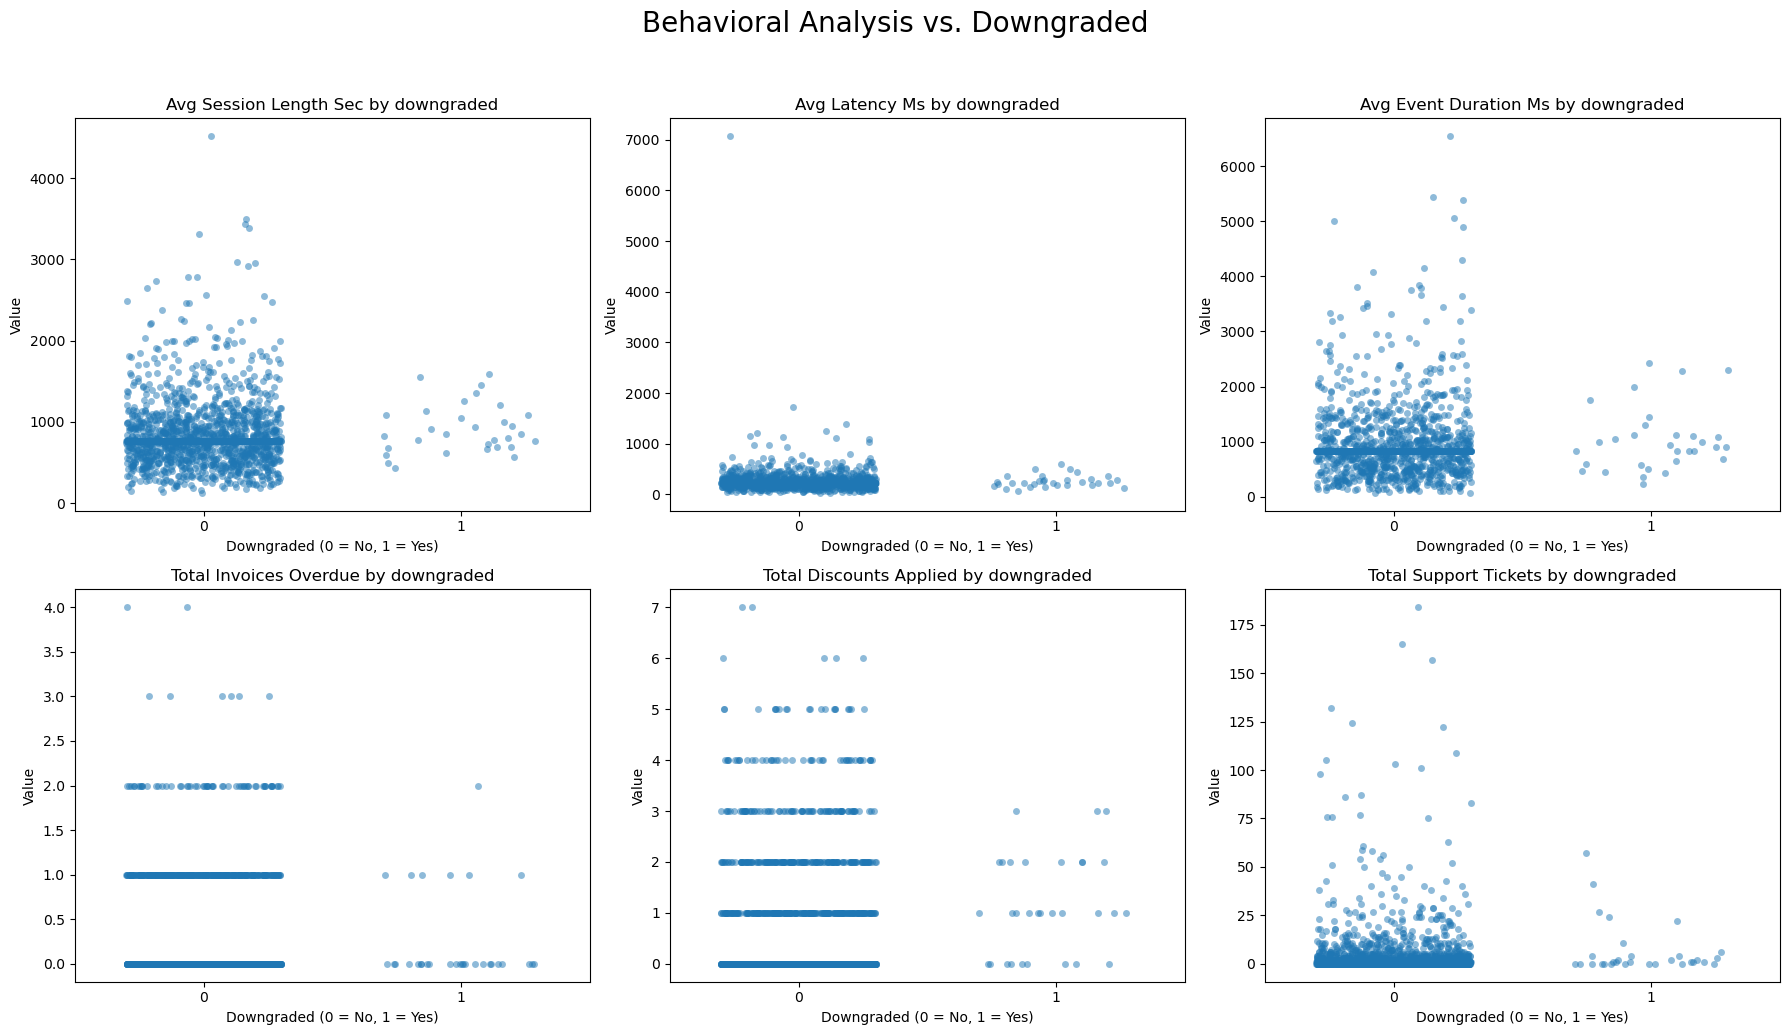

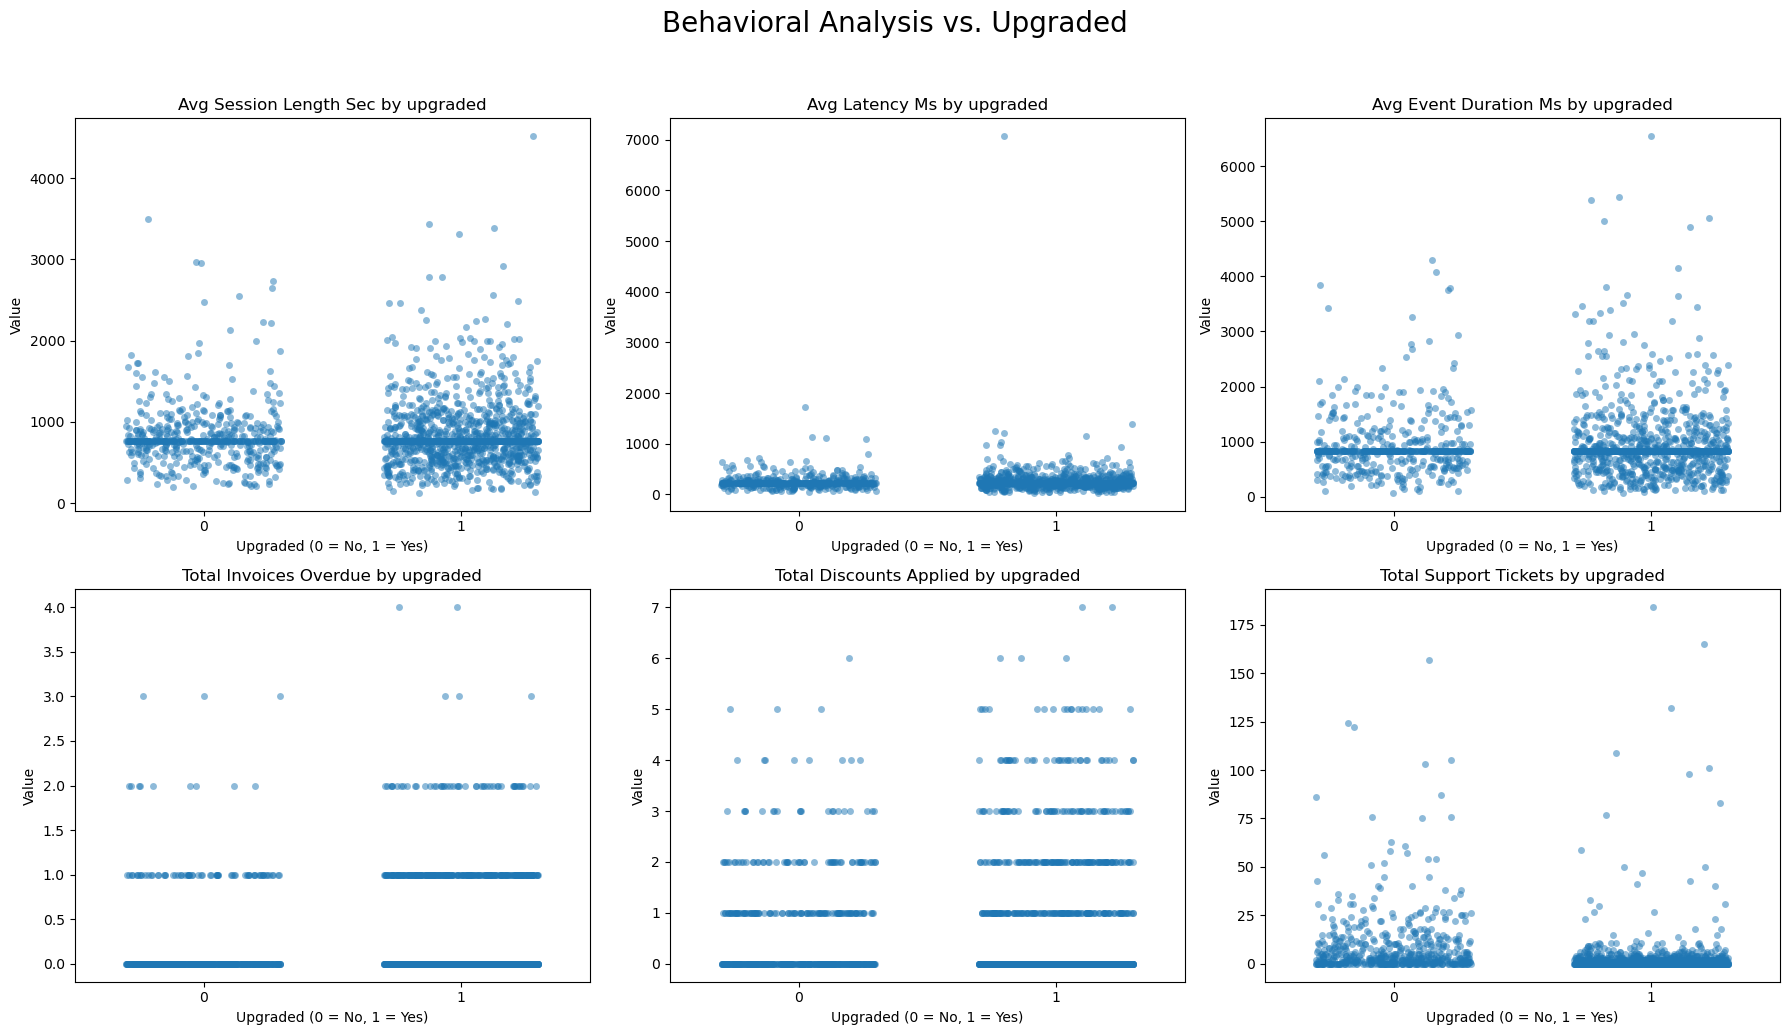

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# --- 2. Aggregate Data to User Level ---
print("Aggregating data for each user...")

# a) Billing data aggregation
billing_agg = billing_df.groupby('user_id').agg(
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

# b) Session data aggregation
sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()

# c) Event data aggregation
events_agg = events_df.groupby('user_id').agg(
    avg_latency_ms=('latency_ms', 'mean'),
    avg_event_duration_ms=('duration_ms', 'mean'),
    success_rate=('success', lambda x: x.sum() / x.count() if x.count() > 0 else 0)
).reset_index()

# --- 3. Merge All Data into a Single DataFrame ---
print("Merging data sources...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')

# Create the 'upgraded' column from 'expansion_event'
df.rename(columns={'expansion_event': 'upgraded'}, inplace=True)

# --- 4. Prepare Data for Plotting ---
print("Preparing data for plotting...")

# Updated list of X variables, removing 'avg_active_seats' and 'success_rate'
x_vars = [
    'avg_session_length_sec', 'avg_latency_ms', 'avg_event_duration_ms',
    'total_invoices_overdue', 'total_discounts_applied', 'total_support_tickets'
]

# Your Y variables
y_vars = ['churned_30d', 'churned_90d', 'downgraded', 'upgraded']

# Combine the lists and handle potential missing values
plot_df = df[x_vars + y_vars].copy()
for col in x_vars:
    plot_df[col] = plot_df[col].fillna(plot_df[col].median())

# --- 5. Create a Stratified Sample for Readable Plots ---
sample_df = plot_df.groupby('churned_90d').apply(
    lambda x: x.sample(n=min(len(x), 1000), random_state=42)
).reset_index(drop=True)
print(f"Using a sample of {len(sample_df)} users for the plots.")

# --- 6. Generate and Save a Set of Scatter Plots for Each Y Variable ---
print("Generating scatter plots... this may take a few moments.")

for y_var in y_vars:
    # Create a figure with subplots arranged in 2 rows
    n_cols = 3
    n_rows = (len(x_vars) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    fig.suptitle(f'Behavioral Analysis vs. {y_var.replace("_", " ").title()}', fontsize=20, y=1.03)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, x_var in enumerate(x_vars):
        # Use a stripplot (a type of scatter plot for categorical data) with jitter
        sns.stripplot(x=y_var, y=x_var, data=sample_df, ax=axes[i], jitter=0.3, alpha=0.5)
        axes[i].set_title(f'{x_var.replace("_", " ").title()} by {y_var.replace("_", " ")}')
        axes[i].set_xlabel(f'{y_var.replace("_", " ").title()} (0 = No, 1 = Yes)')
        axes[i].set_ylabel('Value')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"scatterplots_vs_{y_var}.png")
    print(f"Plot saved as 'scatterplots_vs_{y_var}.png'")

Calculating 'has_upgraded' flag based on MRR increase...
Aggregating feature data for each user...
Merging data sources into a final modeling dataframe...
Preparing features for the model...
Generating feature correlation heatmap...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/48632363.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_df[col].fillna(model_df[col].median(), inplace=True)
/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/48632363.py:75: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

Correlation heatmap saved as 'upgrade_correlation_heatmap.png'
Training the upgrade prediction model...

--- Model Evaluation ---
Classification Report:
                 precision    recall  f1-score   support

Did Not Upgrade       0.98      0.94      0.96     11424
       Upgraded       0.93      0.98      0.95      8576

       accuracy                           0.96     20000
      macro avg       0.96      0.96      0.96     20000
   weighted avg       0.96      0.96      0.96     20000


Confusion matrix saved as 'upgrade_prediction_confusion_matrix_mrr.png'


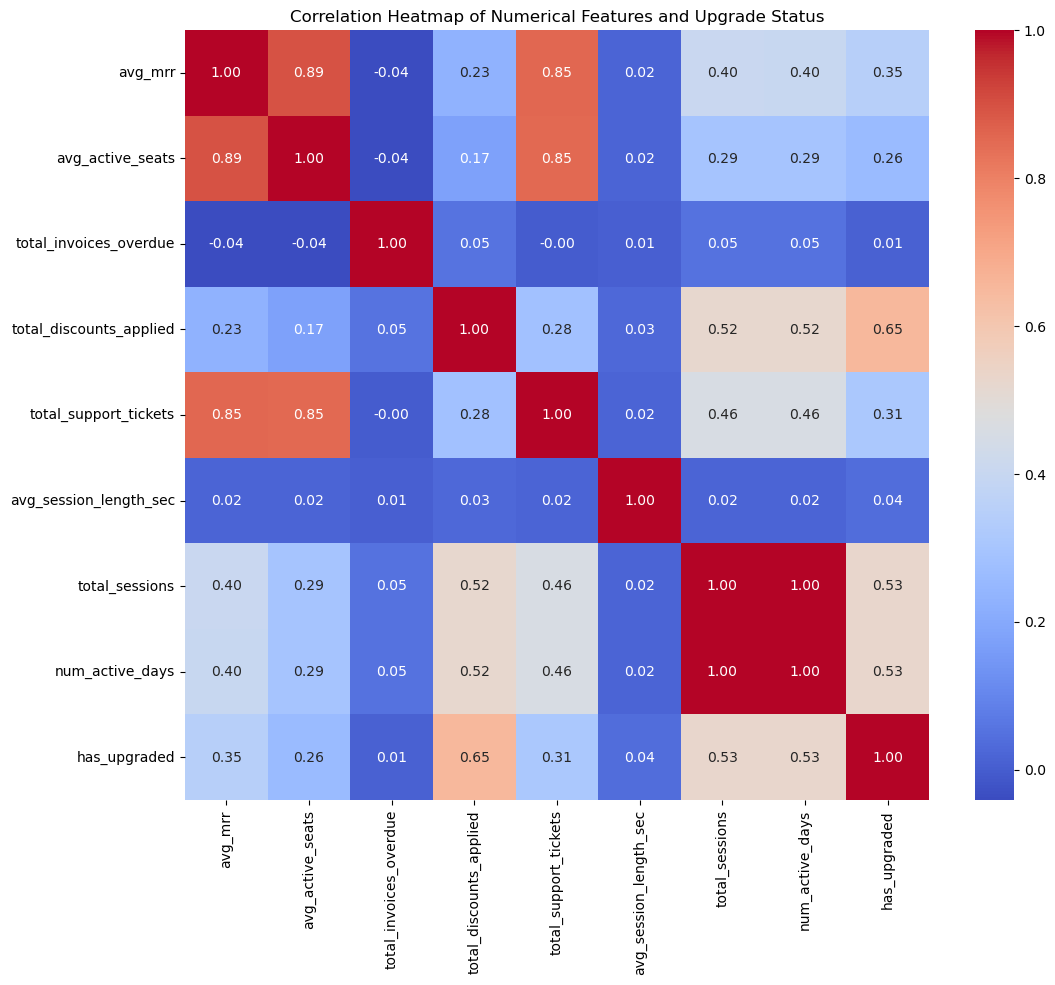

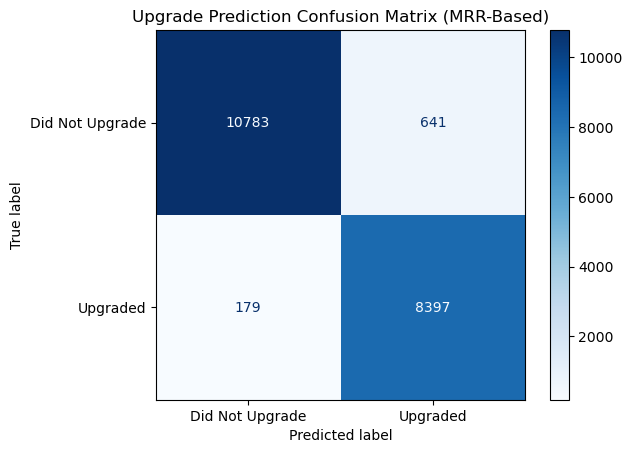

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# --- 2. Define the Target Variable (Your Superior Method) ---
print("Calculating 'has_upgraded' flag based on MRR increase...")

# Ensure month is a datetime object and sort
billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

# Calculate the difference in MRR from the previous month for each user
billing_df['mrr_diff'] = billing_df.groupby('user_id')['mrr'].diff()

# Find users who had at least one month with an MRR increase
upgraded_users = billing_df[billing_df['mrr_diff'] > 0]['user_id'].unique()

# Create the target DataFrame
upgrade_target_df = pd.DataFrame({'user_id': users_df['user_id'].unique()})
upgrade_target_df['has_upgraded'] = upgrade_target_df['user_id'].isin(upgraded_users).astype(int)


# --- 3. Aggregate Feature Data to User Level ---
print("Aggregating feature data for each user...")

# a) Billing data aggregation (we'll use this for features)
billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

# b) Session data aggregation
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])
sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count'),
    num_active_days=('session_start', lambda x: x.dt.date.nunique())
).reset_index()

# --- 4. Merge All Data into a Single DataFrame ---
print("Merging data sources into a final modeling dataframe...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
# Merge our new, accurate target variable
df = pd.merge(df, upgrade_target_df, on='user_id', how='left')


# --- 5. Feature Engineering and Preprocessing ---
print("Preparing features for the model...")

# Define target and features
TARGET = 'has_upgraded'
# Select features that could predict an upgrade (excluding the old expansion_event)
features = [
    'plan_tier', 'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_invoices_overdue', 'total_discounts_applied',
    'total_support_tickets', 'avg_session_length_sec', 'total_sessions', 'num_active_days'
]

model_df = df[features + [TARGET]].copy()

# Handle missing values
for col in model_df.select_dtypes(include=['float64', 'int64']).columns:
    model_df[col].fillna(model_df[col].median(), inplace=True)

for col in model_df.select_dtypes(include=['object']).columns:
    model_df[col].fillna(model_df[col].mode()[0], inplace=True)

# --- 5.5 Generate Correlation Heatmap ---
print("Generating feature correlation heatmap...")
numerical_features = model_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = model_df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features and Upgrade Status')
plt.savefig('upgrade_correlation_heatmap.png')
print("Correlation heatmap saved as 'upgrade_correlation_heatmap.png'")


# One-hot encode categorical variables
categorical_cols = model_df.select_dtypes(include=['object']).columns
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

# --- 6. Train the Random Forest Model ---
print("Training the upgrade prediction model...")

# Define X and y
X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

# --- 7. Evaluate the Model ---
print("\n--- Model Evaluation ---")
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Did Not Upgrade', 'Upgraded']))

# Generate and save confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Upgrade', 'Upgraded'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Upgrade Prediction Confusion Matrix (MRR-Based)')
plt.savefig('upgrade_prediction_confusion_matrix_mrr.png')
print("\nConfusion matrix saved as 'upgrade_prediction_confusion_matrix_mrr.png'")

Calculating 'has_upgraded' flag based on MRR increase...

--- Analyzing Behavior in the Month Before Upgrading ---

Top 10 features used in the month before an upgrade:
feature_name
jira_board               6355
confluence_page          3150
jira_automation          3003
confluence_ai_assist     1690
bitbucket_integration    1217
team_invite              1209
trello_export_csv         758
Name: count, dtype: int64

Pre-upgrade activity chart saved as 'pre_upgrade_feature_usage.png'

Aggregating feature data for each user for the model...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/593741655.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


Aggregating feature usage and total event counts from events data...
Merging data sources into a final modeling dataframe...
Preparing features for the model...
Generating feature correlation heatmap...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/593741655.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_df[col].fillna(0, inplace=True)
/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/593741655.py:143: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

Correlation heatmap saved as 'upgrade_correlation_heatmap.png'
Training the upgrade prediction model...

--- Model Evaluation ---
Classification Report:
                 precision    recall  f1-score   support

Did Not Upgrade       0.93      0.95      0.94     11424
       Upgraded       0.93      0.90      0.92      8576

       accuracy                           0.93     20000
      macro avg       0.93      0.93      0.93     20000
   weighted avg       0.93      0.93      0.93     20000


Confusion matrix saved as 'upgrade_prediction_confusion_matrix_mrr.png'


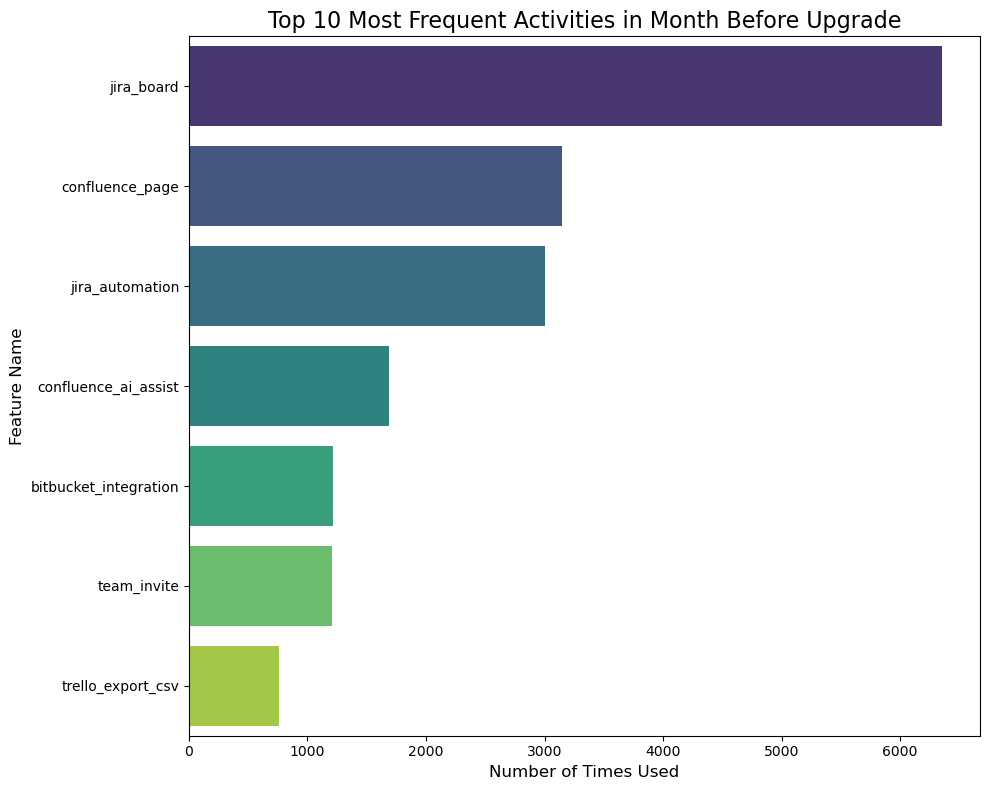

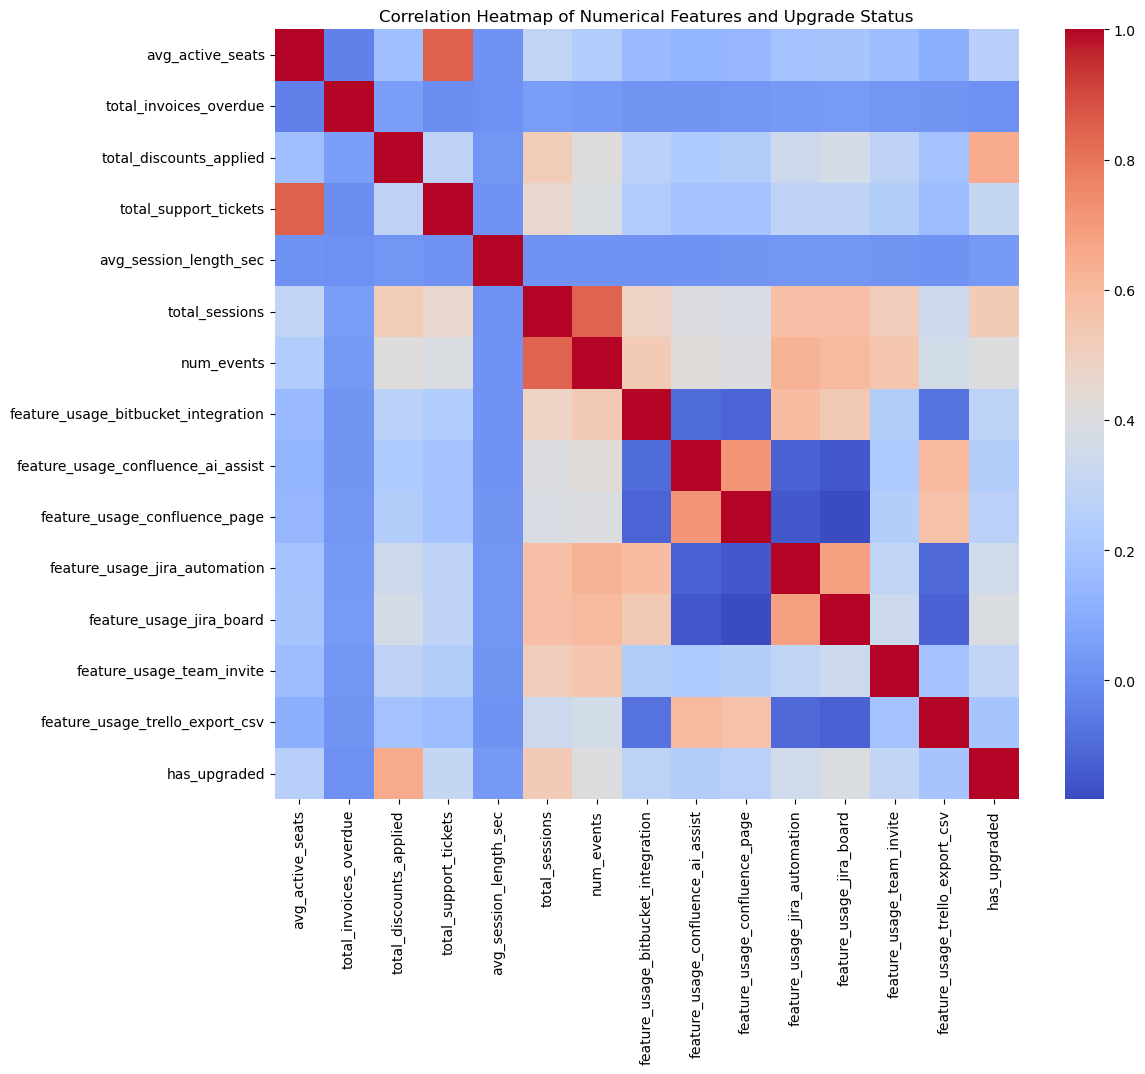

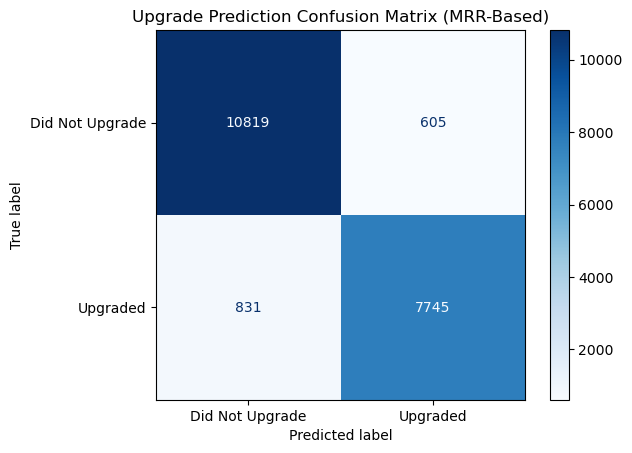

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 2. Define the Target Variable (Your Superior Method) ---
print("Calculating 'has_upgraded' flag based on MRR increase...")

# Ensure month is a datetime object and sort
billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

# Calculate the difference in MRR from the previous month for each user
billing_df['mrr_diff'] = billing_df.groupby('user_id')['mrr'].diff()

# Find users who had at least one month with an MRR increase
upgraded_users = billing_df[billing_df['mrr_diff'] > 0]['user_id'].unique()

# Create the target DataFrame
upgrade_target_df = pd.DataFrame({'user_id': users_df['user_id'].unique()})
upgrade_target_df['has_upgraded'] = upgrade_target_df['user_id'].isin(upgraded_users).astype(int)


# --- 2.5 Analyze Pre-Upgrade Behavior ---
print("\n--- Analyzing Behavior in the Month Before Upgrading ---")
events_df['ts'] = pd.to_datetime(events_df['ts'])

# Isolate the exact month of the first upgrade for each user
# --- FIX START ---
# 1. Create a dataframe that ONLY contains upgrade events.
upgrades_df = billing_df[billing_df['mrr_diff'] > 0].copy()

# 2. From this new dataframe, find the index of the earliest month for each user.
#    This gives us the index of their first-ever upgrade.
first_upgrade_indices = upgrades_df.groupby('user_id')['month'].idxmin()

# 3. Use these correct indices to select the rows from the upgrades_df.
first_upgrade_moments = upgrades_df.loc[first_upgrade_indices][['user_id', 'month']]
# --- FIX END ---

first_upgrade_moments.rename(columns={'month': 'upgrade_month'}, inplace=True)

# Calculate the pre-upgrade month (t-1)
first_upgrade_moments['pre_upgrade_month'] = first_upgrade_moments['upgrade_month'] - pd.DateOffset(months=1)

# Get event data for these users only during their pre-upgrade month
pre_upgrade_events = pd.merge(
    events_df,
    first_upgrade_moments,
    on='user_id'
)
pre_upgrade_events = pre_upgrade_events[
    pre_upgrade_events['ts'].dt.to_period('M') == pre_upgrade_events['pre_upgrade_month'].dt.to_period('M')
]

if not pre_upgrade_events.empty:
    # Find the most common features used
    top_features = pre_upgrade_events['feature_name'].value_counts().nlargest(10)
    print("\nTop 10 features used in the month before an upgrade:")
    print(top_features)

    # Visualize the top features
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title('Top 10 Most Frequent Activities in Month Before Upgrade', fontsize=16)
    plt.xlabel('Number of Times Used', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)
    plt.tight_layout()
    plt.savefig('pre_upgrade_feature_usage.png')
    print("\nPre-upgrade activity chart saved as 'pre_upgrade_feature_usage.png'")
else:
    print("\nCould not find sufficient event data in the pre-upgrade months to analyze.")

# --- 3. Aggregate Feature Data to User Level ---
print("\nAggregating feature data for each user for the model...")

# a) Billing data aggregation
billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

# b) Session data aggregation
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])
sessions_agg = sessions_df.groupby('user_id').agg(
    avg_session_length_sec=('session_length_sec', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()

# c) Events data aggregation (feature usage counts and total events)
print("Aggregating feature usage and total event counts from events data...")
feature_counts = events_df.groupby(['user_id', 'feature_name']).size().unstack(fill_value=0)
feature_counts.columns = [f'feature_usage_{col.replace(" ", "_")}' for col in feature_counts.columns]
feature_counts.reset_index(inplace=True)

events_agg = events_df.groupby('user_id').agg(
    num_events=('event_id', 'count')
).reset_index()


# --- 4. Merge All Data into a Single DataFrame ---
print("Merging data sources into a final modeling dataframe...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')
df = pd.merge(df, feature_counts, on='user_id', how='left')
# Merge our new, accurate target variable
df = pd.merge(df, upgrade_target_df, on='user_id', how='left')


# --- 5. Feature Engineering and Preprocessing ---
print("Preparing features for the model...")

# Define target and features
TARGET = 'has_upgraded'
# Select base features
features = [
    'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
    'avg_active_seats', 'total_invoices_overdue', 'total_discounts_applied',
    'total_support_tickets', 'avg_session_length_sec', 'total_sessions', 'num_events'
]
# Add the new feature usage columns to our list of features
feature_usage_cols = [col for col in df.columns if col.startswith('feature_usage_')]
features.extend(feature_usage_cols)

model_df = df[features + [TARGET]].copy()

# Handle missing values
# For feature counts, NaN means the user had no events, so fill with 0
for col in feature_usage_cols:
    if col in model_df.columns:
        model_df[col].fillna(0, inplace=True)

# For other numerical columns, use median
for col in model_df.select_dtypes(include=['float64', 'int64']).columns:
     if col not in feature_usage_cols and col != TARGET:
        model_df[col].fillna(model_df[col].median(), inplace=True)

# For categorical columns, use mode
for col in model_df.select_dtypes(include=['object']).columns:
    model_df[col].fillna(model_df[col].mode()[0], inplace=True)

# --- 5.5 Generate Correlation Heatmap ---
print("Generating feature correlation heatmap...")
numerical_features = model_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = model_df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm') # annot=False for readability with many features
plt.title('Correlation Heatmap of Numerical Features and Upgrade Status')
plt.savefig('upgrade_correlation_heatmap.png')
print("Correlation heatmap saved as 'upgrade_correlation_heatmap.png'")


# One-hot encode categorical variables
categorical_cols = model_df.select_dtypes(include=['object']).columns
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

# --- 6. Train the Random Forest Model ---
print("Training the upgrade prediction model...")

# Define X and y
X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

# --- 7. Evaluate the Model ---
print("\n--- Model Evaluation ---")
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Did Not Upgrade', 'Upgraded']))

# Generate and save confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Upgrade', 'Upgraded'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Upgrade Prediction Confusion Matrix (MRR-Based)')
plt.savefig('upgrade_prediction_confusion_matrix_mrr.png')
print("\nConfusion matrix saved as 'upgrade_prediction_confusion_matrix_mrr.png'")

has_upgraded
0    57120
1    42880
Name: count, dtype: int64

--- Analyzing Feature Importances ---
Top 20 most important features for predicting upgrades:
                    feature  importance
3   total_discounts_applied    0.244342
16       plan_tier_standard    0.227186
6            total_sessions    0.121876
15        plan_tier_premium    0.071997
1          avg_active_seats    0.065031

Feature importance chart saved as 'upgrade_feature_importances.png'


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2455548587.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')


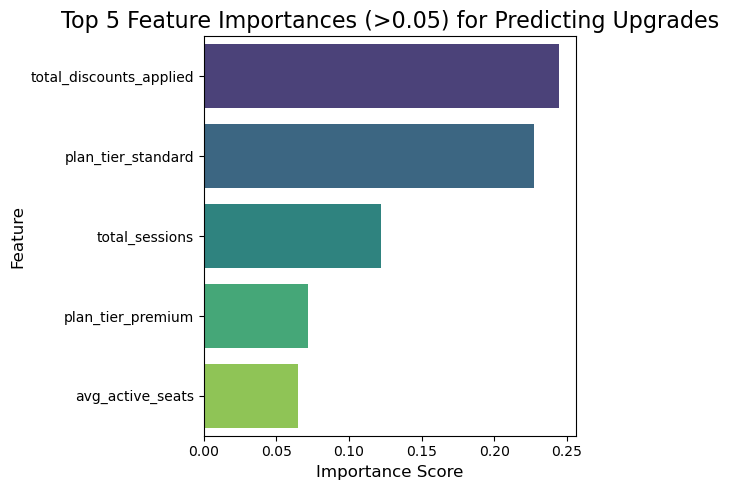

In [126]:
print(model_df[TARGET].value_counts())

# --- 8. Analyze and Visualize Feature Importance ---
print("\n--- Analyzing Feature Importances ---")

# Get feature importances from the trained model
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier sorting and plotting
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Select the top 20 most important features for a clean visualization
top_20_features = feature_importance_df.head(5)

print("Top 20 most important features for predicting upgrades:")
print(top_20_features)

# Create the visualization
plt.figure(figsize=(6, 5))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 5 Feature Importances (>0.05) for Predicting Upgrades', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('upgrade_feature_importances.png')
print("\nFeature importance chart saved as 'upgrade_feature_importances.png'")


--- Analyzing Feature Importances ---
Full ranked list of feature importances:
                                feature  importance
1                               avg_mrr    0.315584
4               total_discounts_applied    0.173822
17                   plan_tier_standard    0.127207
7                        total_sessions    0.114794
16                    plan_tier_premium    0.054067
8                            num_events    0.041103
2                      avg_active_seats    0.033670
5                 total_support_tickets    0.033029
6                avg_session_length_sec    0.021305
13             feature_usage_jira_board    0.019948
12        feature_usage_jira_automation    0.009159
14            feature_usage_team_invite    0.007021
10   feature_usage_confluence_ai_assist    0.004417
9   feature_usage_bitbucket_integration    0.004209
11        feature_usage_confluence_page    0.004119
18                   company_size_11-50    0.003017
32              acquisition_channel_

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/644730700.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')



Feature importance chart saved as 'upgrade_feature_importances.png'


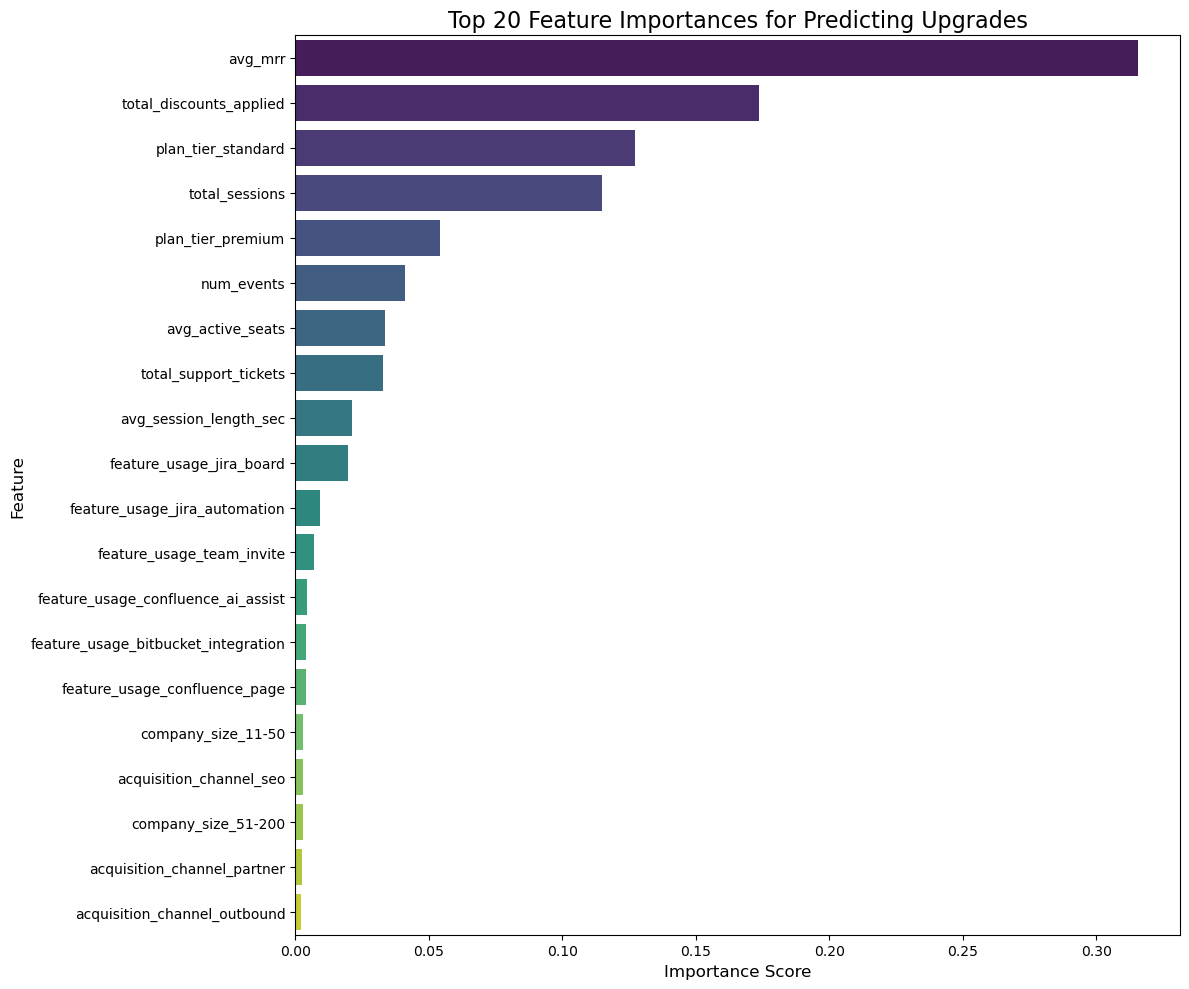

In [117]:
# --- 8. Analyze and Visualize Feature Importance ---
print("\n--- Analyzing Feature Importances ---")

# Get feature importances from the trained model
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier sorting and plotting
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


# --- CHANGE: Print the ENTIRE list of feature importances ---
print("Full ranked list of feature importances:")
# Use .to_string() to ensure pandas doesn't truncate the list
print(feature_importance_df.to_string())


# Select the top 20 most important features for a clean visualization
top_20_features = feature_importance_df.head(20)

# Create the visualization
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importances for Predicting Upgrades', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('upgrade_feature_importances.png')
print("\nFeature importance chart saved as 'upgrade_feature_importances.png'")

Identifying users who have upgraded...
Determining primary country for each user...
Merging data for demographic analysis...
Generating comparison charts...

Demographic analysis chart saved as 'upgrading_company_demographics.png'


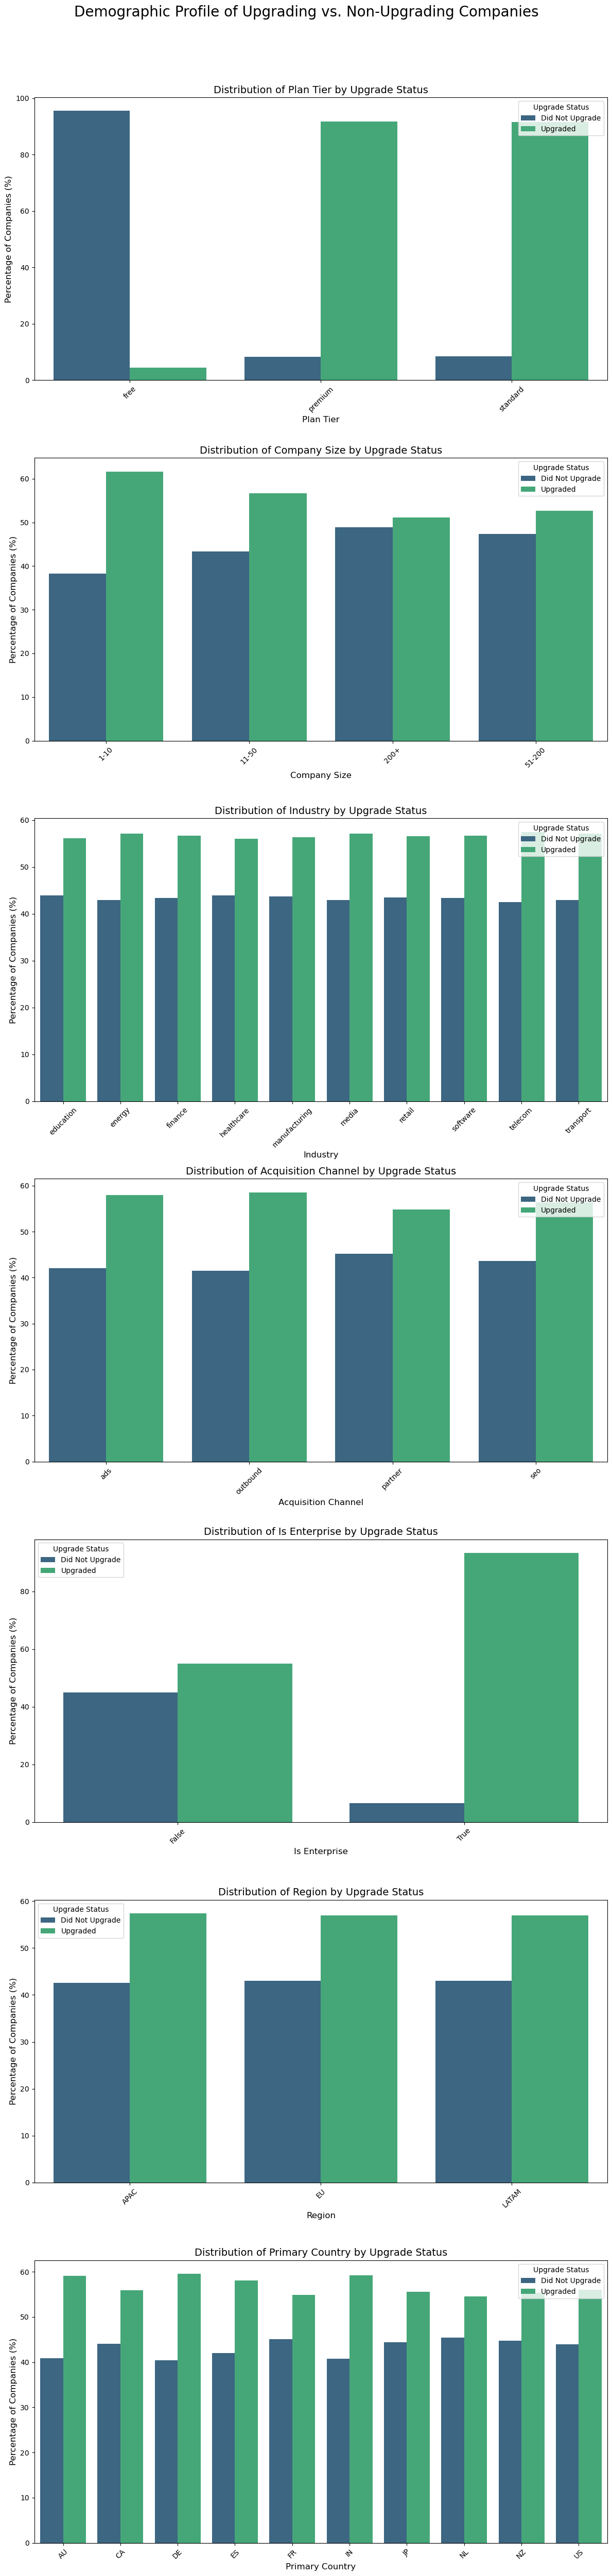

In [49]:


# --- 2. Identify Upgrading Users (MRR-Based Definition) ---
print("Identifying users who have upgraded...")
# Ensure month is a datetime object and sort
billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

# Calculate the difference in MRR from the previous month for each user
billing_df['mrr_diff'] = billing_df.groupby('user_id')['mrr'].diff()

# Find users who had at least one month with an MRR increase
upgraded_user_ids = billing_df[billing_df['mrr_diff'] > 0]['user_id'].unique()

# Create the target flag
users_df['has_upgraded'] = users_df['user_id'].isin(upgraded_user_ids).astype(int)

# --- 3. Get User Country Information ---
# A user might have sessions from multiple countries. We'll find the most frequent one.
print("Determining primary country for each user...")
user_country = sessions_df.groupby('user_id')['country'].agg(lambda x: x.mode()[0] if not x.empty else None).reset_index()
user_country.rename(columns={'country': 'primary_country'}, inplace=True)


# --- 4. Merge Data for Analysis ---
print("Merging data for demographic analysis...")
analysis_df = pd.merge(users_df, user_country, on='user_id', how='left')

# Drop users with no session data
analysis_df.dropna(subset=['primary_country'], inplace=True)


# --- 5. Analyze and Visualize Demographics ---
print("Generating comparison charts...")

# Define the demographic features you want to investigate
demographic_features = [
    'plan_tier', 'company_size', 'industry', 'acquisition_channel',
    'is_enterprise', 'region', 'primary_country'
]

# For country, we'll only look at the top 10 most common countries to keep the chart readable
top_10_countries = analysis_df['primary_country'].value_counts().nlargest(10).index
analysis_df_top_countries = analysis_df[analysis_df['primary_country'].isin(top_10_countries)]


# Create a figure to hold all the subplots
fig, axes = plt.subplots(len(demographic_features), 1, figsize=(12, 7 * len(demographic_features)))
fig.suptitle('Demographic Profile of Upgrading vs. Non-Upgrading Companies', fontsize=20, y=1.02)

for i, feature in enumerate(demographic_features):
    ax = axes[i]
    # Use a different dataframe for the country plot
    plot_data = analysis_df_top_countries if feature == 'primary_country' else analysis_df

    # Use seaborn's catplot functionality but on a specific axis
    # We calculate percentages and plot them
    df_plot = plot_data.groupby(feature)['has_upgraded'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

    sns.barplot(x=feature, y='percent', hue='has_upgraded', data=df_plot, ax=ax, palette='viridis')

    ax.set_title(f'Distribution of {feature.replace("_", " ").title()} by Upgrade Status', fontsize=14)
    ax.set_ylabel('Percentage of Companies (%)', fontsize=12)
    ax.set_xlabel(feature.replace("_", " ").title(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    # Update legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Did Not Upgrade', 'Upgraded'], title='Upgrade Status')


plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout
plt.savefig('upgrading_company_demographics.png')
print("\nDemographic analysis chart saved as 'upgrading_company_demographics.png'")

Identifying users who upgraded based on plan changes...

--- Analyzing 'Free to Paid' Upgraders ---

Average time for a free user to upgrade: 6.21 months
Demographic pie charts for 'Free to Paid' upgraders saved as 'free_to_paid_demographics.png'

Aggregating all user data for the prediction model...
Building and evaluating the Random Forest model...
Correlation heatmap saved as 'plan_upgrade_correlation_heatmap.png'

--- Model Evaluation (Predicting Plan-Change Upgrade) ---
Classification Report:
                 precision    recall  f1-score   support

Did Not Upgrade       0.98      1.00      0.99     11119
       Upgraded       0.91      0.47      0.62       344

       accuracy                           0.98     11463
      macro avg       0.94      0.74      0.81     11463
   weighted avg       0.98      0.98      0.98     11463

Confusion matrix saved as 'plan_upgrade_confusion_matrix.png'


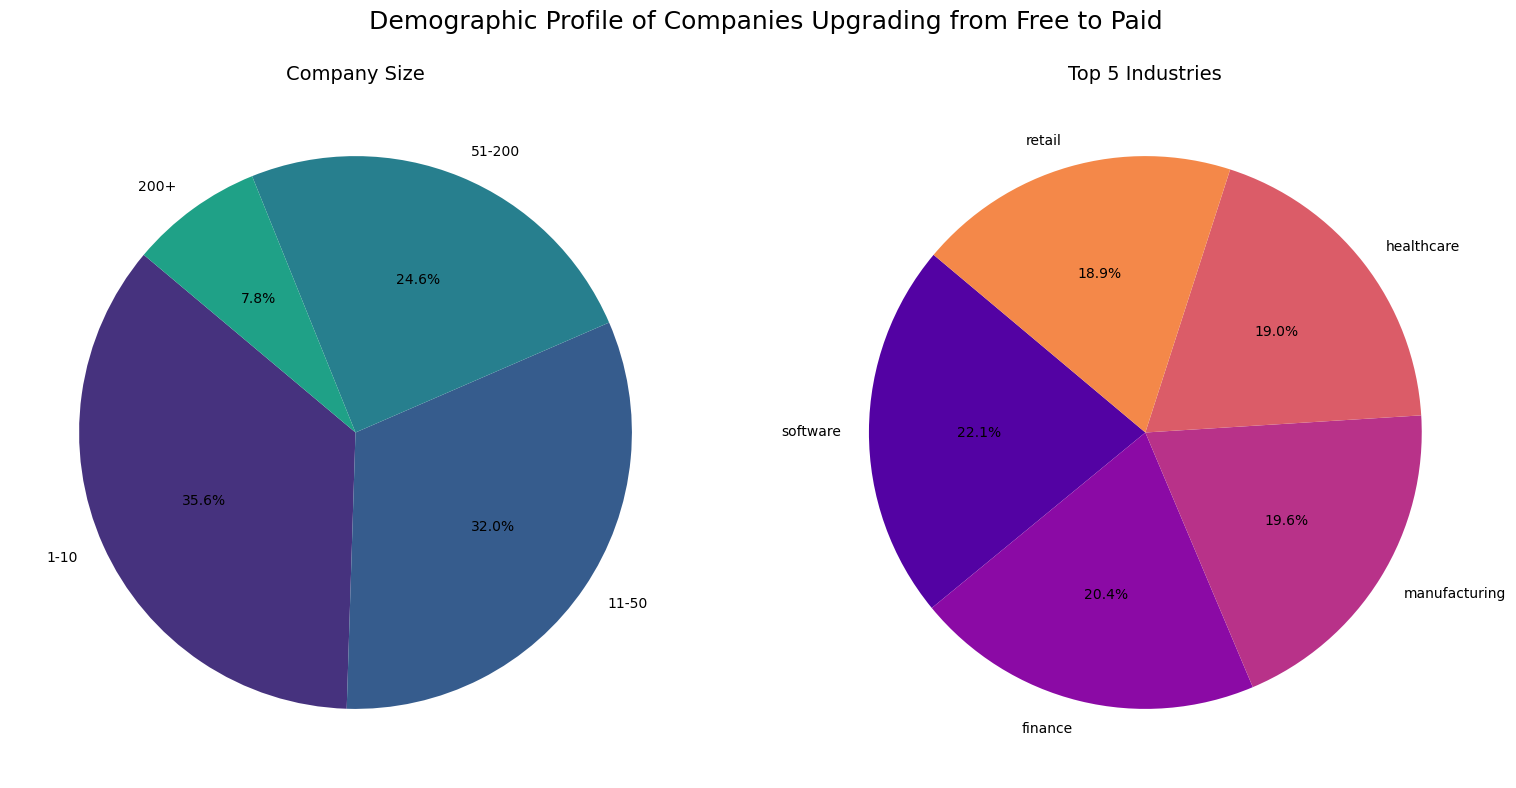

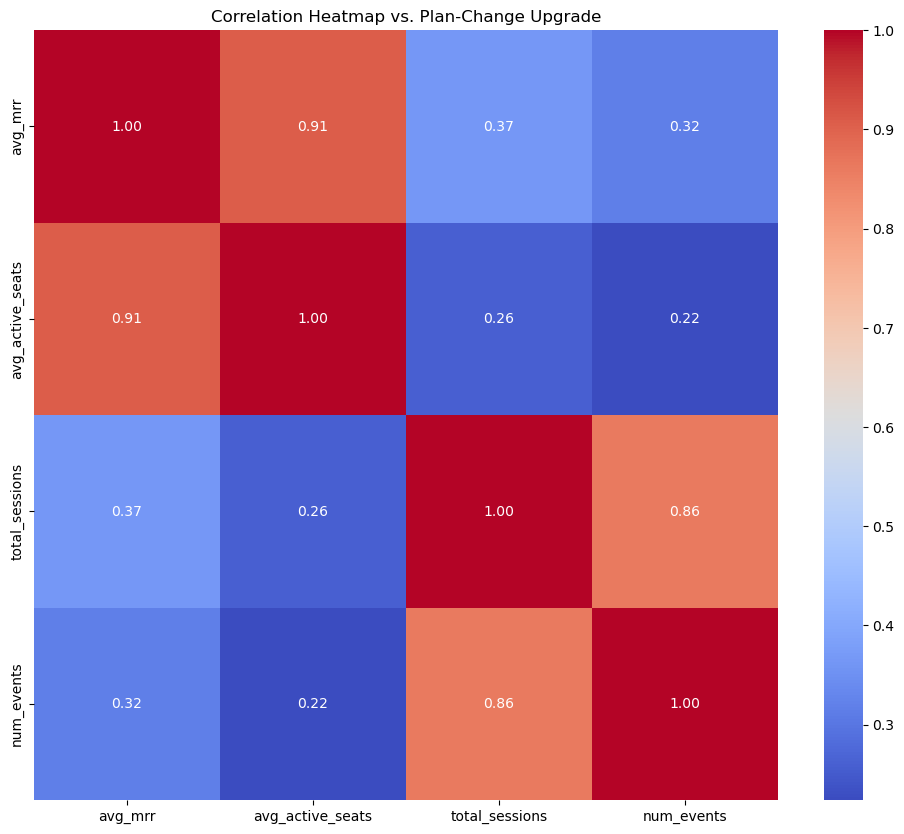

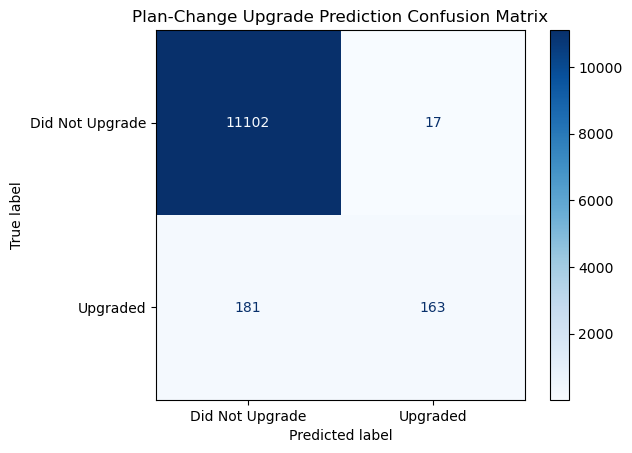

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# --- 2. Define New Upgrade Target (Based on Plan Change) ---
print("Identifying users who upgraded based on plan changes...")
billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

def detect_plan_upgrade(plans):
    """Checks for specific plan transitions in a user's history."""
    plans_tuple = tuple(plans)
    upgraded_from_free = ('free', 'standard') in zip(plans_tuple, plans_tuple[1:]) or \
                         ('free', 'premium') in zip(plans_tuple, plans_tuple[1:])
    upgraded_from_standard = ('standard', 'premium') in zip(plans_tuple, plans_tuple[1:])
    return pd.Series([upgraded_from_free, upgraded_from_standard])

# --- FIX START ---
# Group by user, apply the function, and then unstack the multi-level index into columns
upgrade_flags = billing_df.groupby('user_id')['plan_tier'].apply(detect_plan_upgrade).unstack()
upgrade_flags.columns = ['upgraded_from_free', 'upgraded_from_standard']

# Reset the index to turn 'user_id' from an index into a column
upgrade_flags = upgrade_flags.reset_index()
# --- FIX END ---

# The final target is if a user made ANY of these upgrades
upgrade_flags['has_upgraded'] = upgrade_flags['upgraded_from_free'] | upgrade_flags['upgraded_from_standard']
upgrade_target_df = upgrade_flags[['user_id', 'has_upgraded']]


# --- 3. Deep Dive on "Free to Paid" Upgraders ---
print("\n--- Analyzing 'Free to Paid' Upgraders ---")
# Need to merge back to get the 'upgraded_from_free' flag
free_to_paid_user_ids = upgrade_flags[upgrade_flags['upgraded_from_free']]['user_id']
free_to_paid_df = pd.merge(users_df, pd.DataFrame(free_to_paid_user_ids), on='user_id', how='inner')

# a) Calculate time to upgrade
if not free_to_paid_df.empty:
    first_paid_month = billing_df[billing_df['plan_tier'] != 'free'].groupby('user_id')['month'].min().reset_index()
    first_paid_month.rename(columns={'month': 'first_paid_month'}, inplace=True)
    time_to_upgrade_df = pd.merge(free_to_paid_df, first_paid_month, on='user_id')
    time_to_upgrade_df['signup_date'] = pd.to_datetime(time_to_upgrade_df['signup_date'])
    time_to_upgrade_df['months_to_upgrade'] = (time_to_upgrade_df['first_paid_month'].dt.to_period('M') - \
                                            time_to_upgrade_df['signup_date'].dt.to_period('M')).apply(lambda x: x.n)

    print(f"\nAverage time for a free user to upgrade: {time_to_upgrade_df['months_to_upgrade'].mean():.2f} months")

    # b) Visualize Demographics with Pie Charts
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Demographic Profile of Companies Upgrading from Free to Paid', fontsize=18)
    # Company Size
    company_size_counts = free_to_paid_df['company_size'].value_counts()
    axes[0].pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
    axes[0].set_title('Company Size', fontsize=14)
    # Industry
    industry_counts = free_to_paid_df['industry'].value_counts().nlargest(5) # Top 5 for readability
    axes[1].pie(industry_counts, labels=industry_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('plasma'))
    axes[1].set_title('Top 5 Industries', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('free_to_paid_demographics.png')
    print("Demographic pie charts for 'Free to Paid' upgraders saved as 'free_to_paid_demographics.png'")
else:
    print("No users found who upgraded from a free plan.")


# --- 4. Aggregate Data for the Model ---
print("\nAggregating all user data for the prediction model...")
billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

sessions_agg = sessions_df.groupby('user_id').agg(
    total_sessions=('session_id', 'count'),
    avg_session_length_sec=('session_length_sec', 'mean')
).reset_index()

events_agg = events_df.groupby('user_id').agg(num_events=('event_id', 'count')).reset_index()

# --- 5. Merge, Preprocess, and Build Model ---
print("Building and evaluating the Random Forest model...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')
df = pd.merge(df, upgrade_target_df, on='user_id', how='left')

# Define target and features
TARGET = 'has_upgraded'
features = ['plan_tier', 'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
            'avg_mrr', 'avg_active_seats', 'total_sessions', 'num_events']
model_df = df[features + [TARGET]].copy().dropna()

# Generate Correlation Heatmap
plt.figure(figsize=(12, 10))
numerical_features = model_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = model_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap vs. Plan-Change Upgrade')
plt.savefig('plan_upgrade_correlation_heatmap.png')
print("Correlation heatmap saved as 'plan_upgrade_correlation_heatmap.png'")

# Prepare data for model
model_df = pd.get_dummies(model_df, columns=model_df.select_dtypes(include=['object']).columns, drop_first=True)
X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train and Evaluate Model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

print("\n--- Model Evaluation (Predicting Plan-Change Upgrade) ---")
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Did Not Upgrade', 'Upgraded']))

# Generate and save confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Upgrade', 'Upgraded'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Plan-Change Upgrade Prediction Confusion Matrix')
plt.savefig('plan_upgrade_confusion_matrix.png')
print("Confusion matrix saved as 'plan_upgrade_confusion_matrix.png'")



Files loaded successfully!
Identifying users who upgraded based on plan changes...

--- Analyzing 'Free to Paid' Upgraders ---

Average time for a free user to upgrade: 6.21 months
Demographic pie charts for 'Free to Paid' upgraders saved as 'free_to_paid_demographics.png'

Aggregating all user data for the prediction model...
Building and evaluating the Random Forest model...
Correlation heatmap saved as 'plan_upgrade_correlation_heatmap.png'

--- Model Evaluation (Predicting Plan-Change Upgrade) ---
Classification Report:
                 precision    recall  f1-score   support

Did Not Upgrade       0.98      1.00      0.99     11119
       Upgraded       0.91      0.47      0.62       344

       accuracy                           0.98     11463
      macro avg       0.95      0.73      0.80     11463
   weighted avg       0.98      0.98      0.98     11463

Confusion matrix saved as 'plan_upgrade_confusion_matrix.png'


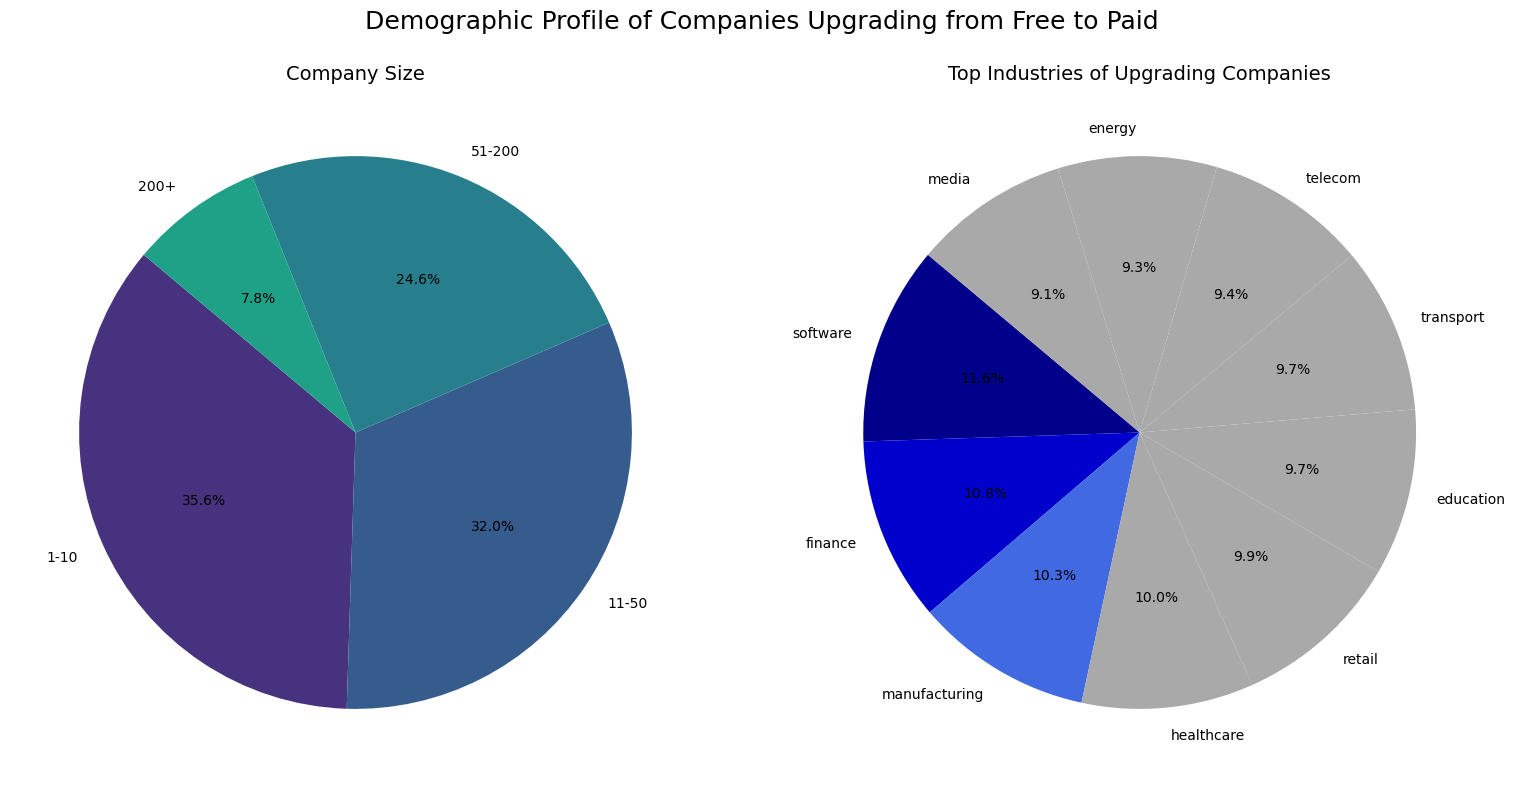

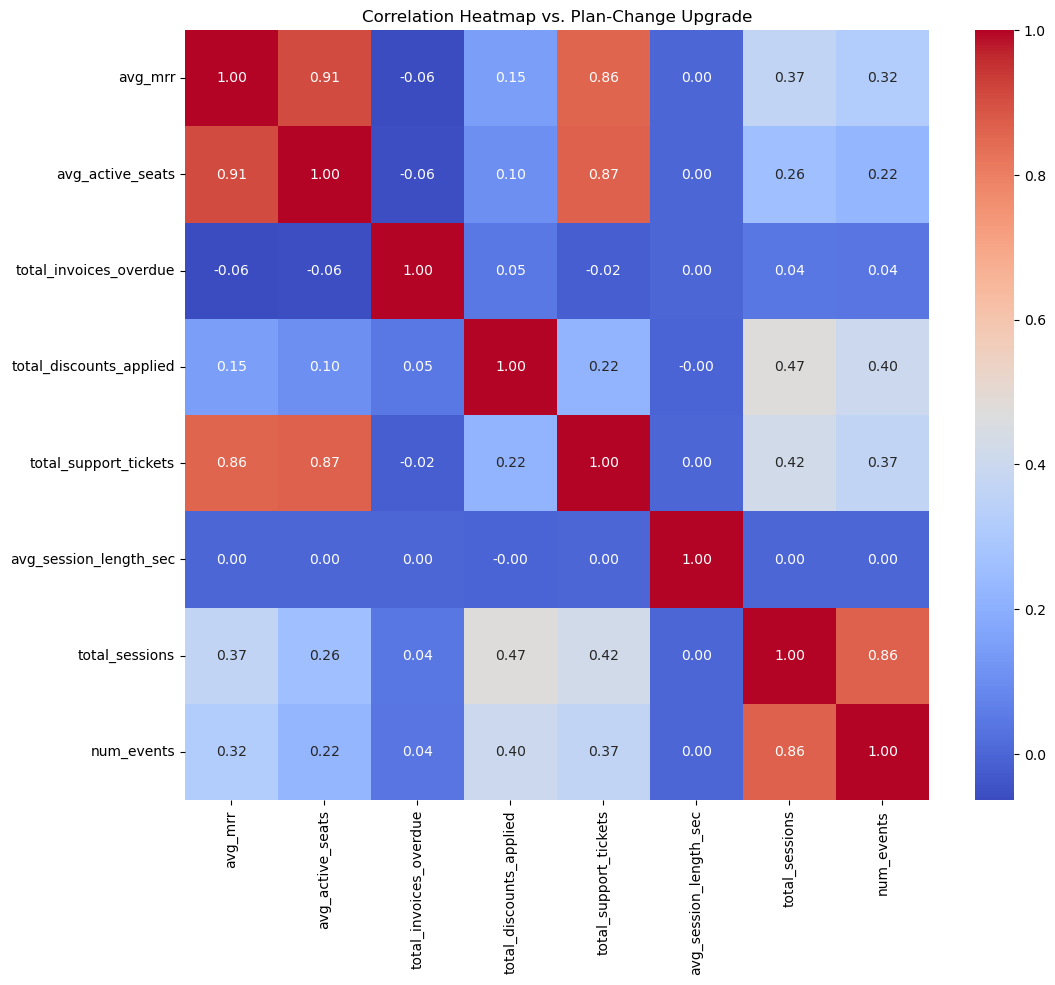

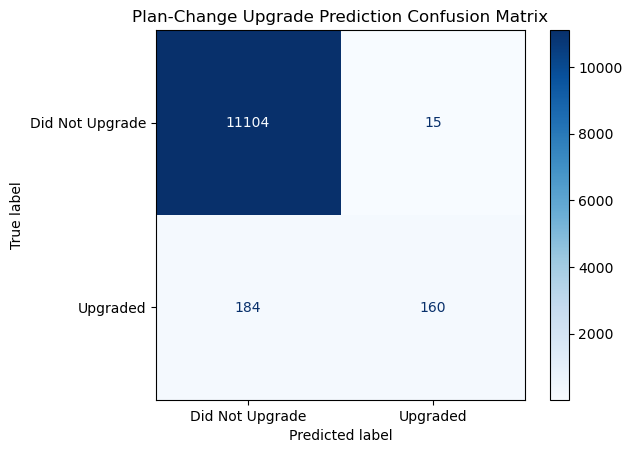

In [154]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Load All Data ---
try:
    users_df = pd.read_csv('users.csv')
    billing_df = pd.read_csv('billing.csv')
    sessions_df = pd.read_csv('sessions.csv')
    events_df = pd.read_csv('events.csv')
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- 2. Define New Upgrade Target (Based on Plan Change) ---
print("Identifying users who upgraded based on plan changes...")
billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

def detect_plan_upgrade(plans):
    """Checks for specific plan transitions in a user's history."""
    plans_tuple = tuple(plans)
    upgraded_from_free = ('free', 'standard') in zip(plans_tuple, plans_tuple[1:]) or \
                         ('free', 'premium') in zip(plans_tuple, plans_tuple[1:])
    upgraded_from_standard = ('standard', 'premium') in zip(plans_tuple, plans_tuple[1:])
    return pd.Series([upgraded_from_free, upgraded_from_standard])

# Group by user, apply the function, and then unstack the multi-level index into columns
upgrade_flags = billing_df.groupby('user_id')['plan_tier'].apply(detect_plan_upgrade).unstack()
upgrade_flags.columns = ['upgraded_from_free', 'upgraded_from_standard']

# Reset the index to turn 'user_id' from an index into a column
upgrade_flags = upgrade_flags.reset_index()

# The final target is if a user made ANY of these upgrades
upgrade_flags['has_upgraded'] = upgrade_flags['upgraded_from_free'] | upgrade_flags['upgraded_from_standard']
upgrade_target_df = upgrade_flags[['user_id', 'has_upgraded']]


# --- 3. Deep Dive on "Free to Paid" Upgraders ---
print("\n--- Analyzing 'Free to Paid' Upgraders ---")
# Need to merge back to get the 'upgraded_from_free' flag
free_to_paid_user_ids = upgrade_flags[upgrade_flags['upgraded_from_free']]['user_id']
free_to_paid_df = pd.merge(users_df, pd.DataFrame(free_to_paid_user_ids), on='user_id', how='inner')

# a) Calculate time to upgrade
if not free_to_paid_df.empty:
    first_paid_month = billing_df[billing_df['plan_tier'] != 'free'].groupby('user_id')['month'].min().reset_index()
    first_paid_month.rename(columns={'month': 'first_paid_month'}, inplace=True)
    time_to_upgrade_df = pd.merge(free_to_paid_df, first_paid_month, on='user_id')
    time_to_upgrade_df['signup_date'] = pd.to_datetime(time_to_upgrade_df['signup_date'])
    time_to_upgrade_df['months_to_upgrade'] = (time_to_upgrade_df['first_paid_month'].dt.to_period('M') - \
                                            time_to_upgrade_df['signup_date'].dt.to_period('M')).apply(lambda x: x.n)

    print(f"\nAverage time for a free user to upgrade: {time_to_upgrade_df['months_to_upgrade'].mean():.2f} months")

    
    # b) Visualize Demographics with Pie Charts
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Demographic Profile of Companies Upgrading from Free to Paid', fontsize=18)
    # Company Size
    company_size_counts = free_to_paid_df['company_size'].value_counts()
    axes[0].pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
    axes[0].set_title('Company Size', fontsize=14)
    
    # Industry (with custom coloring)
    industry_counts = free_to_paid_df['industry'].value_counts()
    # Define custom colors: 3 shades of blue for the top 3, grey for the rest
    colors = ['#00008B', '#0000CD', '#4169E1'] + ['#A9A9A9'] * (len(industry_counts) - 3)
    axes[1].pie(industry_counts, labels=industry_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
    axes[1].set_title('Top Industries of Upgrading Companies', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('free_to_paid_demographics.png')
    print("Demographic pie charts for 'Free to Paid' upgraders saved as 'free_to_paid_demographics.png'")
else:
    print("No users found who upgraded from a free plan.")

# --- 4. Aggregate Data for the Model ---
print("\nAggregating all user data for the prediction model...")
billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

sessions_agg = sessions_df.groupby('user_id').agg(
    total_sessions=('session_id', 'count'),
    avg_session_length_sec=('session_length_sec', 'mean')
).reset_index()

events_agg = events_df.groupby('user_id').agg(num_events=('event_id', 'count')).reset_index()

# --- 5. Merge, Preprocess, and Build Model ---
print("Building and evaluating the Random Forest model...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')
df = pd.merge(df, upgrade_target_df, on='user_id', how='left')

# Define target and features
TARGET = 'has_upgraded'
features = [
    'plan_tier', 'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_invoices_overdue', 'total_discounts_applied',
    'total_support_tickets', 'avg_session_length_sec', 'total_sessions', 'num_events'
]
model_df = df[features + [TARGET]].copy().dropna()

# Generate Correlation Heatmap
plt.figure(figsize=(12, 10))
numerical_features = model_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = model_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap vs. Plan-Change Upgrade')
plt.savefig('plan_upgrade_correlation_heatmap.png')
print("Correlation heatmap saved as 'plan_upgrade_correlation_heatmap.png'")

# Prepare data for model
model_df = pd.get_dummies(model_df, columns=model_df.select_dtypes(include=['object']).columns, drop_first=True)
X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train and Evaluate Model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

print("\n--- Model Evaluation (Predicting Plan-Change Upgrade) ---")
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Did Not Upgrade', 'Upgraded']))

# Generate and save confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Upgrade', 'Upgraded'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Plan-Change Upgrade Prediction Confusion Matrix')
plt.savefig('plan_upgrade_confusion_matrix.png')
print("Confusion matrix saved as 'plan_upgrade_confusion_matrix.png'")



Files loaded successfully!
Identifying users who upgraded based on plan changes...
user_id                               upgraded_from_free  upgraded_from_standard  has_upgraded
0000093e-7258-43c0-b212-ea7212795ddf  False               False                   False           1
aada0e17-1de5-46ca-a541-ff9bf97f58a8  False               False                   False           1
aaeac088-8e82-4e18-959a-193c495464c9  False               False                   False           1
aaea3c6b-b509-4b73-8bb4-586258ea0de7  False               False                   False           1
aae9ff9e-9280-41d8-bb4a-84390d36ebeb  False               False                   False           1
                                                                                                 ..
556f1b9c-618a-41f0-a898-4d94fa635d78  False               False                   False           1
556e758d-f700-4f10-9a01-462b7eaf653e  False               False                   False           1
556d4ff1-5238-41dc-847

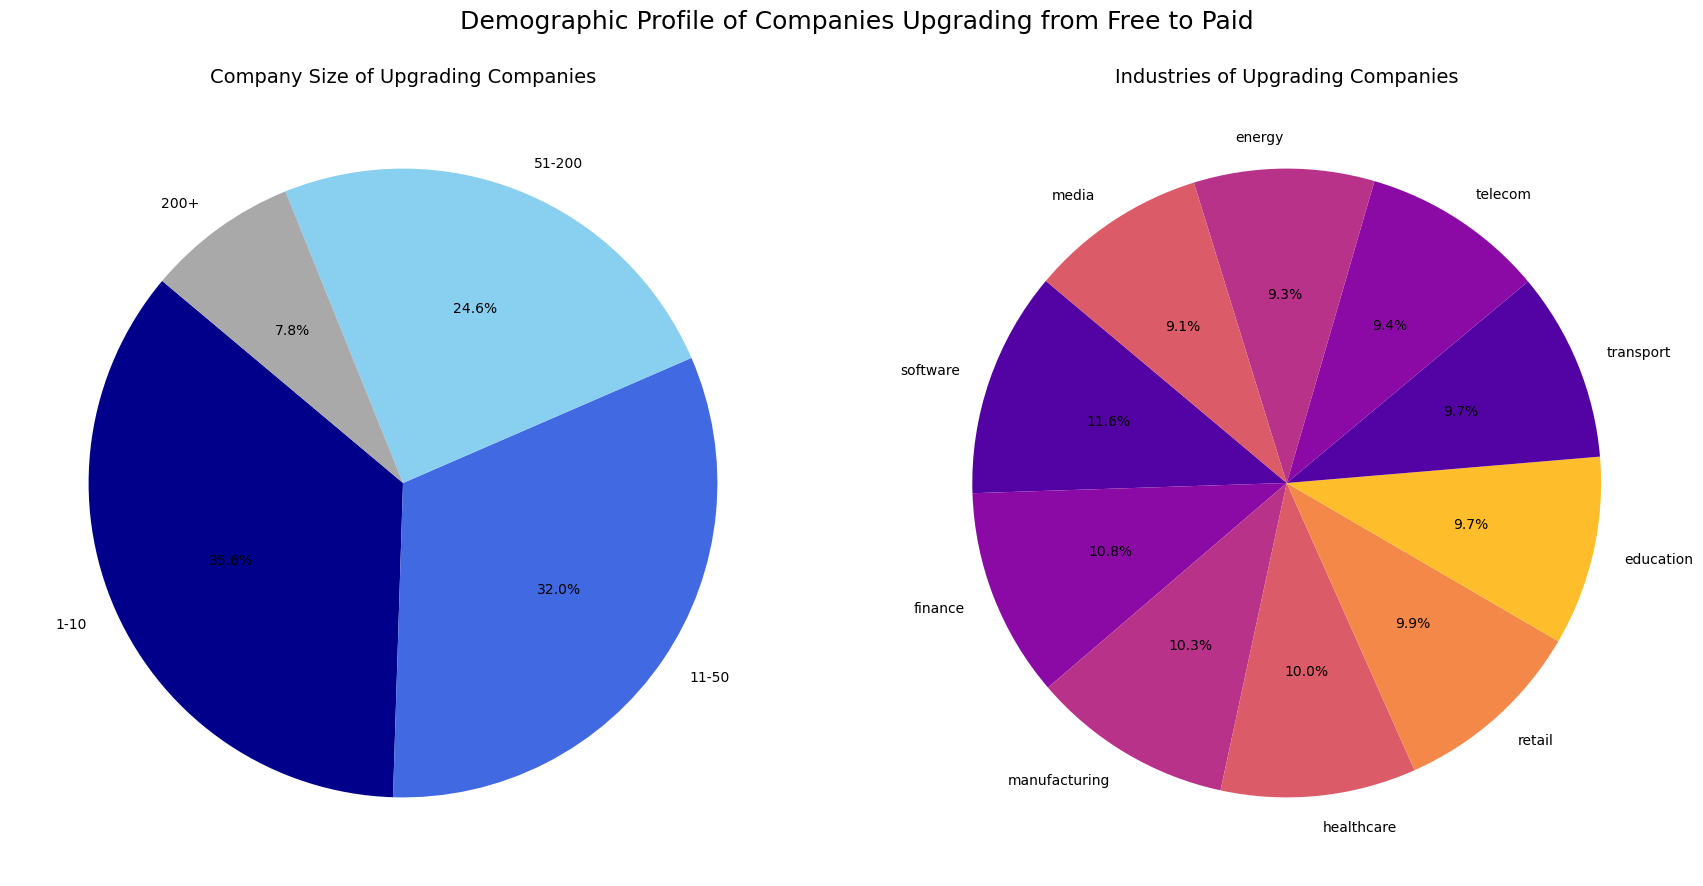

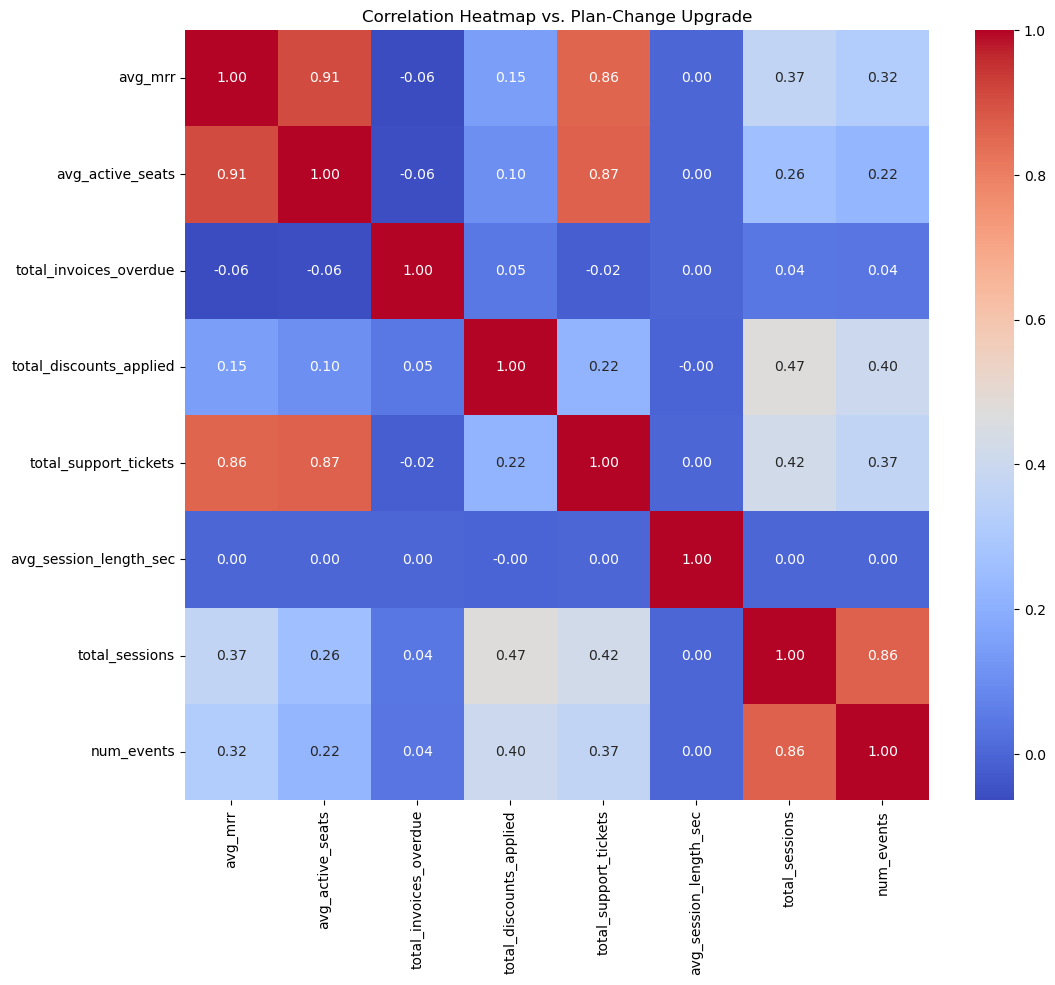

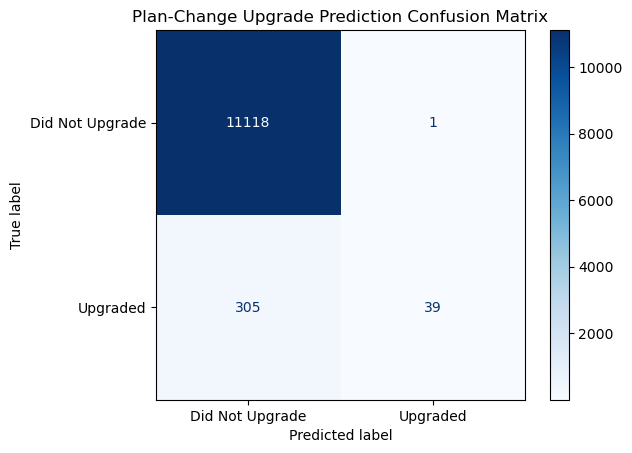

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Load All Data ---
try:
    users_df = pd.read_csv('users.csv')
    billing_df = pd.read_csv('billing.csv')
    sessions_df = pd.read_csv('sessions.csv')
    events_df = pd.read_csv('events.csv')
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- 2. Define New Upgrade Target (Based on Plan Change) ---
print("Identifying users who upgraded based on plan changes...")
billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

def detect_plan_upgrade(plans):
    """Checks for specific plan transitions in a user's history."""
    plans_tuple = tuple(plans)
    upgraded_from_free = ('free', 'standard') in zip(plans_tuple, plans_tuple[1:]) or \
                         ('free', 'premium') in zip(plans_tuple, plans_tuple[1:])
    upgraded_from_standard = ('standard', 'premium') in zip(plans_tuple, plans_tuple[1:])
    return pd.Series([upgraded_from_free, upgraded_from_standard])

# Group by user, apply the function, and then unstack the multi-level index into columns
upgrade_flags = billing_df.groupby('user_id')['plan_tier'].apply(detect_plan_upgrade).unstack()
upgrade_flags.columns = ['upgraded_from_free', 'upgraded_from_standard']

# Reset the index to turn 'user_id' from an index into a column
upgrade_flags = upgrade_flags.reset_index()

# The final target is if a user made ANY of these upgrades
upgrade_flags['has_upgraded'] = upgrade_flags['upgraded_from_free'] | upgrade_flags['upgraded_from_standard']
upgrade_target_df = upgrade_flags[['user_id', 'has_upgraded']]

print(upgrade_flags.value_counts())

# --- 3. Deep Dive on "Free to Paid" Upgraders ---
print("\n--- Analyzing 'Free to Paid' Upgraders ---")
# Need to merge back to get the 'upgraded_from_free' flag
free_to_paid_user_ids = upgrade_flags[upgrade_flags['upgraded_from_free']]['user_id']
free_to_paid_df = pd.merge(users_df, pd.DataFrame(free_to_paid_user_ids), on='user_id', how='inner')

# a) Calculate time to upgrade
if not free_to_paid_df.empty:
    first_paid_month = billing_df[billing_df['plan_tier'] != 'free'].groupby('user_id')['month'].min().reset_index()
    first_paid_month.rename(columns={'month': 'first_paid_month'}, inplace=True)
    time_to_upgrade_df = pd.merge(free_to_paid_df, first_paid_month, on='user_id')
    time_to_upgrade_df['signup_date'] = pd.to_datetime(time_to_upgrade_df['signup_date'])
    time_to_upgrade_df['months_to_upgrade'] = (time_to_upgrade_df['first_paid_month'].dt.to_period('M') - \
                                            time_to_upgrade_df['signup_date'].dt.to_period('M')).apply(lambda x: x.n)

    print(f"\nAverage time for a free user to upgrade: {time_to_upgrade_df['months_to_upgrade'].mean():.2f} months")

    
    # b) Visualize Demographics with Pie Charts
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    fig.suptitle('Demographic Profile of Companies Upgrading from Free to Paid', fontsize=18)
    
    # Pie Chart 1: Company Size (with custom coloring)
    company_size_counts = free_to_paid_df['company_size'].value_counts()
    # Define custom colors: 3 shades of blue for the top 3, grey for the rest
    colors = ['#00008B', '#4169E1', '#89CFF0'] + ['#A9A9A9'] * (len(company_size_counts) - 3)
    axes[0].pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
    axes[0].set_title('Company Size of Upgrading Companies', fontsize=14)
    
    # Pie Chart 2: Industry
    industry_counts = free_to_paid_df['industry'].value_counts()
    axes[1].pie(industry_counts, labels=industry_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('plasma'))
    axes[1].set_title('Industries of Upgrading Companies', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('free_to_paid_demographics.png')
    print("Demographic pie charts for 'Free to Paid' upgraders saved as 'free_to_paid_demographics.png'")
else:
    print("No users found who upgraded from a free plan.")


# --- 4. Aggregate Data for the Model ---
print("\nAggregating all user data for the prediction model...")
billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

sessions_agg = sessions_df.groupby('user_id').agg(
    total_sessions=('session_id', 'count'),
    avg_session_length_sec=('session_length_sec', 'mean')
).reset_index()

events_agg = events_df.groupby('user_id').agg(num_events=('event_id', 'count')).reset_index()

# --- 5. Merge, Preprocess, and Build Model ---
print("Building and evaluating the Random Forest model...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, events_agg, on='user_id', how='left')
df = pd.merge(df, upgrade_target_df, on='user_id', how='left')

# Define target and features
TARGET = 'has_upgraded'
features = [
    'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_invoices_overdue', 'total_discounts_applied',
    'total_support_tickets', 'avg_session_length_sec', 'total_sessions', 'num_events'
]
model_df = df[features + [TARGET]].copy().dropna()

# Generate Correlation Heatmap
plt.figure(figsize=(12, 10))
numerical_features = model_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = model_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap vs. Plan-Change Upgrade')
plt.savefig('plan_upgrade_correlation_heatmap.png')
print("Correlation heatmap saved as 'plan_upgrade_correlation_heatmap.png'")

# Prepare data for model
model_df = pd.get_dummies(model_df, columns=model_df.select_dtypes(include=['object']).columns, drop_first=True)
X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train and Evaluate Model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

print("\n--- Model Evaluation (Predicting Plan-Change Upgrade) ---")
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Did Not Upgrade', 'Upgraded']))

# Generate and save confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Upgrade', 'Upgraded'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Plan-Change Upgrade Prediction Confusion Matrix')
plt.savefig('plan_upgrade_confusion_matrix.png')
print("Confusion matrix saved as 'plan_upgrade_confusion_matrix.png'")

                 precision    recall  f1-score   support

Did Not Upgrade       0.99      0.98      0.99     19409
       Upgraded       0.57      0.69      0.63       591

       accuracy                           0.98     20000
      macro avg       0.78      0.84      0.81     20000
   weighted avg       0.98      0.98      0.98     20000



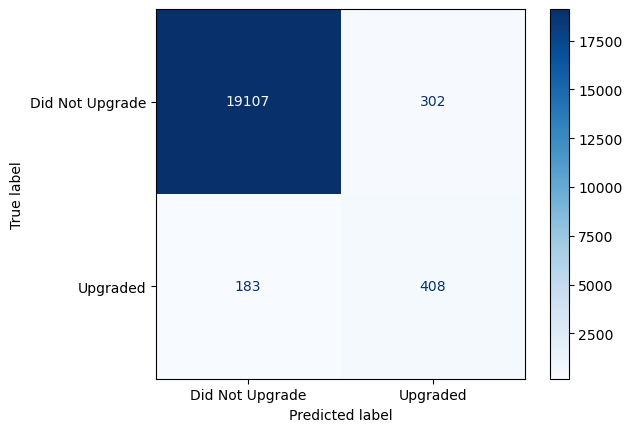

In [96]:
# Get the predicted probabilities for the 'Upgraded' class
y_probs = model.predict_proba(X_test)[:, 1]

# Set a new, lower threshold
new_threshold = 0.2
y_pred_new_threshold = (y_probs >= new_threshold).astype(int)

# See the new results
print(classification_report(y_test, y_pred_new_threshold, target_names=['Did Not Upgrade', 'Upgraded']))
# Generate and save confusion matrix for new threshold
cm = confusion_matrix(y_test, y_pred_new_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Upgrade', 'Upgraded'])
disp.plot(cmap=plt.cm.Blues)


--- Feature Importances ---
Top 20 most important features:
                                feature  importance
1                               avg_mrr    0.341300
16                    plan_tier_premium    0.061284
17                   plan_tier_standard    0.055251
13             feature_usage_jira_board    0.047089
8                            num_events    0.043615
7                        total_sessions    0.039451
14            feature_usage_team_invite    0.039133
4               total_discounts_applied    0.038849
12        feature_usage_jira_automation    0.036655
2                      avg_active_seats    0.032326
32              acquisition_channel_seo    0.026334
31          acquisition_channel_partner    0.026037
11        feature_usage_confluence_page    0.025098
9   feature_usage_bitbucket_integration    0.022443
6                avg_session_length_sec    0.019121
30         acquisition_channel_outbound    0.018145
10   feature_usage_confluence_ai_assist    0.017873
20 

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/3380185444.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')



Feature importance chart saved as 'feature_importances.png'


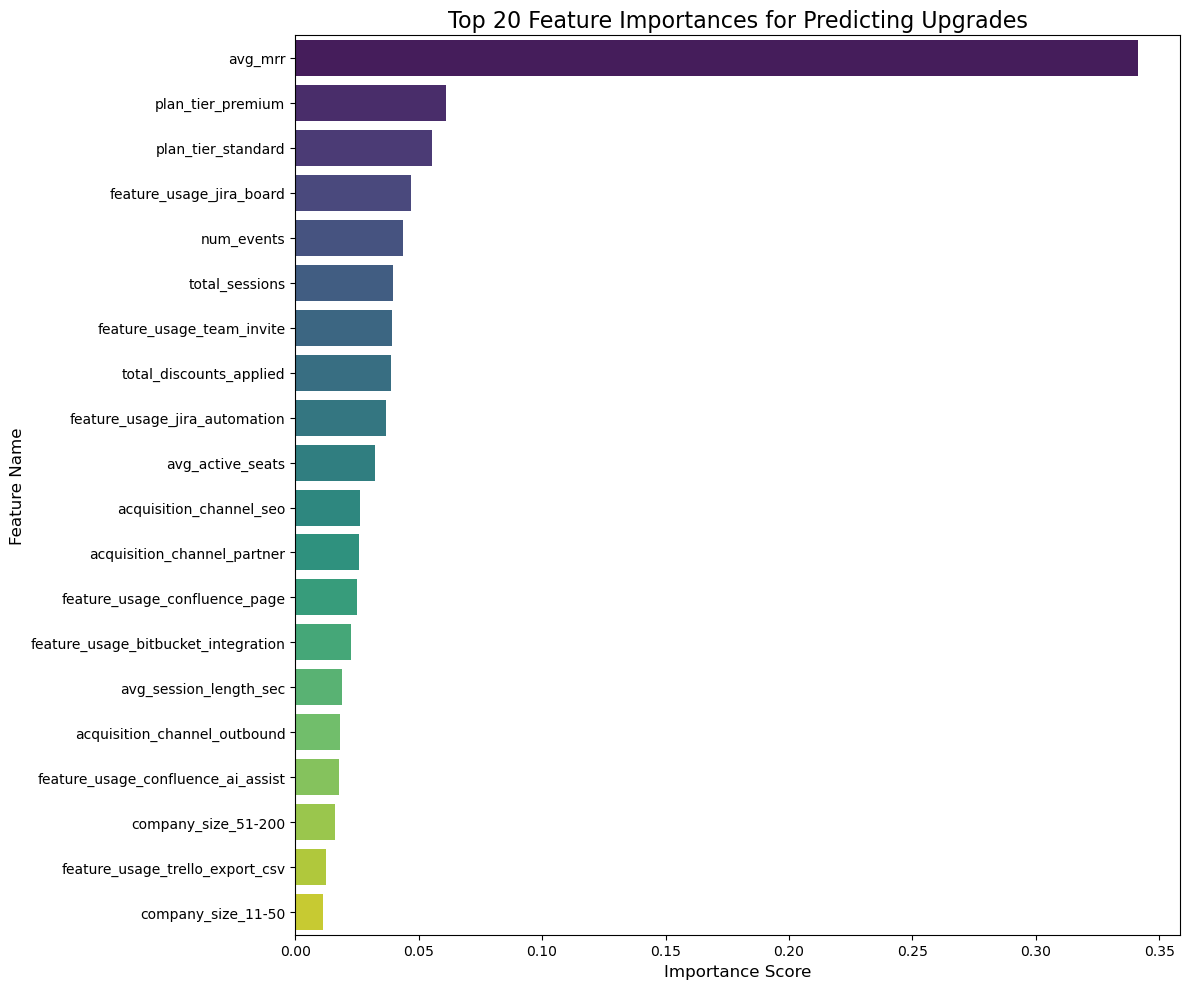

In [97]:
# --- ADD THIS SECTION to get and visualize feature importances ---

print("\n--- Feature Importances ---")

# Get feature importances from the trained model
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Get the top 20 most important features for readability
top_20_features = feature_importance_df.head(20)

print("Top 20 most important features:")
print(top_20_features)


# Visualize the top 20 feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importances for Predicting Upgrades', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importances.png')
print("\nFeature importance chart saved as 'feature_importances.png'")

Aggregating user data to create features...
Merging all data sources...
Preparing data for the XGBoost model...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2712970315.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_df[col].fillna(0, inplace=True)
/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2712970315.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

Training the XGBoost churn prediction model...

--- Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.86      0.55      0.67     15402
     Churned       0.32      0.71      0.44      4598

    accuracy                           0.59     20000
   macro avg       0.59      0.63      0.56     20000
weighted avg       0.74      0.59      0.62     20000


Confusion matrix saved as 'churn_prediction_confusion_matrix.png'

--- Feature Importances ---
Top 20 most important features for predicting churn:
                               feature  importance
15                   plan_tier_premium    0.300473
1                              avg_mrr    0.107991
16                  plan_tier_standard    0.048166
7                       total_sessions    0.030879
12            feature_usage_jira_board    0.028500
9   feature_usage_confluence_ai_assist    0.022942
18                   company_size_200+    0.020778
13           feature

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2712970315.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='rocket')



Feature importance chart saved as 'churn_feature_importances.png'


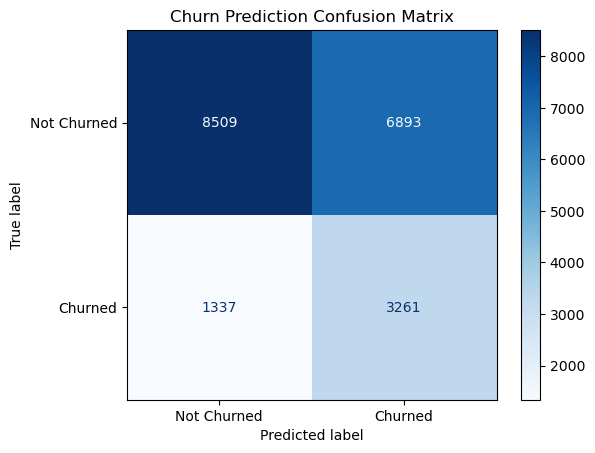

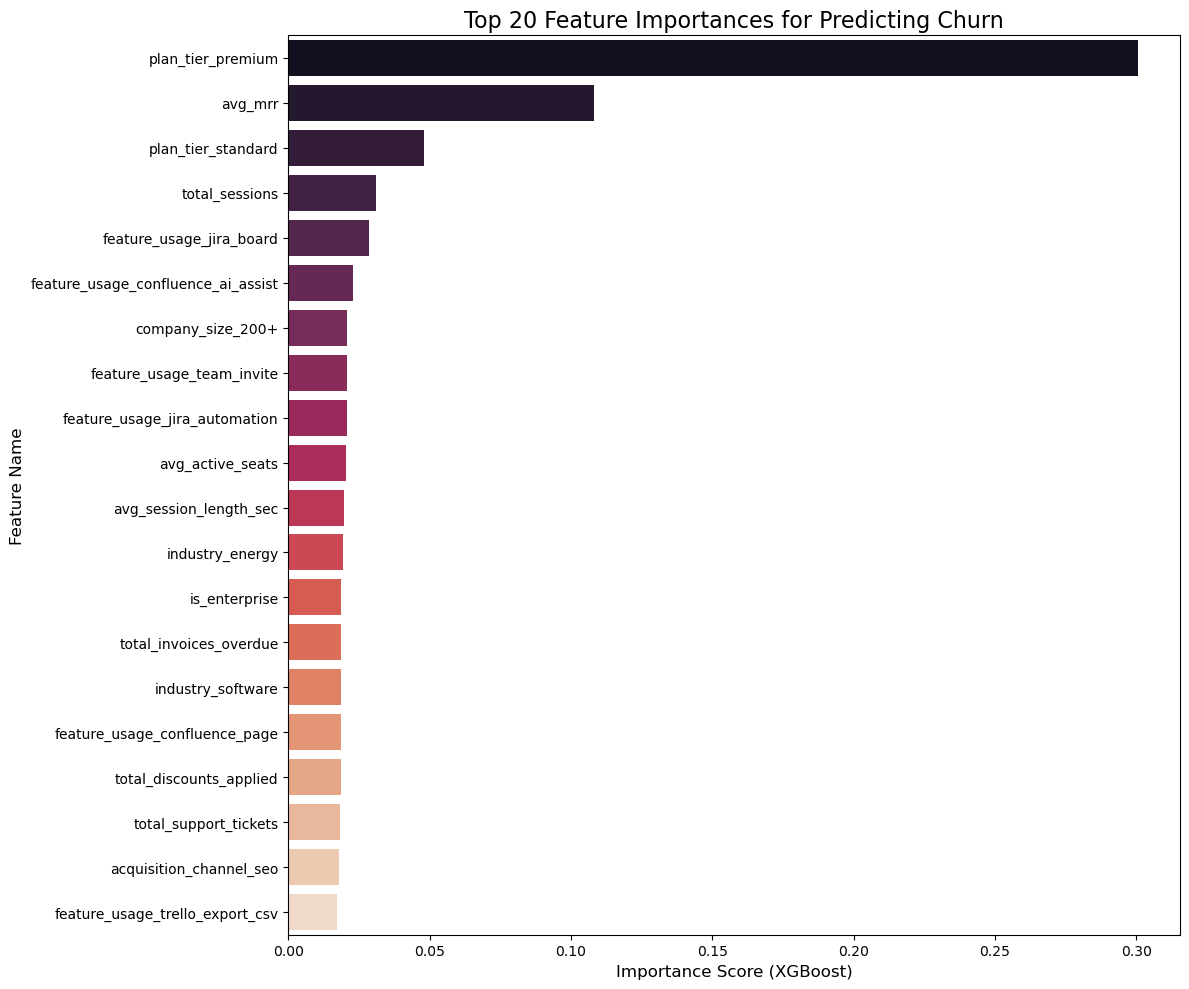

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb

# --- 2. Aggregate Data to User Level for Feature Engineering ---
print("Aggregating user data to create features...")

# a) Billing data aggregation
billing_agg = billing_df.groupby('user_id').agg(
    avg_mrr=('mrr', 'mean'),
    avg_active_seats=('active_seats', 'mean'),
    total_invoices_overdue=('invoices_overdue', 'sum'),
    total_discounts_applied=('discount_applied', 'sum'),
    total_support_tickets=('support_ticket_count', 'sum')
).reset_index()

# b) Session data aggregation
sessions_agg = sessions_df.groupby('user_id').agg(
    total_sessions=('session_id', 'count'),
    avg_session_length_sec=('session_length_sec', 'mean')
).reset_index()

# c) Event data aggregation (feature usage)
feature_counts = events_df.groupby(['user_id', 'feature_name']).size().unstack(fill_value=0)
feature_counts.columns = [f'feature_usage_{col.replace(" ", "_")}' for col in feature_counts.columns]
feature_counts.reset_index(inplace=True)

# --- 3. Merge All Data into a Single DataFrame ---
print("Merging all data sources...")
df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, feature_counts, on='user_id', how='left')

# --- 4. Prepare Data for Modeling ---
print("Preparing data for the XGBoost model...")

# Define target and features
TARGET = 'churned_90d'
base_features = [
    'plan_tier', 'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_invoices_overdue', 'total_discounts_applied',
    'total_support_tickets', 'avg_session_length_sec', 'total_sessions'
]
feature_usage_cols = [col for col in df.columns if col.startswith('feature_usage_')]
features = base_features + feature_usage_cols
model_df = df[features + [TARGET]].copy()

# Intelligent imputation to preserve data
for col in feature_usage_cols:
    model_df[col].fillna(0, inplace=True)
for col in model_df.select_dtypes(include=['float64', 'int64']).columns:
    if col != TARGET:
        model_df[col].fillna(model_df[col].median(), inplace=True)
for col in model_df.select_dtypes(include=['object']).columns:
    model_df[col].fillna(model_df[col].mode()[0], inplace=True)

# One-hot encode categorical variables
model_df = pd.get_dummies(model_df, columns=model_df.select_dtypes(include=['object']).columns, drop_first=True)

# --- 5. Train the XGBoost Model ---
print("Training the XGBoost churn prediction model...")

X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance for XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

# --- 6. Evaluate the Model ---
print("\n--- Model Evaluation ---")
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

# Generate and save confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Churn Prediction Confusion Matrix')
plt.savefig('churn_prediction_confusion_matrix.png')
print("\nConfusion matrix saved as 'churn_prediction_confusion_matrix.png'")

# --- 7. Analyze Feature Importance ---
print("\n--- Feature Importances ---")
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_20_features = feature_importance_df.head(20)

print("Top 20 most important features for predicting churn:")
print(top_20_features)

# Visualize the top 20 feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='rocket')
plt.title('Top 20 Feature Importances for Predicting Churn', fontsize=16)
plt.xlabel('Importance Score (XGBoost)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.tight_layout()
plt.savefig('churn_feature_importances.png')
print("\nFeature importance chart saved as 'churn_feature_importances.png'")


--- Generating Correlation Heatmap ---

Correlation heatmap saved as 'churn_correlation_heatmap.png'

Top features most correlated with churn:
churned_90d                            1.000000
total_sessions                         0.167500
plan_tier_premium                      0.166998
total_discounts_applied                0.142772
feature_usage_jira_board               0.139552
feature_usage_jira_automation          0.125074
plan_tier_standard                     0.122125
avg_mrr                                0.118538
feature_usage_team_invite              0.113426
avg_active_seats                       0.100551
total_support_tickets                  0.098530
feature_usage_bitbucket_integration    0.097325
feature_usage_confluence_page          0.093748
feature_usage_confluence_ai_assist     0.086882
is_enterprise                          0.073272
Name: churned_90d, dtype: float64


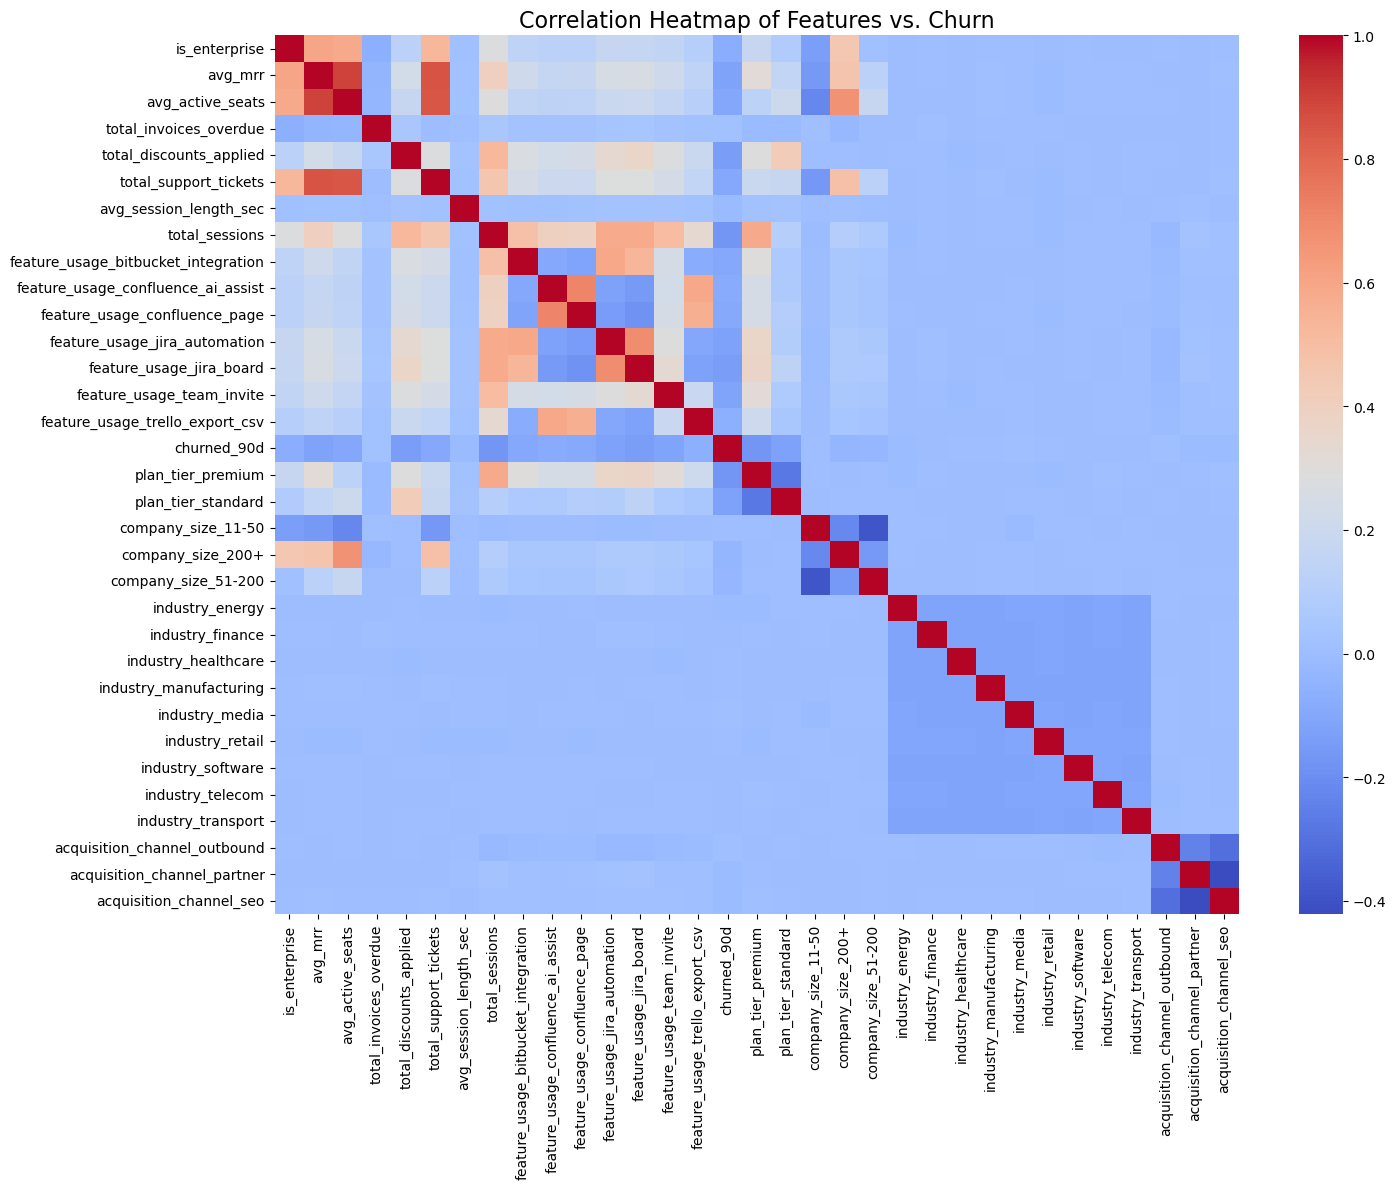

In [102]:

# One-hot encode categorical variables
model_df_encoded = pd.get_dummies(model_df, columns=model_df.select_dtypes(include=['object']).columns, drop_first=True)

# --- 4.5 Generate Correlation Heatmap ---
print("\n--- Generating Correlation Heatmap ---")
plt.figure(figsize=(15, 12))
# Select all numerical features from the encoded dataframe for the heatmap
numerical_features = model_df_encoded.select_dtypes(include=['float64', 'int64', 'int32', 'uint8', 'bool']).columns
correlation_matrix = model_df_encoded[numerical_features].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features vs. Churn', fontsize=16)
plt.tight_layout()
plt.savefig('churn_correlation_heatmap.png')
print("\nCorrelation heatmap saved as 'churn_correlation_heatmap.png'")

# Print the top correlations with the target variable
print("\nTop features most correlated with churn:")
print(correlation_matrix[TARGET].abs().sort_values(ascending=False).head(15))


Merging user and event data...
Analyzing and visualizing feature usage...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/4243054074.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, ax=ax, palette='mako')
/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/4243054074.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, ax=ax, palette='mako')
/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/4243054074.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y


Feature usage analysis chart saved as 'feature_usage_by_plan_tier.png'


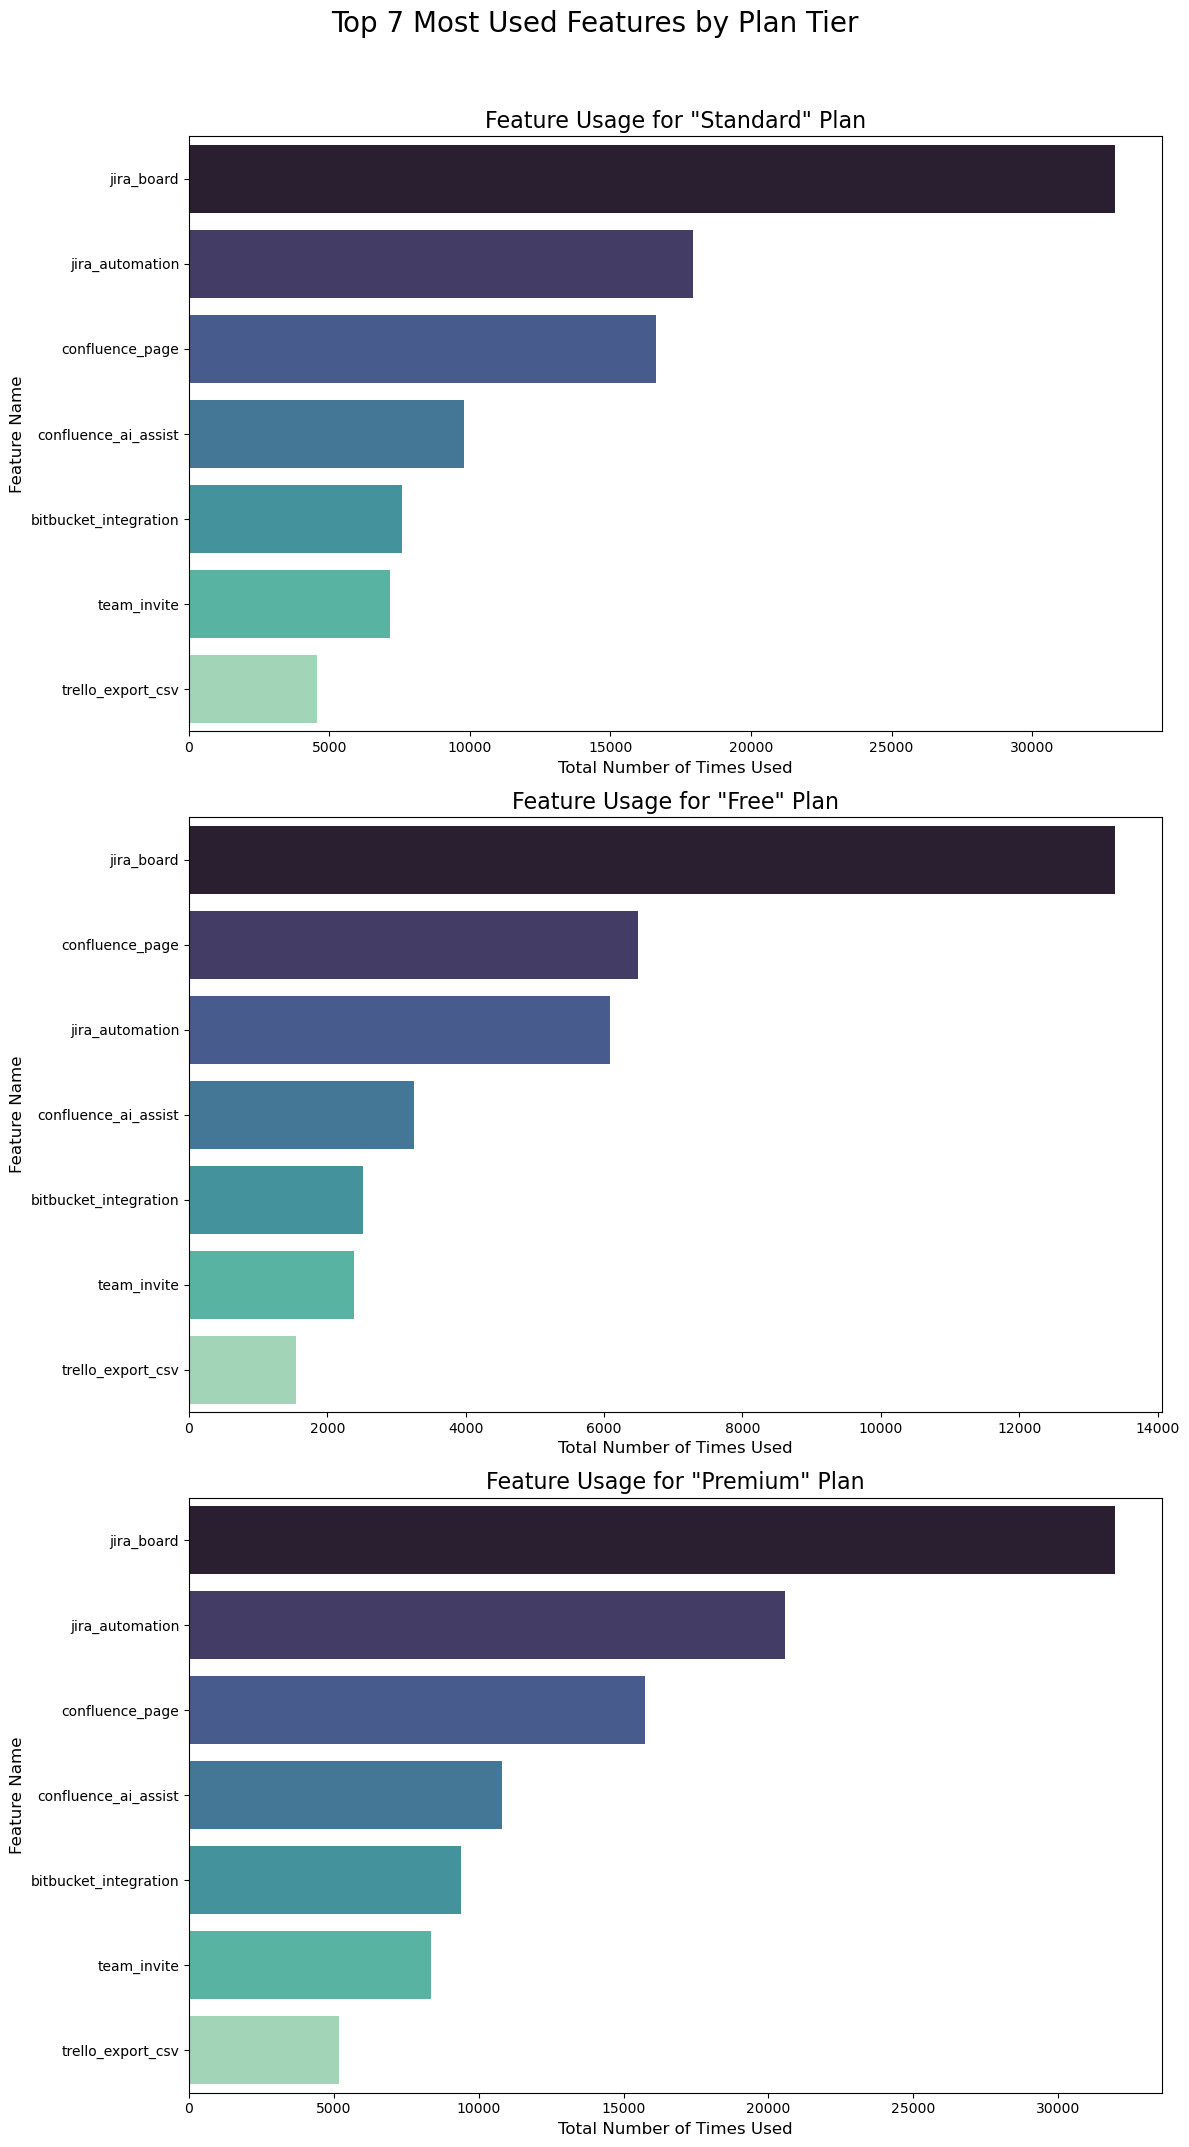

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# --- 2. Merge Data to Link Features with Plan Tiers ---
print("Merging user and event data...")
# We need the most recent plan tier for each user.
# We'll get this from the 'users.csv' file, assuming it's the most current record.
user_plan_df = users_df[['user_id', 'plan_tier']].drop_duplicates(subset='user_id')
merged_df = pd.merge(events_df, user_plan_df, on='user_id', how='left')

# Drop any events from users we couldn't map to a plan
merged_df.dropna(subset=['plan_tier'], inplace=True)


# --- 3. Analyze and Visualize Feature Usage for Each Plan Tier ---
print("Analyzing and visualizing feature usage...")

# Get the unique plan tiers from the data
plan_tiers = merged_df['plan_tier'].unique()

# Create a figure to hold all the subplots
fig, axes = plt.subplots(len(plan_tiers), 1, figsize=(12, 7 * len(plan_tiers)))
fig.suptitle('Top 7 Most Used Features by Plan Tier', fontsize=20, y=1.02)

# Ensure axes is always a list for consistent indexing
if len(plan_tiers) == 1:
    axes = [axes]

for i, plan in enumerate(plan_tiers):
    ax = axes[i]
    
    # Filter data for the current plan tier
    plan_df = merged_df[merged_df['plan_tier'] == plan]
    
    # Get the top 7 most frequent features
    top_features = plan_df['feature_name'].value_counts().nlargest(7)
    
    # Generate the bar plot
    sns.barplot(x=top_features.values, y=top_features.index, ax=ax, palette='mako')
    
    ax.set_title(f'Feature Usage for "{plan.title()}" Plan', fontsize=16)
    ax.set_xlabel('Total Number of Times Used', fontsize=12)
    ax.set_ylabel('Feature Name', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('feature_usage_by_plan_tier.png')
print("\nFeature usage analysis chart saved as 'feature_usage_by_plan_tier.png'")

Merging user and event data...
Analyzing feature usage...
Generating combined visualization...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2874328979.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_features_per_plan = feature_counts.groupby('plan_tier').apply(



Combined feature usage analysis chart saved as 'combined_feature_usage_by_plan.png'


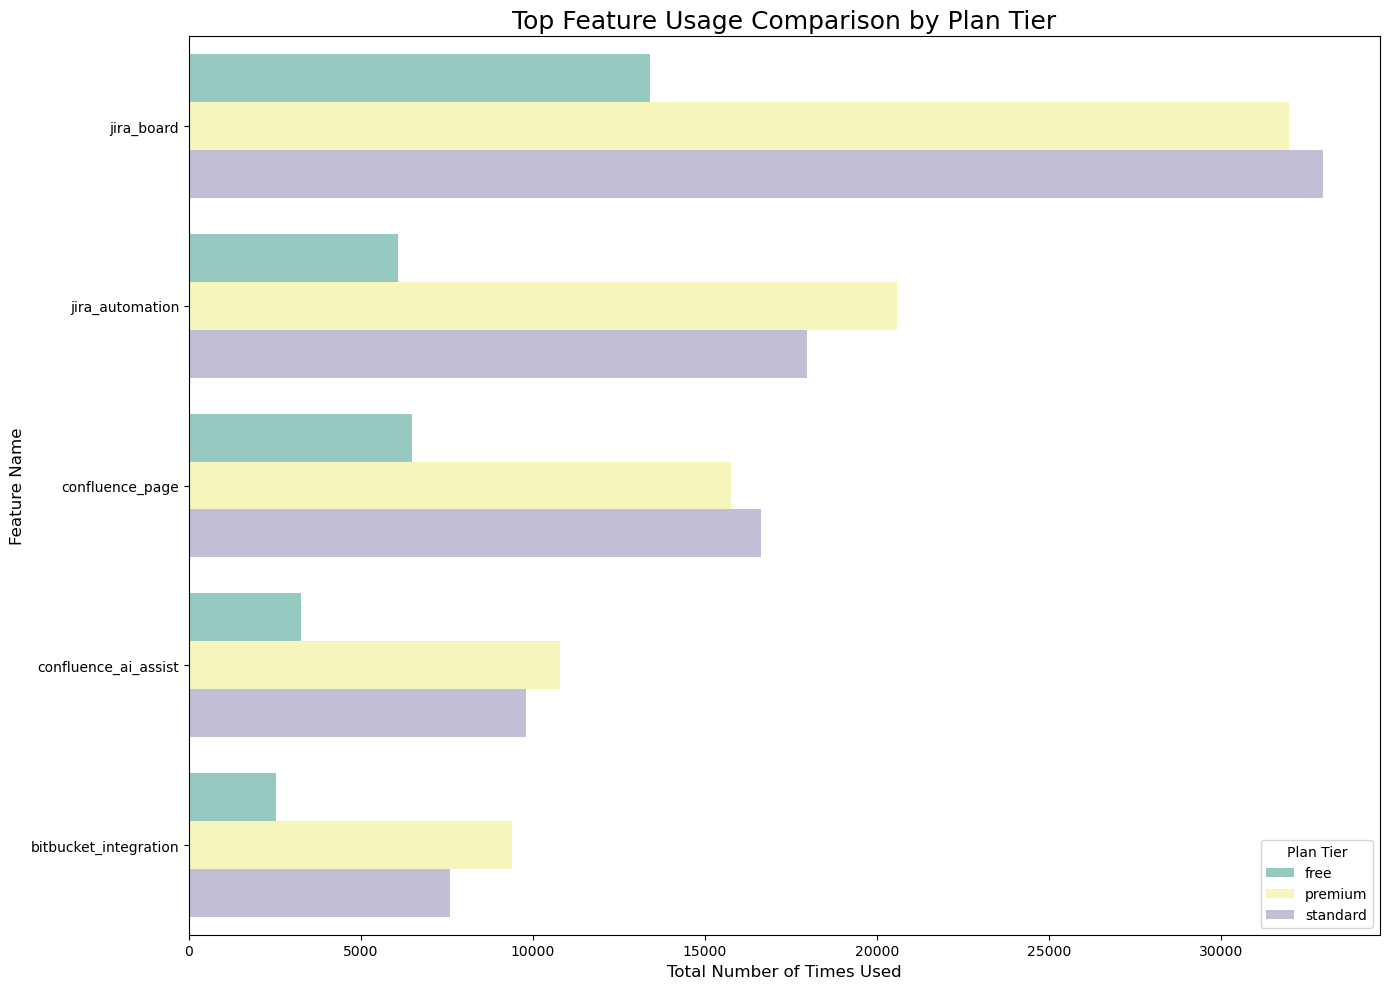

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# --- 2. Merge Data to Link Features with Plan Tiers ---
print("Merging user and event data...")
user_plan_df = users_df[['user_id', 'plan_tier']].drop_duplicates(subset='user_id')
merged_df = pd.merge(events_df, user_plan_df, on='user_id', how='left')
merged_df.dropna(subset=['plan_tier'], inplace=True)


# --- 3. Find the Top Features for Each Plan ---
print("Analyzing feature usage...")
# Calculate the total usage counts for every feature within each plan
feature_counts = merged_df.groupby(['plan_tier', 'feature_name']).size().reset_index(name='usage_count')

# Find the top 5 features for each plan
top_features_per_plan = feature_counts.groupby('plan_tier').apply(
    lambda x: x.nlargest(5, 'usage_count')
).reset_index(drop=True)

# Get a unique list of all top features across all plans
all_top_features = top_features_per_plan['feature_name'].unique()

# Filter the original counts to only include these top features
plot_data = feature_counts[feature_counts['feature_name'].isin(all_top_features)]


# --- 4. Create the Combined Visualization ---
print("Generating combined visualization...")
plt.figure(figsize=(14, 10))
sns.barplot(
    data=plot_data,
    x='usage_count',
    y='feature_name',
    hue='plan_tier',
    palette='Set3',
    order=plot_data.groupby('feature_name')['usage_count'].sum().sort_values(ascending=False).index # Order by total usage
)

plt.title('Top Feature Usage Comparison by Plan Tier', fontsize=18)
plt.xlabel('Total Number of Times Used', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.legend(title='Plan Tier')
plt.tight_layout()
plt.savefig('combined_feature_usage_by_plan.png')
print("\nCombined feature usage analysis chart saved as 'combined_feature_usage_by_plan.png'")

Merging user and event data...
Analyzing feature usage by company size and plan...
Generating faceted visualization...

Faceted feature usage analysis chart saved as 'faceted_feature_usage_by_company.png'


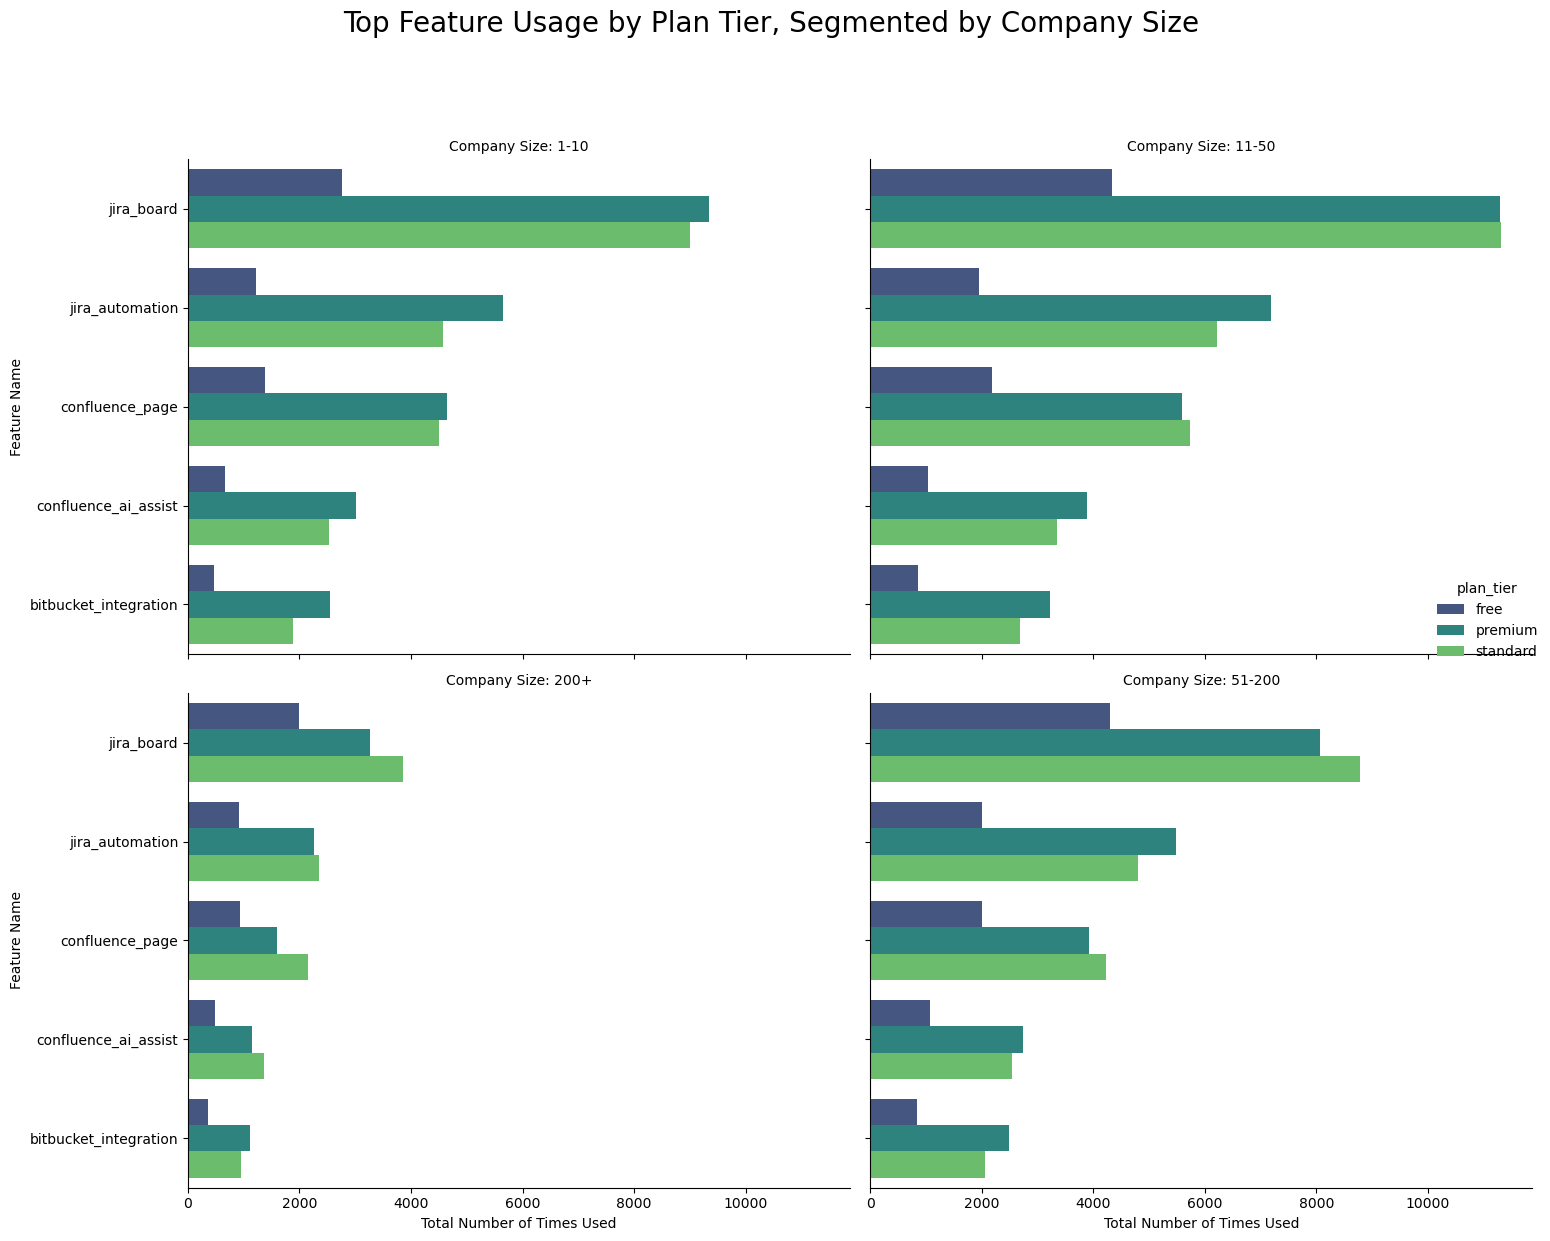

In [127]:
# --- 2. Merge Data to Link Features with Company Info ---
print("Merging user and event data...")
# Select both plan_tier and company_size from the users file
company_info_df = users_df[['user_id', 'plan_tier', 'company_size']].drop_duplicates(subset='user_id')
merged_df = pd.merge(events_df, company_info_df, on='user_id', how='left')
merged_df.dropna(subset=['plan_tier', 'company_size'], inplace=True)


# --- 3. Analyze Feature Usage by Segment ---
print("Analyzing feature usage by company size and plan...")
# Calculate usage counts for every feature, grouped by both company size and plan tier
feature_counts = merged_df.groupby(['company_size', 'plan_tier', 'feature_name']).size().reset_index(name='usage_count')

# To keep the chart readable and comparable, let's find the top 5 features overall
overall_top_features = merged_df['feature_name'].value_counts().nlargest(5).index

# Filter our data to only include these top features
plot_data = feature_counts[feature_counts['feature_name'].isin(overall_top_features)]


# --- 4. Create the Combined, Faceted Visualization ---
print("Generating faceted visualization...")
# Use seaborn's catplot to create a grid of plots (facets) for each company size
g = sns.catplot(
    data=plot_data,
    x='usage_count',
    y='feature_name',
    hue='plan_tier',
    col='company_size',  # This creates a separate column of charts for each company size
    kind='bar',
    palette='viridis',
    height=6,
    aspect=1.2,
    col_wrap=2,          # Wrap the charts onto the next row after 2 plots
    order=overall_top_features  # Ensures a consistent y-axis order across all charts
)

g.fig.suptitle('Top Feature Usage by Plan Tier, Segmented by Company Size', fontsize=20, y=1.03)
g.set_axis_labels('Total Number of Times Used', 'Feature Name')
g.set_titles("Company Size: {col_name}")
g.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig('faceted_feature_usage_by_company.png')
print("\nFaceted feature usage analysis chart saved as 'faceted_feature_usage_by_company.png'")

Merging user and event data...
Analyzing feature usage by industry and plan...
Generating faceted visualization...

Faceted feature usage analysis chart saved as 'faceted_feature_usage_by_industry.png'


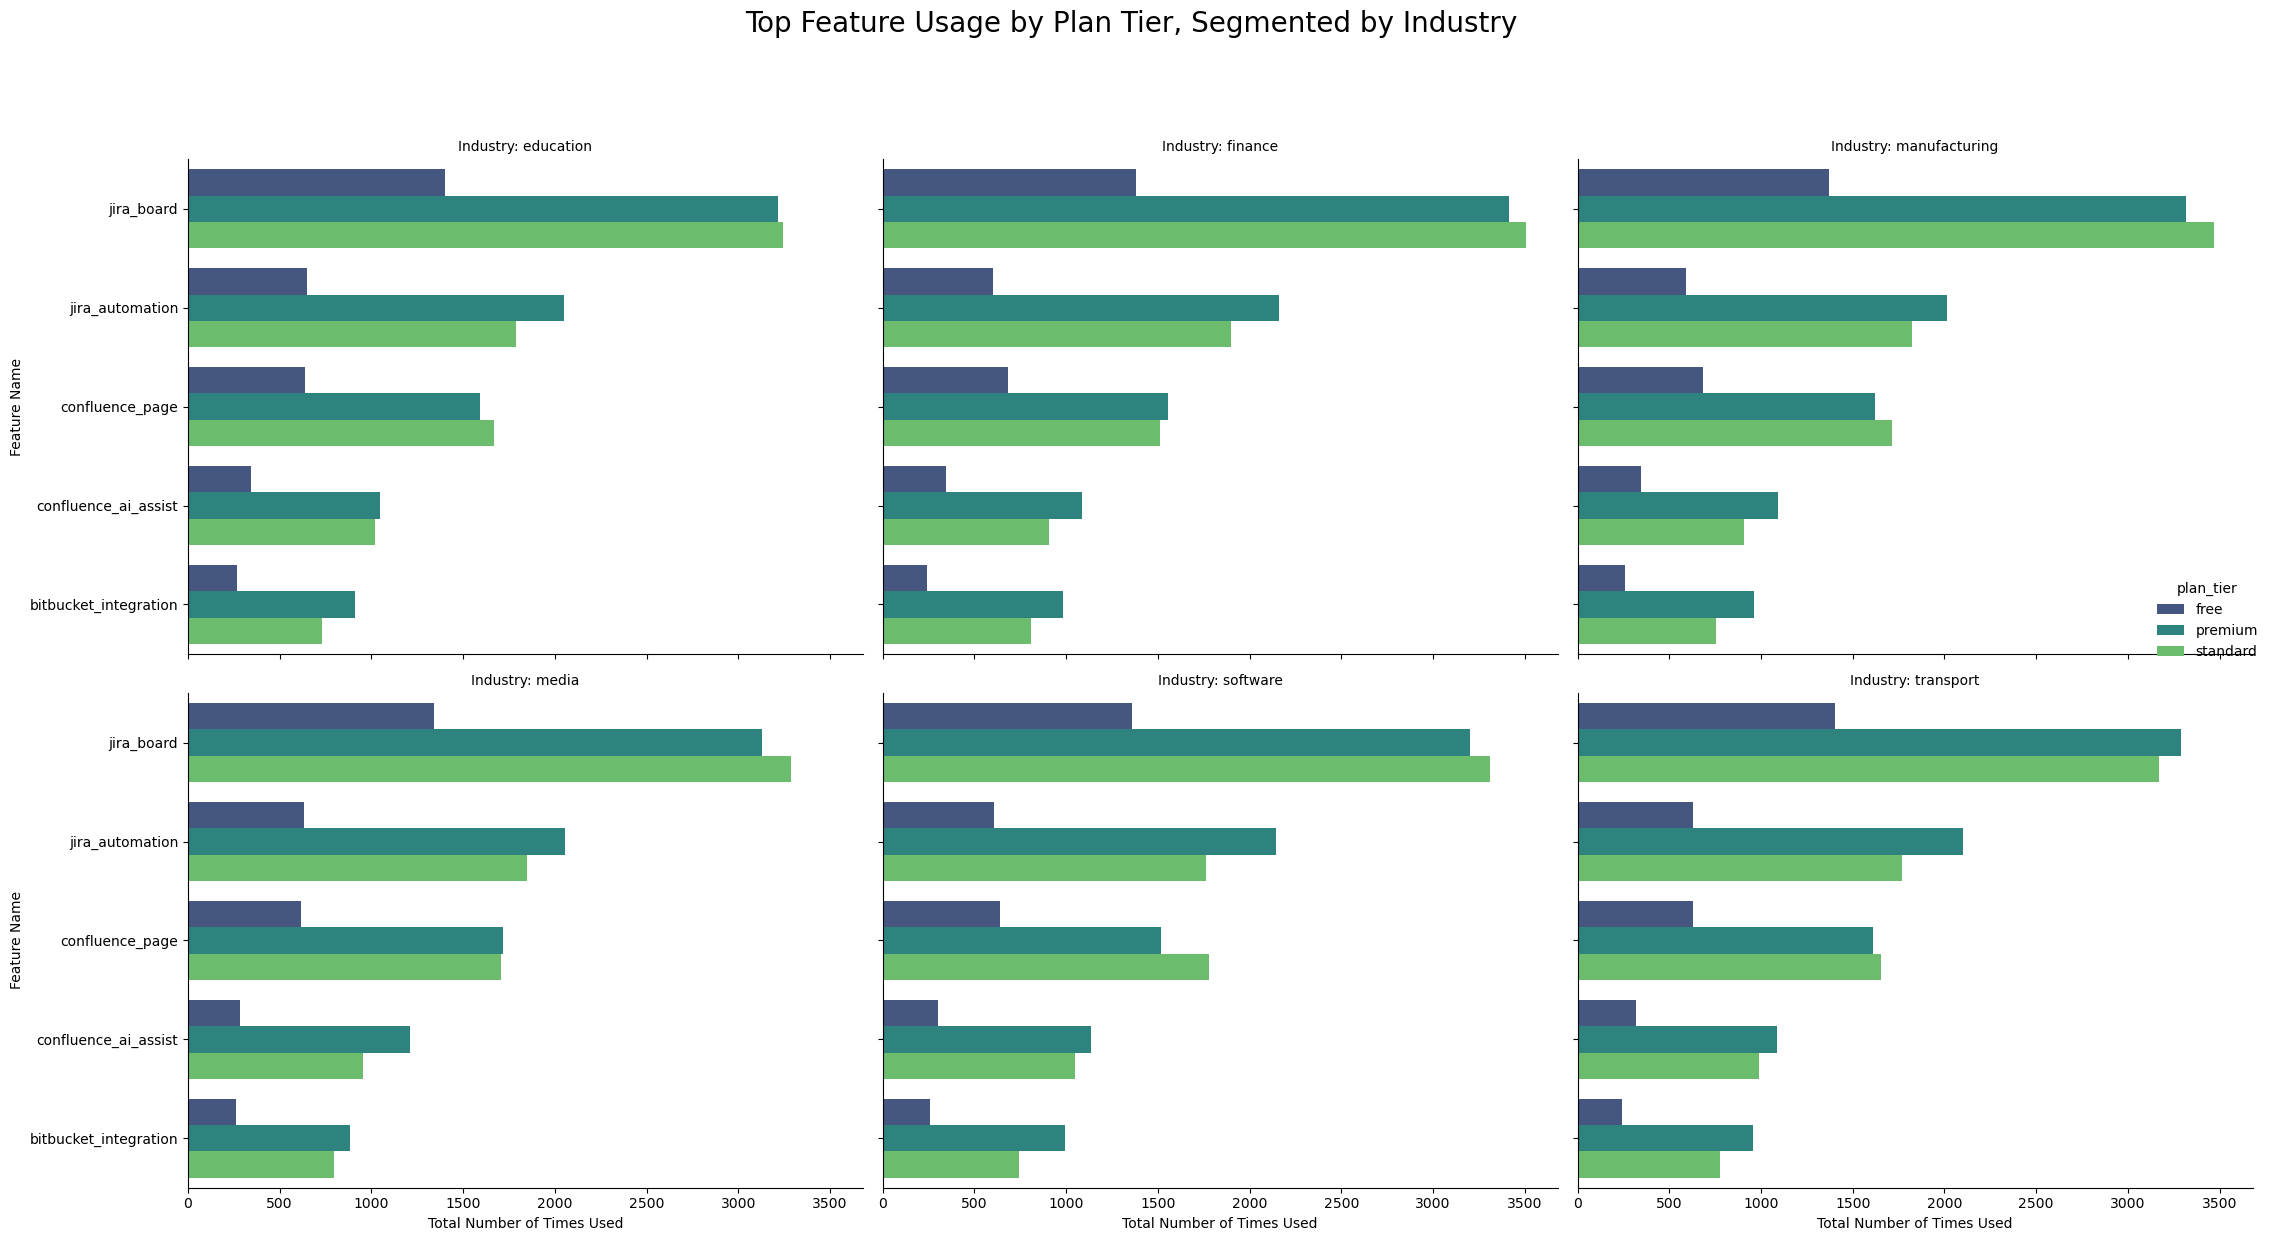

In [128]:
# --- 2. Merge Data to Link Features with Company Info ---
print("Merging user and event data...")
# Select both plan_tier and industry from the users file
company_info_df = users_df[['user_id', 'plan_tier', 'industry']].drop_duplicates(subset='user_id')
merged_df = pd.merge(events_df, company_info_df, on='user_id', how='left')
merged_df.dropna(subset=['plan_tier', 'industry'], inplace=True)


# --- 3. Analyze Feature Usage by Segment ---
print("Analyzing feature usage by industry and plan...")
# Calculate usage counts for every feature, grouped by both industry and plan tier
feature_counts = merged_df.groupby(['industry', 'plan_tier', 'feature_name']).size().reset_index(name='usage_count')

# To keep the chart readable, let's find the top 5 features overall
overall_top_features = merged_df['feature_name'].value_counts().nlargest(5).index
# And find the top 6 most common industries
top_industries = merged_df['industry'].value_counts().nlargest(6).index

# Filter our data to only include these top features and top industries
plot_data = feature_counts[
    feature_counts['feature_name'].isin(overall_top_features) &
    feature_counts['industry'].isin(top_industries)
]


# --- 4. Create the Combined, Faceted Visualization ---
print("Generating faceted visualization...")
# Use seaborn's catplot to create a grid of plots (facets) for each industry
g = sns.catplot(
    data=plot_data,
    x='usage_count',
    y='feature_name',
    hue='plan_tier',
    col='industry',  # This creates a separate column of charts for each industry
    kind='bar',
    palette='viridis',
    height=6,
    aspect=1.2,
    col_wrap=3,          # Wrap the charts onto the next row after 3 plots
    order=overall_top_features  # Ensures a consistent y-axis order across all charts
)

g.fig.suptitle('Top Feature Usage by Plan Tier, Segmented by Industry', fontsize=20, y=1.03)
g.set_axis_labels('Total Number of Times Used', 'Feature Name')
g.set_titles("Industry: {col_name}")
g.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig('faceted_feature_usage_by_industry.png')
print("\nFaceted feature usage analysis chart saved as 'faceted_feature_usage_by_industry.png'")


In [129]:
users.expansion_event.value_counts()

expansion_event
1    69309
0    30691
Name: count, dtype: int64

Calculating lifetime for churned users...
Analyzing and visualizing time to churn...

Descriptive Statistics for 'Time to Churn':
count    12960.000000
mean       229.282793
std        137.956230
min          0.000000
25%        115.000000
50%        219.000000
75%        337.000000
max        546.000000
Name: days_to_churn, dtype: float64

Churn distribution chart saved as 'time_to_churn_distribution.png'


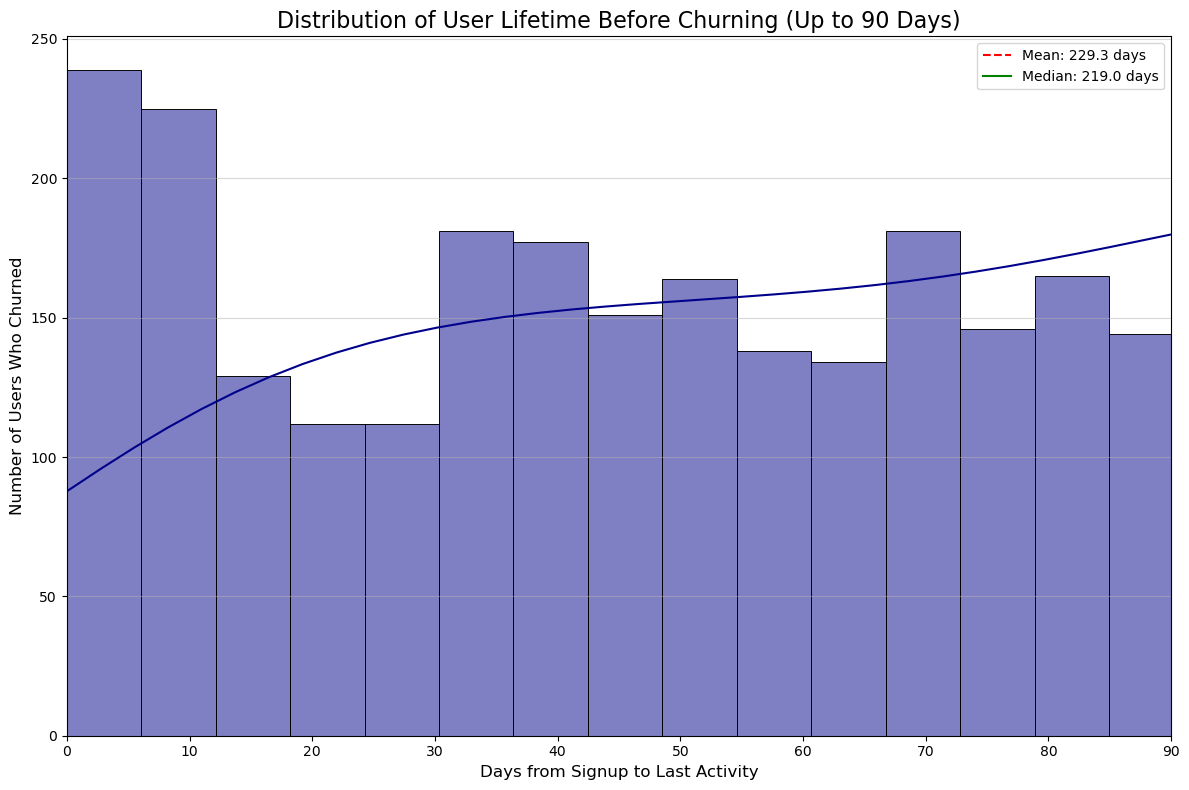

In [131]:

users = dfs['users.csv']
# --- 2. Calculate User Lifetime for Churned Users ---
print("Calculating lifetime for churned users...")

# a) Convert date columns to datetime objects
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])

# b) Find the last session date for every user
last_session_df = sessions_df.groupby('user_id')['session_start'].max().reset_index()
last_session_df.rename(columns={'session_start': 'last_session_date'}, inplace=True)

# c) Merge last session date into the users dataframe
users_with_last_session = pd.merge(users_df, last_session_df, on='user_id', how='left')

# d) Filter for only users who churned within 90 days
churned_users_df = users_with_last_session[users_with_last_session['churned_90d'] == 1].copy()

# e) Calculate the "days to churn" (active lifetime)
#    This is the duration from signup to their last known activity
churned_users_df.dropna(subset=['last_session_date'], inplace=True)
churned_users_df['days_to_churn'] = (churned_users_df['last_session_date'] - churned_users_df['signup_date']).dt.days

# --- 3. Analyze and Visualize the Distribution ---
print("Analyzing and visualizing time to churn...")

# Remove any negative values that might result from data anomalies
churned_users_df = churned_users_df[churned_users_df['days_to_churn'] >= 0]

# Print descriptive statistics
print("\nDescriptive Statistics for 'Time to Churn':")
print(churned_users_df['days_to_churn'].describe())

# Create the histogram
plt.figure(figsize=(12, 8))
sns.histplot(data=churned_users_df, x='days_to_churn', bins=90, kde=True, color='darkblue')

# Add lines for context and mean/median
plt.axvline(churned_users_df['days_to_churn'].mean(), color='red', linestyle='--', label=f"Mean: {churned_users_df['days_to_churn'].mean():.1f} days")
plt.axvline(churned_users_df['days_to_churn'].median(), color='green', linestyle='-', label=f"Median: {churned_users_df['days_to_churn'].median():.1f} days")

plt.title('Distribution of User Lifetime Before Churning (Up to 90 Days)', fontsize=16)
plt.xlabel('Days from Signup to Last Activity', fontsize=12)
plt.ylabel('Number of Users Who Churned', fontsize=12)
plt.legend()
plt.xlim(0, 90) # Focus on the 90-day window
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.savefig('time_to_churn_distribution.png')
print("\nChurn distribution chart saved as 'time_to_churn_distribution.png'")

Calculating lifetime for churned users...
Analyzing and visualizing time to churn...

Descriptive Statistics for 'Time to Churn' (in Months):
count    12960.000000
mean         7.642760
std          4.598541
min          0.000000
25%          3.833333
50%          7.300000
75%         11.233333
max         18.200000
Name: months_to_churn, dtype: float64

Churn distribution chart (in months) saved as 'time_to_churn_distribution_months.png'


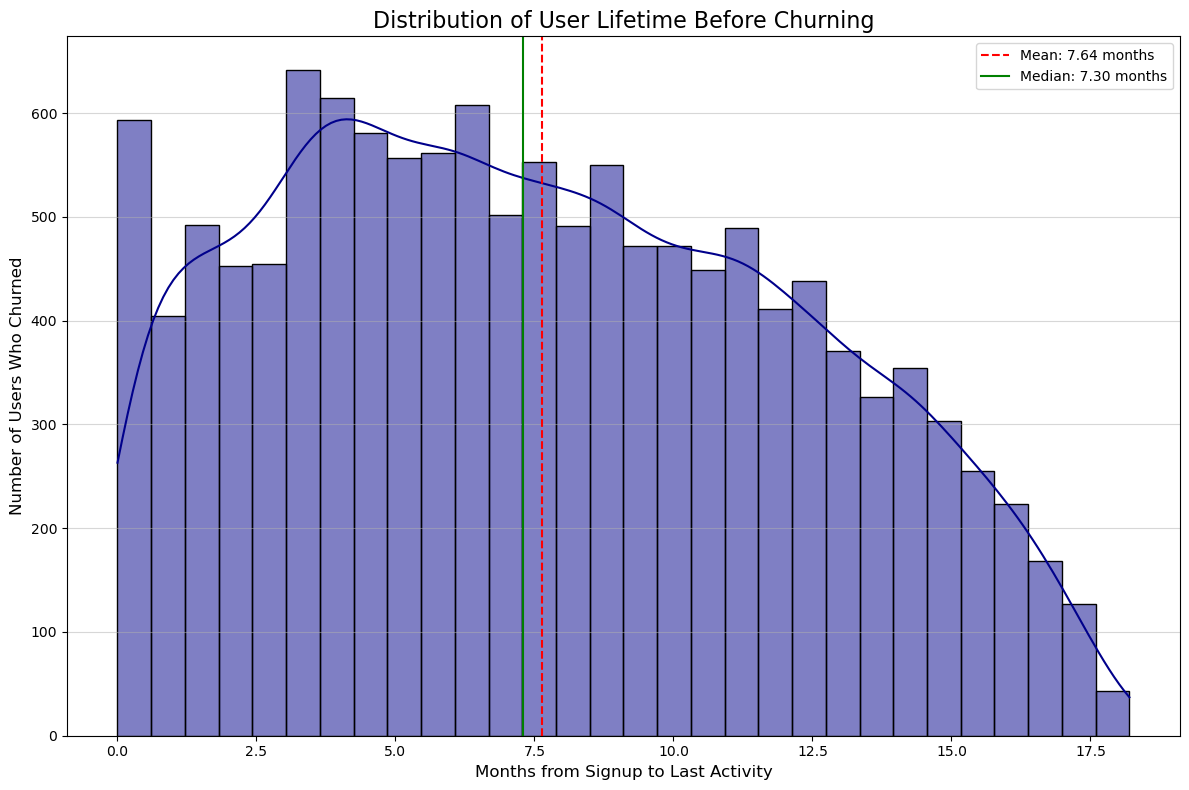

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2. Calculate User Lifetime for Churned Users ---
print("Calculating lifetime for churned users...")

# a) Convert date columns to datetime objects
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])

# b) Find the last session date for every user
last_session_df = sessions_df.groupby('user_id')['session_start'].max().reset_index()
last_session_df.rename(columns={'session_start': 'last_session_date'}, inplace=True)

# c) Merge last session date into the users dataframe
users_with_last_session = pd.merge(users_df, last_session_df, on='user_id', how='left')

# d) Filter for only users who churned within 90 days
churned_users_df = users_with_last_session[users_with_last_session['churned_90d'] == 1].copy()

# e) Calculate the "days to churn" and "months to churn"
churned_users_df.dropna(subset=['last_session_date'], inplace=True)
churned_users_df['days_to_churn'] = (churned_users_df['last_session_date'] - churned_users_df['signup_date']).dt.days
churned_users_df['months_to_churn'] = churned_users_df['days_to_churn'] / 30.0


# --- 3. Analyze and Visualize the Distribution ---
print("Analyzing and visualizing time to churn...")

# Remove any negative values that might result from data anomalies
churned_users_df = churned_users_df[churned_users_df['days_to_churn'] >= 0]

# Print descriptive statistics for months
print("\nDescriptive Statistics for 'Time to Churn' (in Months):")
print(churned_users_df['months_to_churn'].describe())

# Create the histogram using months
plt.figure(figsize=(12, 8))
sns.histplot(data=churned_users_df, x='months_to_churn', bins=30, kde=True, color='darkblue')

# Add lines for context and mean/median in months
plt.axvline(churned_users_df['months_to_churn'].mean(), color='red', linestyle='--', label=f"Mean: {churned_users_df['months_to_churn'].mean():.2f} months")
plt.axvline(churned_users_df['months_to_churn'].median(), color='green', linestyle='-', label=f"Median: {churned_users_df['months_to_churn'].median():.2f} months")

plt.title('Distribution of User Lifetime Before Churning', fontsize=16)
plt.xlabel('Months from Signup to Last Activity', fontsize=12)
plt.ylabel('Number of Users Who Churned', fontsize=12)
plt.legend()
 # Focus on the 3-month window
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.savefig('time_to_churn_distribution_months.png')
print("\nChurn distribution chart (in months) saved as 'time_to_churn_distribution_months.png'")



Calculating lifetime for churned users...
Analyzing and visualizing time to churn...

Descriptive Statistics for 'Time to Churn' (in Months):
count    12960.000000
mean         7.642760
std          4.598541
min          0.000000
25%          3.833333
50%          7.300000
75%         11.233333
max         18.200000
Name: months_to_churn, dtype: float64

Churn distribution box plot saved as 'time_to_churn_boxplot_by_plan.png'


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_53703/2439052054.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=churned_users_df, x='plan_tier', y='months_to_churn', palette='coolwarm', order=['free', 'standard', 'premium'])


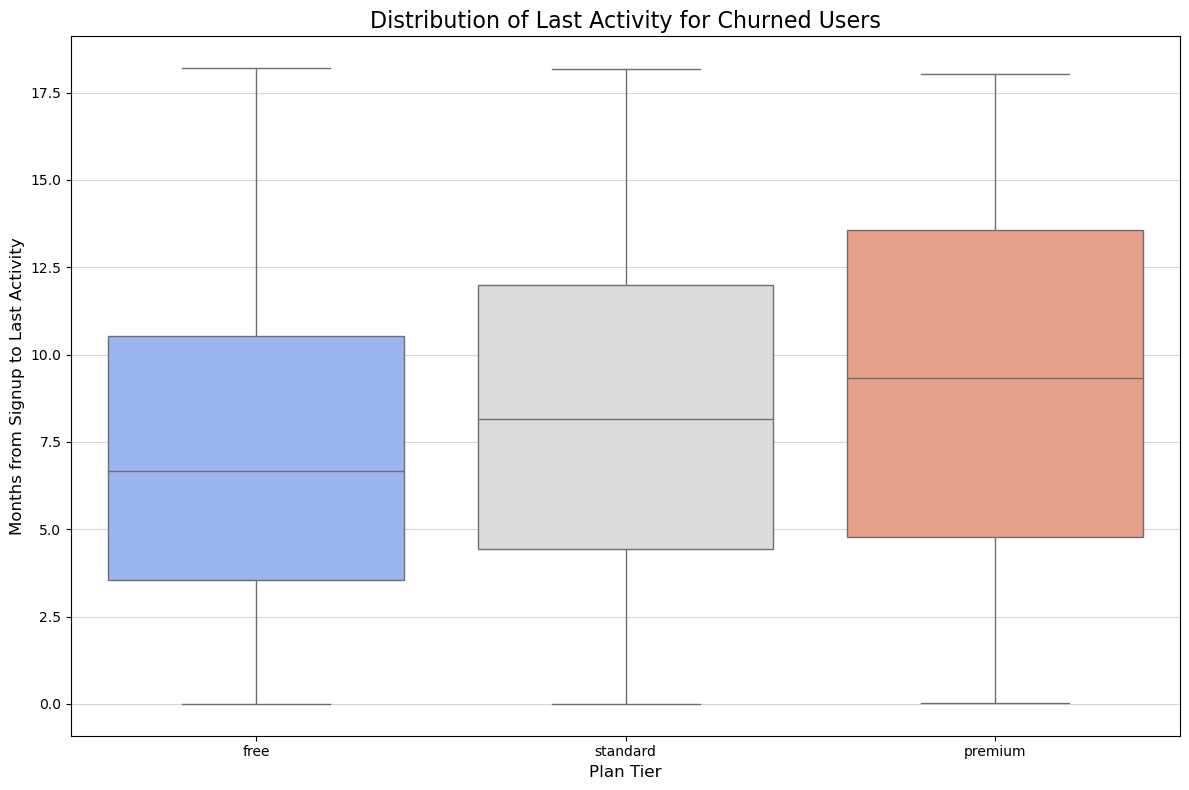

In [142]:
# --- 2. Calculate User Lifetime for Churned Users ---
print("Calculating lifetime for churned users...")

# a) Convert date columns to datetime objects
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])

# b) Find the last session date for every user
last_session_df = sessions_df.groupby('user_id')['session_start'].max().reset_index()
last_session_df.rename(columns={'session_start': 'last_session_date'}, inplace=True)

# c) Merge last session date into the users dataframe
users_with_last_session = pd.merge(users_df, last_session_df, on='user_id', how='left')

# d) Filter for only users who churned within 90 days
churned_users_df = users_with_last_session[users_with_last_session['churned_90d'] == 1].copy()

# e) Calculate the "days to churn" and "months to churn"
churned_users_df.dropna(subset=['last_session_date'], inplace=True)
churned_users_df['days_to_churn'] = (churned_users_df['last_session_date'] - churned_users_df['signup_date']).dt.days
churned_users_df['months_to_churn'] = churned_users_df['days_to_churn'] / 30.0
# --- 3. Analyze and Visualize the Distribution ---
print("Analyzing and visualizing time to churn...")

# Remove any negative values that might result from data anomalies
churned_users_df = churned_users_df[churned_users_df['days_to_churn'] >= 0]

# Print descriptive statistics for months
print("\nDescriptive Statistics for 'Time to Churn' (in Months):")
print(churned_users_df['months_to_churn'].describe())

# Create the box plot to compare distributions by plan tier
plt.figure(figsize=(12, 8))
sns.boxplot(data=churned_users_df, x='plan_tier', y='months_to_churn', palette='coolwarm', order=['free', 'standard', 'premium'])

plt.title('Distribution of Last Activity for Churned Users', fontsize=16)
plt.xlabel('Plan Tier', fontsize=12)
plt.ylabel('Months from Signup to Last Activity', fontsize=12)
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.savefig('time_to_churn_boxplot_by_plan.png')
print("\nChurn distribution box plot saved as 'time_to_churn_boxplot_by_plan.png'")

Preparing data for KPI calculation...
Calculating monthly growth and churn KPIs...

--- Monthly KPI Summary ---
                   mrr  new_customers  churned_customers  net_customer_growth  \
month                                                                           
2024-02-01   1107764.6           5664                  0                 5664   
2024-03-01   2171655.4           5918                  0                 5918   
2024-04-01   3285980.0           5896                  0                 5896   
2024-05-01   4411965.6           5993                  0                 5993   
2024-06-01   5501879.2           5705                  0                 5705   
2024-07-01   6645517.6           6046                  0                 6046   
2024-08-01   7694987.0           5982                  0                 5982   
2024-09-01   8741452.2           5973                  0                 5973   
2024-10-01   9883906.8           5991                  0                 5991 

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/874317604.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_summary, x=monthly_summary.index.strftime('%Y-%m'), y='net_customer_growth', ax=axes[1, 0], palette=['red' if x < 0 else 'blue' for x in monthly_summary['net_customer_growth']])



KPI dashboard saved as 'customer_acquisition_dashboard.png'


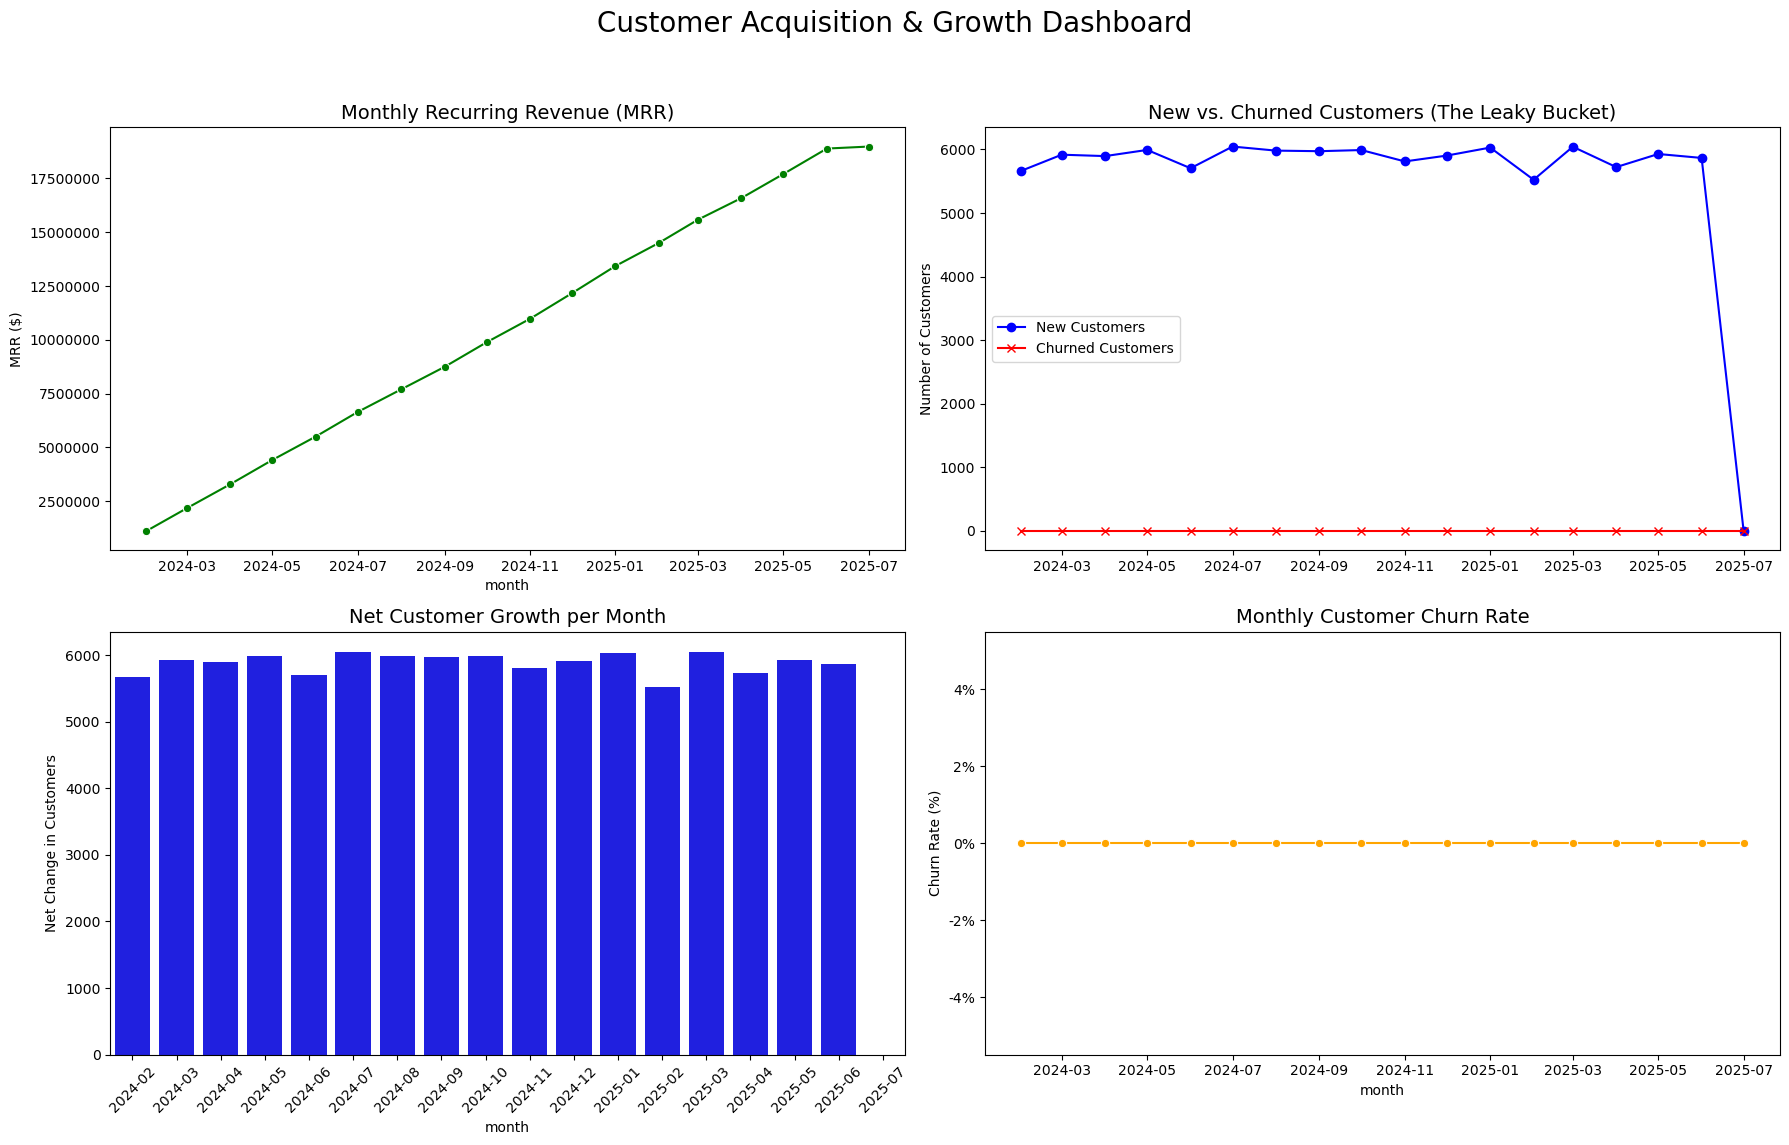

In [11]:
# --- 2. Data Preparation ---
users_df = dfs['users.csv']
billing_df = dfs['billing.csv']
print("Preparing data for KPI calculation...")
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
billing_df['month'] = pd.to_datetime(billing_df['month'])

# Create a monthly summary dataframe
monthly_summary = pd.DataFrame()
months = billing_df['month'].sort_values().unique()
monthly_summary['month'] = months
monthly_summary.set_index('month', inplace=True)

# --- 3. Calculate Monthly KPIs ---
print("Calculating monthly growth and churn KPIs...")

# a) Monthly Recurring Revenue (MRR)
monthly_summary['mrr'] = billing_df.groupby('month')['mrr'].sum()

# b) New and Churned Customers
active_users_per_month = {month: set(df['user_id']) for month, df in billing_df.groupby('month')}
previous_month_users = set()
new_users = []
churned_users = []

for month in months:
    current_month_users = active_users_per_month.get(month, set())
    
    # New users are those in the current month but not in the previous one
    new_users_count = len(current_month_users - previous_month_users)
    new_users.append(new_users_count)
    
    # Churned users are those in the previous month but not in the current one
    churned_users_count = len(previous_month_users - current_month_users)
    churned_users.append(churned_users_count)
    
    previous_month_users = current_month_users

monthly_summary['new_customers'] = new_users
monthly_summary['churned_customers'] = churned_users

# c) Net Customer Growth and Churn Rate
monthly_summary['net_customer_growth'] = monthly_summary['new_customers'] - monthly_summary['churned_customers']
# To calculate churn rate, we need the user count at the start of the month
monthly_summary['active_users_start'] = monthly_summary['new_customers'].cumsum().shift(1).fillna(0)
# Avoid division by zero for the first month
monthly_summary['churn_rate'] = (monthly_summary['churned_customers'] / monthly_summary['active_users_start']).replace([float('inf'), -float('inf')], 0).fillna(0)


print("\n--- Monthly KPI Summary ---")
print(monthly_summary[['mrr', 'new_customers', 'churned_customers', 'net_customer_growth', 'churn_rate']].round(2))

# --- 4. Create the Visualization Dashboard ---
print("\nGenerating KPI dashboard visualization...")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Customer Acquisition & Growth Dashboard', fontsize=20)

# Plot 1: MRR Growth
sns.lineplot(data=monthly_summary, x=monthly_summary.index, y='mrr', ax=axes[0, 0], color='green', marker='o')
axes[0, 0].set_title('Monthly Recurring Revenue (MRR)', fontsize=14)
axes[0, 0].set_ylabel('MRR ($)')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# Plot 2: New vs. Churned Customers
axes[0, 1].plot(monthly_summary.index, monthly_summary['new_customers'], label='New Customers', color='blue', marker='o')
axes[0, 1].plot(monthly_summary.index, monthly_summary['churned_customers'], label='Churned Customers', color='red', marker='x')
axes[0, 1].set_title('New vs. Churned Customers (The Leaky Bucket)', fontsize=14)
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].legend()

# Plot 3: Net Customer Growth
sns.barplot(data=monthly_summary, x=monthly_summary.index.strftime('%Y-%m'), y='net_customer_growth', ax=axes[1, 0], palette=['red' if x < 0 else 'blue' for x in monthly_summary['net_customer_growth']])
axes[1, 0].set_title('Net Customer Growth per Month', fontsize=14)
axes[1, 0].set_ylabel('Net Change in Customers')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Customer Churn Rate
sns.lineplot(data=monthly_summary, x=monthly_summary.index, y='churn_rate', ax=axes[1, 1], color='orange', marker='o')
axes[1, 1].set_title('Monthly Customer Churn Rate', fontsize=14)
axes[1, 1].set_ylabel('Churn Rate (%)')
axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('customer_acquisition_dashboard.png')
print("\nKPI dashboard saved as 'customer_acquisition_dashboard.png'")

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------
# CONFIG
# ---------------------------
CSV_PATH = "users.csv"   # change if needed
EXCLUDE_FREE = True      # exclude plan_tier == 'free'
GROWTH_TARGET_PCT = 0.05 # e.g., aim to grow active base +5% next month
USE_ROLLING_CHURN = True # smooth churn using last 3 cohorts

# ---------------------------
# LOAD & CLEAN
# ---------------------------
df = pd.read_csv(CSV_PATH)

# fix common trailing-dot issue
if "total_events." in df.columns:
    df = df.rename(columns={"total_events.": "total_events"})

# parse dates
df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce", dayfirst=True)

# optional: exclude free plans
if EXCLUDE_FREE and "plan_tier" in df.columns:
    df = df[ df["plan_tier"].astype(str).str.strip().str.lower() != "free" ]

# enforce 0/1 on flags we’ll use
flag_cols = [
    "is_enterprise","churned_90d","bitbucket_integration","confluence_action",
    "jira_action","team_invite","trello_export_csv"
]
for c in flag_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# total_events numeric
df["total_events"] = pd.to_numeric(df["total_events"], errors="coerce").fillna(0)

# Cohort (by signup month)
df = df.dropna(subset=["signup_date"])
df["signup_month"] = df["signup_date"].dt.to_period("M").dt.to_timestamp()

# ---------------------------
# 1) Current active base proxy
# ---------------------------
# Without an "active" flag or last-seen timestamp, use: users with total_events > 0 as an active proxy.
current_active = int((df["total_events"] > 0).sum())

# ---------------------------
# 2) Churn by cohort (90-day)
# ---------------------------
cohort = (
    df.groupby("signup_month", as_index=False)
      .agg(
          signups=("user_id","nunique"),
          churned_90d=("churned_90d","mean"),
          any_events=("total_events", lambda s: (s>0).mean()),
          integration_attach=("bitbucket_integration", "mean")
      )
)

# Add a broader integration attach rate (any of the listed actions)
if all(col in df.columns for col in ["bitbucket_integration","confluence_action","jira_action","team_invite","trello_export_csv"]):
    has_any_integration = (
        (df["bitbucket_integration"]>0) |
        (df["confluence_action"]>0) |
        (df["jira_action"]>0) |
        (df["team_invite"]>0) |
        (df["trello_export_csv"]>0)
    ).astype(int)
    by_cohort_any = df.groupby("signup_month")["user_id"].count().rename("cnt").to_frame()
    by_cohort_any["any_integration"] = df.groupby("signup_month")[has_any_integration].mean()
    cohort = cohort.merge(by_cohort_any["any_integration"].reset_index(), on="signup_month", how="left")
    cohort = cohort.rename(columns={"any_integration":"integration_any_share"})
else:
    cohort["integration_any_share"] = np.nan

cohort["retention_90d"] = 1 - cohort["churned_90d"]

# ---------------------------
# 3) Acquisition performance
# ---------------------------
# signups by month already there (= "signups")
# add share by channel/industry for last full month (if present)
latest_month = cohort["signup_month"].max()
mix_slice = df[df["signup_month"] == latest_month]

acq_mix = {}
if "acquisition_channel" in df.columns and not mix_slice.empty:
    acq_mix["channel_mix_latest"] = (
        mix_slice["acquisition_channel"].value_counts(normalize=True).sort_values(ascending=False)
    )
if "industry" in df.columns and not mix_slice.empty:
    acq_mix["industry_mix_latest"] = (
        mix_slice["industry"].value_counts(normalize=True).sort_values(ascending=False)
    )

# ---------------------------
# 4) Gap to target (next month)
# ---------------------------
# Estimate projected churn rate = latest or rolling-3 average churned_90d
if USE_ROLLING_CHURN and (cohort.shape[0] >= 3):
    projected_churn_rate = float(cohort.tail(3)["churned_90d"].mean())
else:
    projected_churn_rate = float(cohort["churned_90d"].iloc[-1]) if not cohort.empty else 0.0

target_active_next = int(round(current_active * (1 + GROWTH_TARGET_PCT)))
projected_retained_next = int(round(current_active * (1 - projected_churn_rate)))  # proxy
required_new_customers = max(target_active_next - projected_retained_next, 0)

gap_summary = pd.DataFrame({
    "metric": ["current_active","projected_churn_rate","target_active_next","projected_retained_next","required_new_customers"],
    "value": [current_active, projected_churn_rate, target_active_next, projected_retained_next, required_new_customers]
})

# ---------------------------
# 5) Helpful tables for slides
# ---------------------------
# Cohort summary (signups, churn, retention, early engagement, integration attach)
cohort_out = cohort.sort_values("signup_month").copy()
cohort_out["churned_90d"] = cohort_out["churned_90d"].round(3)
cohort_out["retention_90d"] = cohort_out["retention_90d"].round(3)
cohort_out["any_events"] = cohort_out["any_events"].round(3)
cohort_out["integration_any_share"] = cohort_out["integration_any_share"].round(3)

print("\n— Gap to Target (next month) —")
print(gap_summary.to_string(index=False))

print("\n— Acquisition by Cohort —")
print(cohort_out[["signup_month","signups","churned_90d","retention_90d","any_events","integration_any_share"]]
      .to_string(index=False))

if acq_mix:
    if "channel_mix_latest" in acq_mix:
        print(f"\n— Acquisition Mix (latest cohort {latest_month.date()}) —")
        print((acq_mix["channel_mix_latest"]*100).round(1).astype(str) + "%")
    if "industry_mix_latest" in acq_mix:
        print(f"\n— Industry Mix (latest cohort {latest_month.date()}) —")
        print((acq_mix["industry_mix_latest"]*100).round(1).astype(str) + "%")

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/2557922800.py:22: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce", dayfirst=True)


KeyError: 'total_events'


--- Monthly MRR Summary ---
        month         mrr
0  2024-02-01   1107764.6
1  2024-03-01   2171655.4
2  2024-04-01   3285980.0
3  2024-05-01   4411965.6
4  2024-06-01   5501879.2
5  2024-07-01   6645517.6
6  2024-08-01   7694987.0
7  2024-09-01   8741452.2
8  2024-10-01   9883906.8
9  2024-11-01  10976142.0
10 2024-12-01  12167248.6
11 2025-01-01  13430408.6
12 2025-02-01  14502875.8
13 2025-03-01  15587177.2
14 2025-04-01  16591407.2
15 2025-05-01  17710759.6
16 2025-06-01  18891213.4
17 2025-07-01  18984224.0

Generating MRR growth chart...

MRR growth chart saved as 'mrr_growth_chart.png'


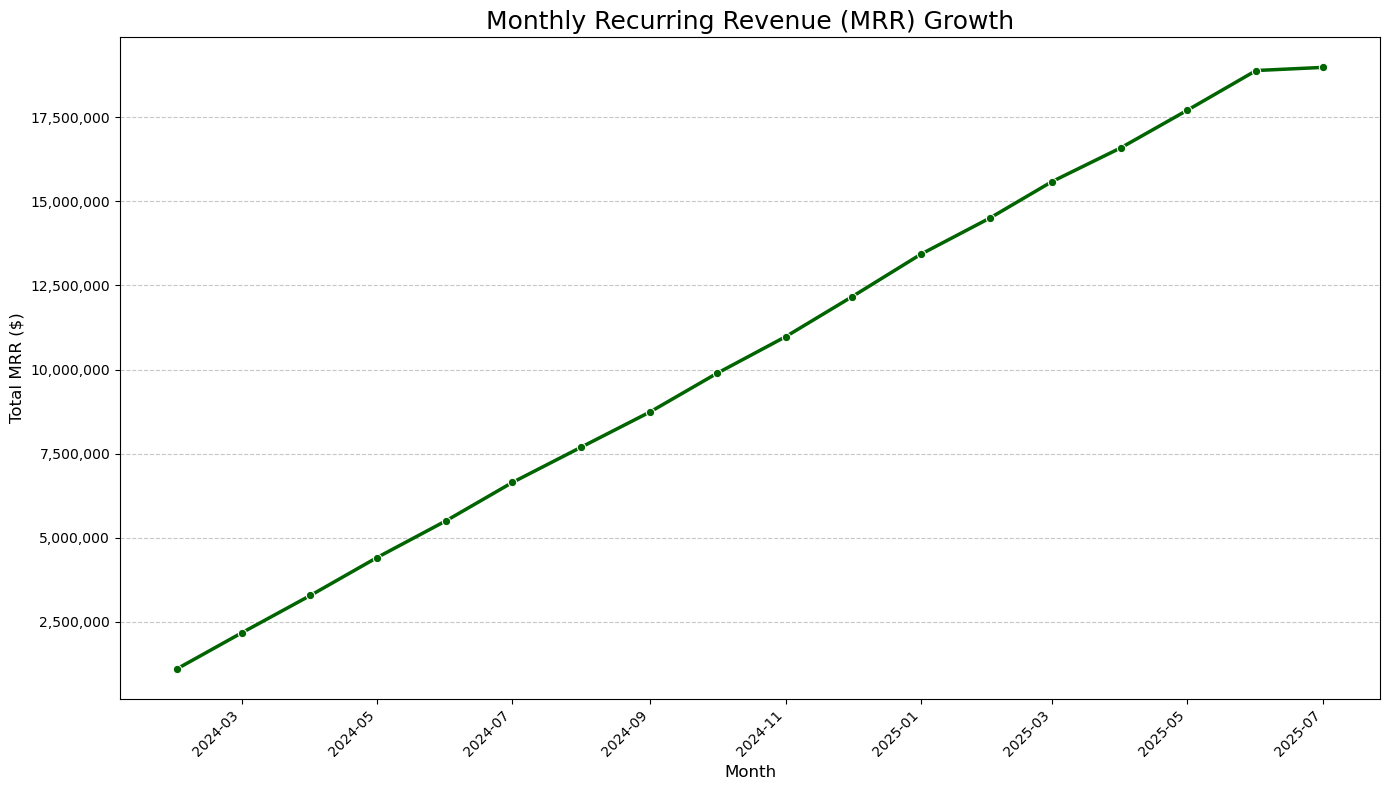

In [13]:
# a) Ensure 'month' is a datetime object for correct sorting and plotting
billing_df['month'] = pd.to_datetime(billing_df['month'])

# b) Group by month and sum the MRR
monthly_mrr = billing_df.groupby('month')['mrr'].sum().reset_index()

print("\n--- Monthly MRR Summary ---")
print(monthly_mrr)

# --- 3. Create the MRR Growth Line Chart ---
print("\nGenerating MRR growth chart...")

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=monthly_mrr,
    x='month',
    y='mrr',
    marker='o',
    color='darkgreen',
    linewidth=2.5
)

# Formatting the plot for clarity
plt.title('Monthly Recurring Revenue (MRR) Growth', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total MRR ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure y-axis labels are formatted as full numbers (not scientific notation)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figure
plt.savefig('mrr_growth_chart.png')
print("\nMRR growth chart saved as 'mrr_growth_chart.png'")

File 'users.csv' loaded successfully!
Calculating total new signups for each month...

--- Monthly Signups Summary ---
   signup_month  new_signups
0    2024-02-01         5664
1    2024-03-01         5918
2    2024-04-01         5896
3    2024-05-01         5993
4    2024-06-01         5705
5    2024-07-01         6046
6    2024-08-01         5982
7    2024-09-01         5973
8    2024-10-01         5991
9    2024-11-01         5812
10   2024-12-01         5904
11   2025-01-01         6030
12   2025-02-01         5524
13   2025-03-01         6043
14   2025-04-01         5723
15   2025-05-01         5929
16   2025-06-01         5867

Generating new signups chart...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/1157362441.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_signups['signup_month']])



New signups chart saved as 'new_signups_chart.png'


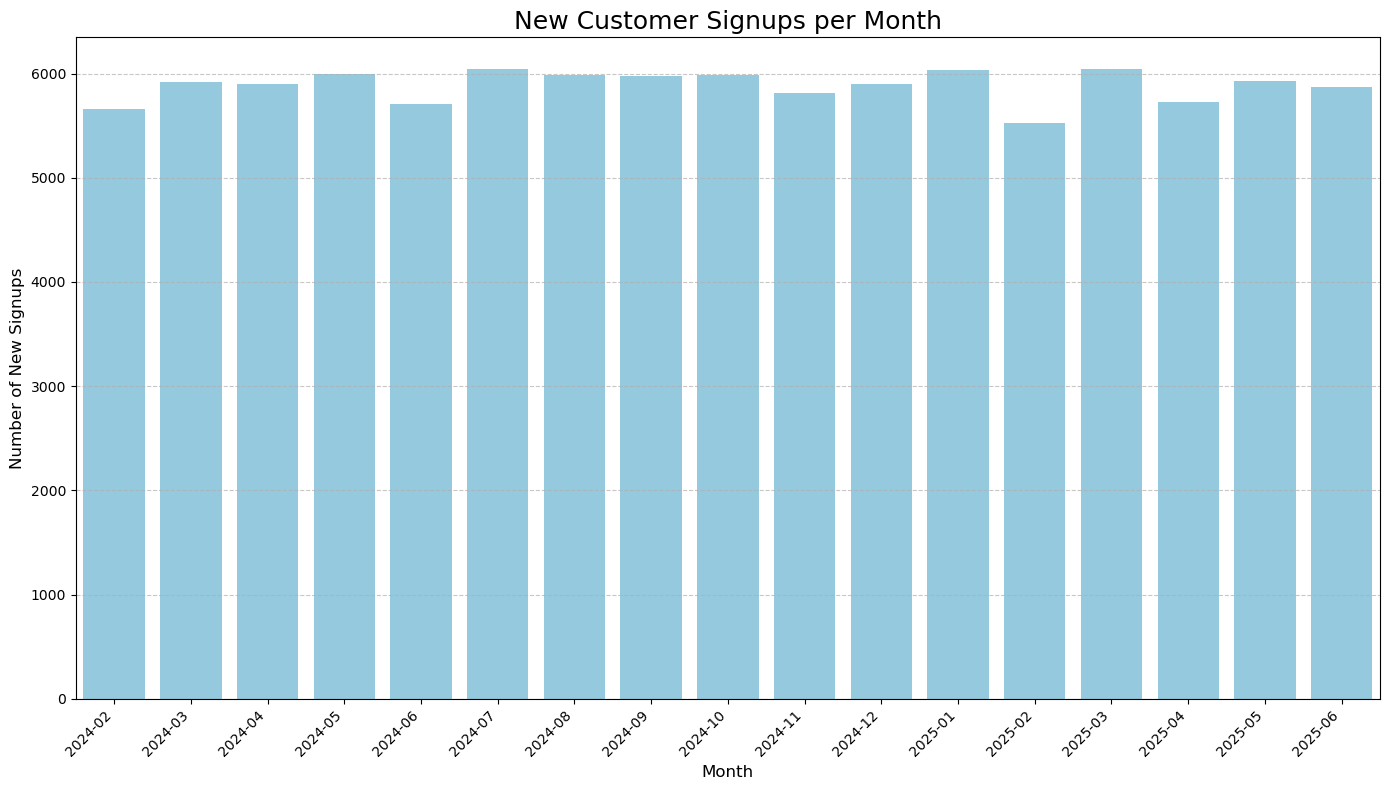

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load User Data ---
try:
    users_df = pd.read_csv('users.csv')
    print("File 'users.csv' loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading file: {e}")
    exit()

# --- 2. Calculate Monthly Signups ---
print("Calculating total new signups for each month...")

# a) Ensure 'signup_date' is a datetime object
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])

# b) Extract the month from the signup date to group by
# We use .dt.to_period('M').dt.to_timestamp() to get the first day of each month for clean grouping
users_df['signup_month'] = users_df['signup_date'].dt.to_period('M').dt.to_timestamp()

# c) Group by signup month and count the number of users
monthly_signups = users_df.groupby('signup_month').size().reset_index(name='new_signups')


print("\n--- Monthly Signups Summary ---")
print(monthly_signups)

# --- 3. Create the New Signups Chart ---
print("\nGenerating new signups chart...")

plt.figure(figsize=(14, 8))
sns.barplot(
    data=monthly_signups,
    x='signup_month',
    y='new_signups',
    color='skyblue'
)

# Formatting the plot for clarity
plt.title('New Customer Signups per Month', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of New Signups', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format x-axis labels to be more readable (e.g., '2024-01')
ax = plt.gca()
ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_signups['signup_month']])

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figure
plt.savefig('new_signups_chart.png')
print("\nNew signups chart saved as 'new_signups_chart.png'")


Files loaded successfully!
Preparing data for KPI calculation...
Calculating monthly revenue growth components...

--- Monthly Revenue Growth Summary ---
        month    new_mrr  expansion_mrr  churned_mrr  contraction_mrr  \
0  2024-03-01  1057027.6        45830.8          0.0          38967.6   
1  2024-04-01  1110485.6        93724.4          0.0          89885.4   
2  2024-05-01  1109736.8       141171.0          0.0         124922.2   
3  2024-06-01  1080997.8       190054.6          0.0         181138.8   
4  2024-07-01  1129295.6       231954.8          0.0         217612.0   
5  2024-08-01  1011873.2       291020.4          0.0         253424.2   
6  2024-09-01  1013583.4       332026.4          0.0         299144.6   
7  2024-10-01  1127248.6       370350.0          0.0         355144.0   
8  2024-11-01  1059697.4       431094.0          0.0         398556.2   
9  2024-12-01  1095420.0       504327.8          0.0         408641.2   
10 2025-01-01  1200363.0       526186.8    

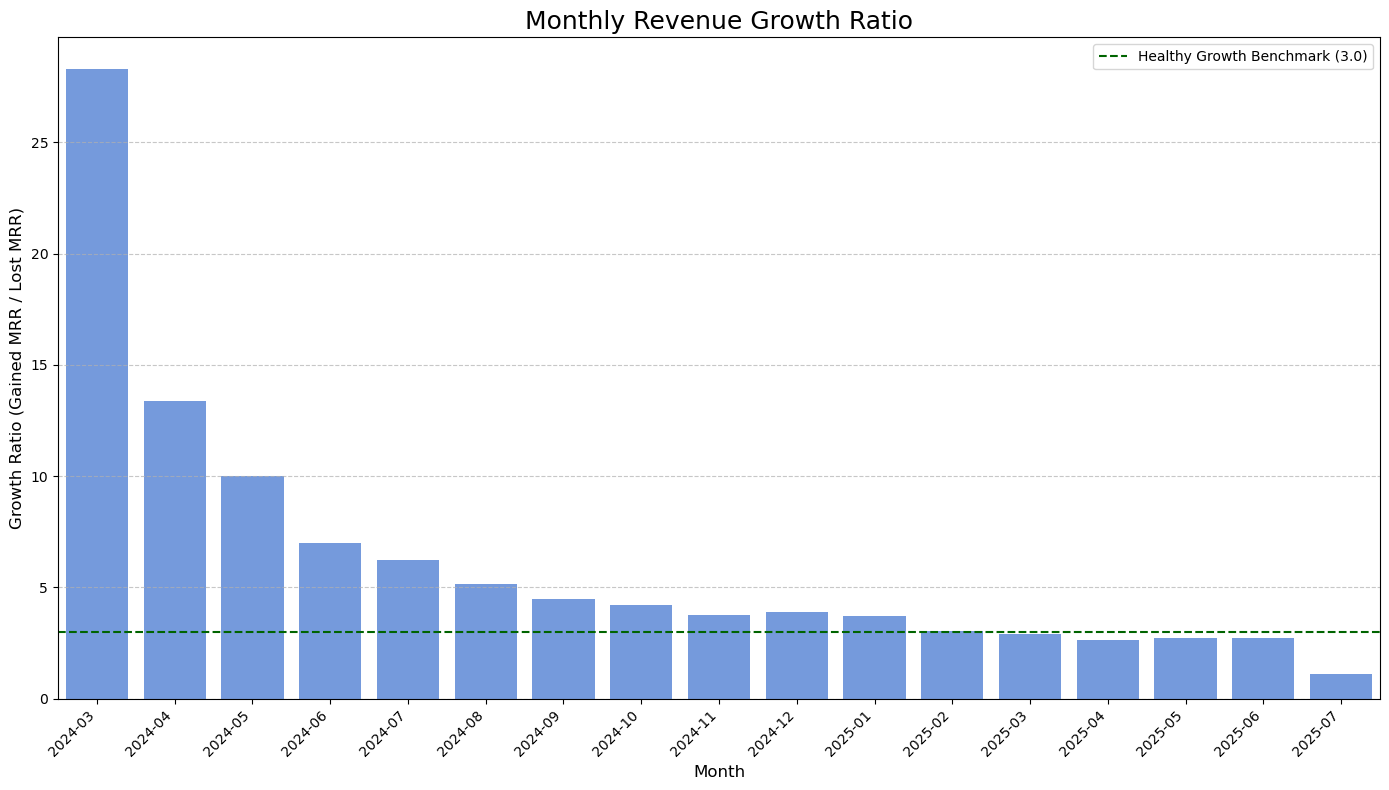

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load All Necessary Data ---
try:
    users_df = pd.read_csv('users.csv')
    billing_df = pd.read_csv('billing.csv')
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- 2. Data Preparation ---
print("Preparing data for KPI calculation...")
billing_df['month'] = pd.to_datetime(billing_df['month'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

# --- 3. Calculate Monthly Revenue Components ---
print("Calculating monthly revenue growth components...")

months = sorted(billing_df['month'].unique())
growth_data = []

for i in range(1, len(months)):
    current_month_date = months[i]
    previous_month_date = months[i-1]

    current_month_df = billing_df[billing_df['month'] == current_month_date]
    previous_month_df = billing_df[billing_df['month'] == previous_month_date]

    current_users = set(current_month_df['user_id'])
    previous_users = set(previous_month_df['user_id'])

    # a) New MRR
    new_user_ids = current_users - previous_users
    new_mrr = current_month_df[current_month_df['user_id'].isin(new_user_ids)]['mrr'].sum()

    # b) Churned MRR
    churned_user_ids = previous_users - current_users
    churned_mrr = previous_month_df[previous_month_df['user_id'].isin(churned_user_ids)]['mrr'].sum()

    # c) Expansion and Contraction MRR
    retained_user_ids = current_users.intersection(previous_users)
    retained_df_current = current_month_df[current_month_df['user_id'].isin(retained_user_ids)].set_index('user_id')
    retained_df_previous = previous_month_df[previous_month_df['user_id'].isin(retained_user_ids)].set_index('user_id')
    
    mrr_diff = retained_df_current['mrr'] - retained_df_previous['mrr']
    
    expansion_mrr = mrr_diff[mrr_diff > 0].sum()
    contraction_mrr = -mrr_diff[mrr_diff < 0].sum() # Make it a positive number

    # d) Calculate Growth Ratio
    revenue_gained = new_mrr + expansion_mrr
    revenue_lost = churned_mrr + contraction_mrr
    
    growth_ratio = revenue_gained / revenue_lost if revenue_lost > 0 else revenue_gained

    growth_data.append({
        'month': current_month_date,
        'new_mrr': new_mrr,
        'expansion_mrr': expansion_mrr,
        'churned_mrr': churned_mrr,
        'contraction_mrr': contraction_mrr,
        'growth_ratio': growth_ratio
    })

monthly_growth_df = pd.DataFrame(growth_data)

print("\n--- Monthly Revenue Growth Summary ---")
print(monthly_growth_df.round(2))

# --- 4. Create the Visualization ---
print("\nGenerating revenue growth ratio chart...")
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=monthly_growth_df,
    x=monthly_growth_df['month'].dt.strftime('%Y-%m'),
    y='growth_ratio',
    color='cornflowerblue'
)

# Add a benchmark line for a healthy growth ratio
ax.axhline(3, color='darkgreen', linestyle='--', label='Healthy Growth Benchmark (3.0)')

plt.title('Monthly Revenue Growth Ratio', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Growth Ratio (Gained MRR / Lost MRR)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('revenue_growth_ratio.png')
print("\nRevenue growth ratio chart saved as 'revenue_growth_ratio.png'")

Files loaded successfully!
Preparing data for KPI calculation...
Calculating monthly revenue growth components...

--- Monthly Revenue Growth Summary ---
        month    new_mrr  expansion_mrr  churned_mrr  contraction_mrr  \
0  2024-03-01  1057027.6        45830.8          0.0          38967.6   
1  2024-04-01  1110485.6        93724.4          0.0          89885.4   
2  2024-05-01  1109736.8       141171.0          0.0         124922.2   
3  2024-06-01  1080997.8       190054.6          0.0         181138.8   
4  2024-07-01  1129295.6       231954.8          0.0         217612.0   
5  2024-08-01  1011873.2       291020.4          0.0         253424.2   
6  2024-09-01  1013583.4       332026.4          0.0         299144.6   
7  2024-10-01  1127248.6       370350.0          0.0         355144.0   
8  2024-11-01  1059697.4       431094.0          0.0         398556.2   
9  2024-12-01  1095420.0       504327.8          0.0         408641.2   
10 2025-01-01  1200363.0       526186.8    

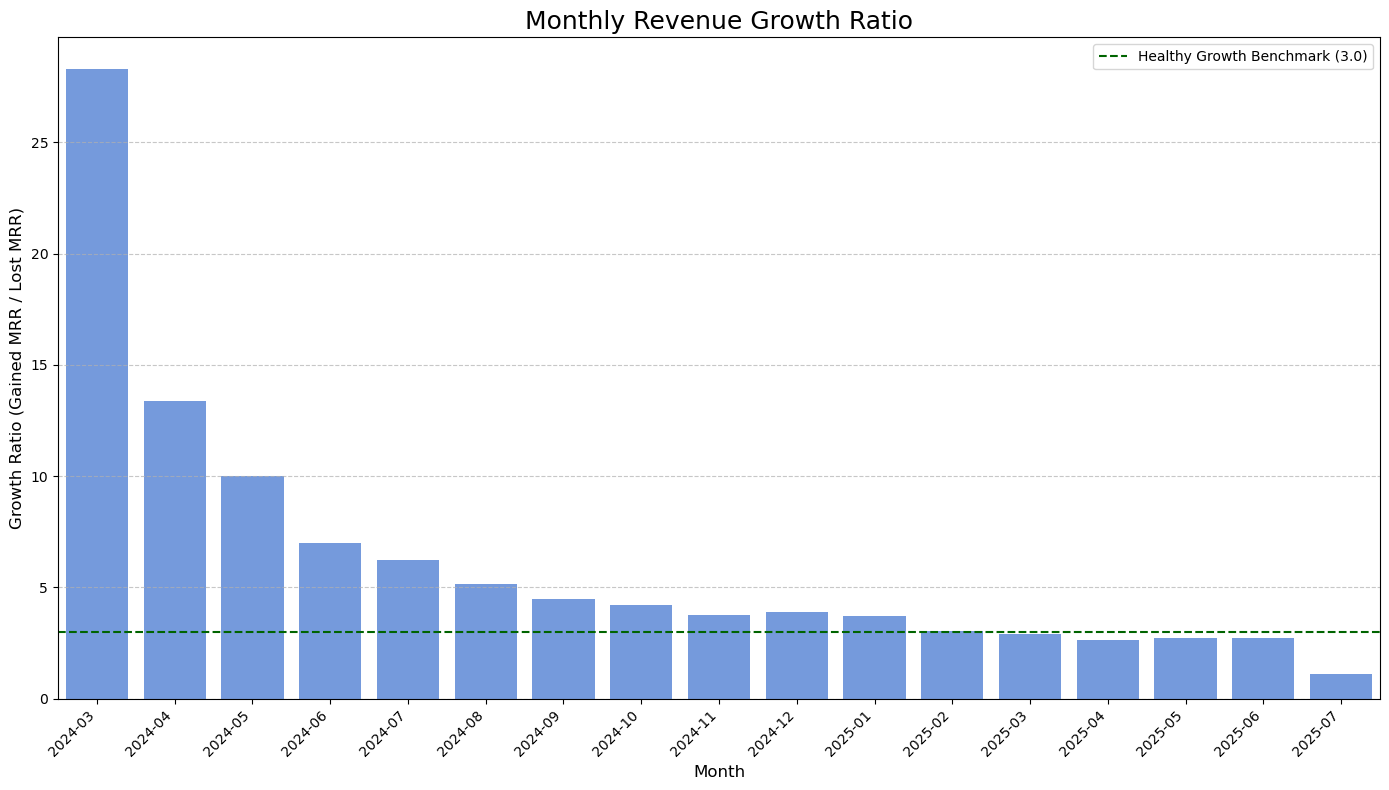

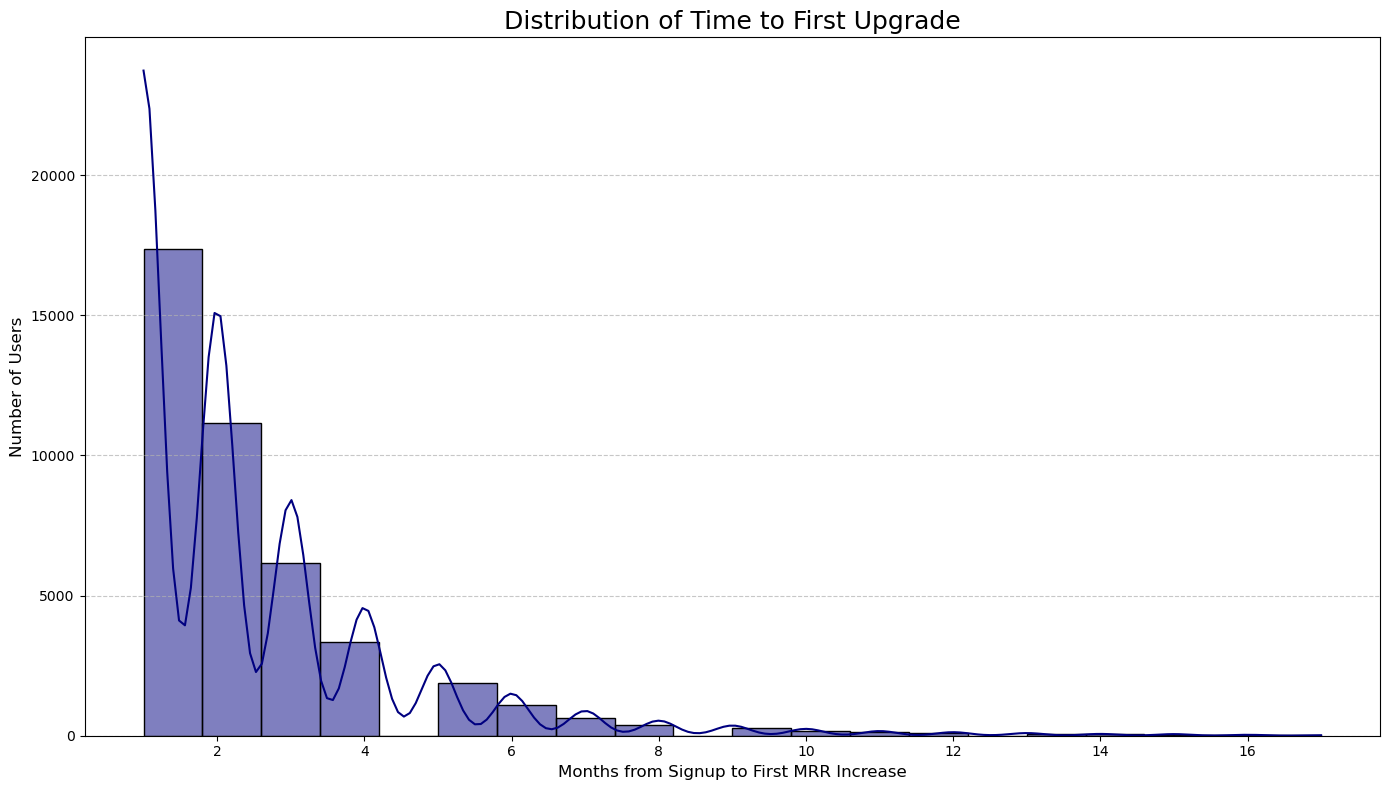

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load All Necessary Data ---
try:
    users_df = pd.read_csv('users.csv')
    billing_df = pd.read_csv('billing.csv')
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- 2. Data Preparation ---
print("Preparing data for KPI calculation...")
billing_df['month'] = pd.to_datetime(billing_df['month'])
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

# --- 3. Calculate Monthly Revenue Components ---
print("Calculating monthly revenue growth components...")

months = sorted(billing_df['month'].unique())
growth_data = []

# Calculate MRR differences for all users
billing_df['mrr_diff'] = billing_df.groupby('user_id')['mrr'].diff()

for i in range(1, len(months)):
    current_month_date = months[i]
    previous_month_date = months[i-1]

    current_month_df = billing_df[billing_df['month'] == current_month_date]
    previous_month_df = billing_df[billing_df['month'] == previous_month_date]

    current_users = set(current_month_df['user_id'])
    previous_users = set(previous_month_df['user_id'])

    # a) New MRR
    new_user_ids = current_users - previous_users
    new_mrr = current_month_df[current_month_df['user_id'].isin(new_user_ids)]['mrr'].sum()

    # b) Churned MRR
    churned_user_ids = previous_users - current_users
    churned_mrr = previous_month_df[previous_month_df['user_id'].isin(churned_user_ids)]['mrr'].sum()

    # c) Expansion and Contraction MRR
    retained_user_ids = current_users.intersection(previous_users)
    retained_df_current = current_month_df[current_month_df['user_id'].isin(retained_user_ids)].set_index('user_id')
    retained_df_previous = previous_month_df[previous_month_df['user_id'].isin(retained_user_ids)].set_index('user_id')
    
    mrr_diff_retained = retained_df_current['mrr'] - retained_df_previous['mrr']
    
    expansion_mrr = mrr_diff_retained[mrr_diff_retained > 0].sum()
    contraction_mrr = -mrr_diff_retained[mrr_diff_retained < 0].sum() # Make it a positive number

    # d) Calculate Growth Ratio
    revenue_gained = new_mrr + expansion_mrr
    revenue_lost = churned_mrr + contraction_mrr
    
    growth_ratio = revenue_gained / revenue_lost if revenue_lost > 0 else revenue_gained

    growth_data.append({
        'month': current_month_date,
        'new_mrr': new_mrr,
        'expansion_mrr': expansion_mrr,
        'churned_mrr': churned_mrr,
        'contraction_mrr': contraction_mrr,
        'growth_ratio': growth_ratio
    })

monthly_growth_df = pd.DataFrame(growth_data)

print("\n--- Monthly Revenue Growth Summary ---")
print(monthly_growth_df.round(2))

# --- 4. Create the Visualization ---
print("\nGenerating revenue growth ratio chart...")
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=monthly_growth_df,
    x=monthly_growth_df['month'].dt.strftime('%Y-%m'),
    y='growth_ratio',
    color='cornflowerblue'
)

# Add a benchmark line for a healthy growth ratio
ax.axhline(3, color='darkgreen', linestyle='--', label='Healthy Growth Benchmark (3.0)')

plt.title('Monthly Revenue Growth Ratio', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Growth Ratio (Gained MRR / Lost MRR)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('revenue_growth_ratio.png')
print("\nRevenue growth ratio chart saved as 'revenue_growth_ratio.png'")


# --- 5. Analyze Time to First Upgrade ---
print("\n--- Analyzing Time to First Upgrade ---")

# a) Find the first month of MRR increase for each user
upgrades_df = billing_df[billing_df['mrr_diff'] > 0].copy()
first_upgrade_df = upgrades_df.loc[upgrades_df.groupby('user_id')['month'].idxmin()]
first_upgrade_df = first_upgrade_df[['user_id', 'month']].rename(columns={'month': 'first_upgrade_month'})

# b) Merge with user signup date
time_to_upgrade_df = pd.merge(first_upgrade_df, users_df[['user_id', 'signup_date']], on='user_id')

# c) Calculate months from signup to first upgrade
time_to_upgrade_df['months_to_upgrade'] = \
    (time_to_upgrade_df['first_upgrade_month'].dt.to_period('M') - time_to_upgrade_df['signup_date'].dt.to_period('M')).apply(lambda x: x.n)

# d) Create the visualization
plt.figure(figsize=(14, 8))
sns.histplot(data=time_to_upgrade_df, x='months_to_upgrade', bins=20, kde=True, color='navy')

plt.title('Distribution of Time to First Upgrade', fontsize=18)
plt.xlabel('Months from Signup to First MRR Increase', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('time_to_first_upgrade_distribution.png')
print("\nTime to first upgrade chart saved as 'time_to_first_upgrade_distribution.png'")


Files loaded successfully!
Preparing data for KPI calculation...
Calculating monthly revenue growth components...

--- Monthly Revenue Growth Summary ---
        month  growth_ratio   total_mrr
0  2024-03-01         28.30   2171655.4
1  2024-04-01         13.40   3285980.0
2  2024-05-01         10.01   4411965.6
3  2024-06-01          7.02   5501879.2
4  2024-07-01          6.26   6645517.6
5  2024-08-01          5.14   7694987.0
6  2024-09-01          4.50   8741452.2
7  2024-10-01          4.22   9883906.8
8  2024-11-01          3.74  10976142.0
9  2024-12-01          3.91  12167248.6
10 2025-01-01          3.73  13430408.6
11 2025-02-01          3.04  14502875.8
12 2025-03-01          2.93  15587177.2
13 2025-04-01          2.63  16591407.2
14 2025-05-01          2.72  17710759.6
15 2025-06-01          2.75  18891213.4
16 2025-07-01          1.13  18984224.0

Generating dual-axis chart for Growth Ratio vs. Total MRR...

Dual-axis chart saved as 'growth_ratio_vs_mrr.png'


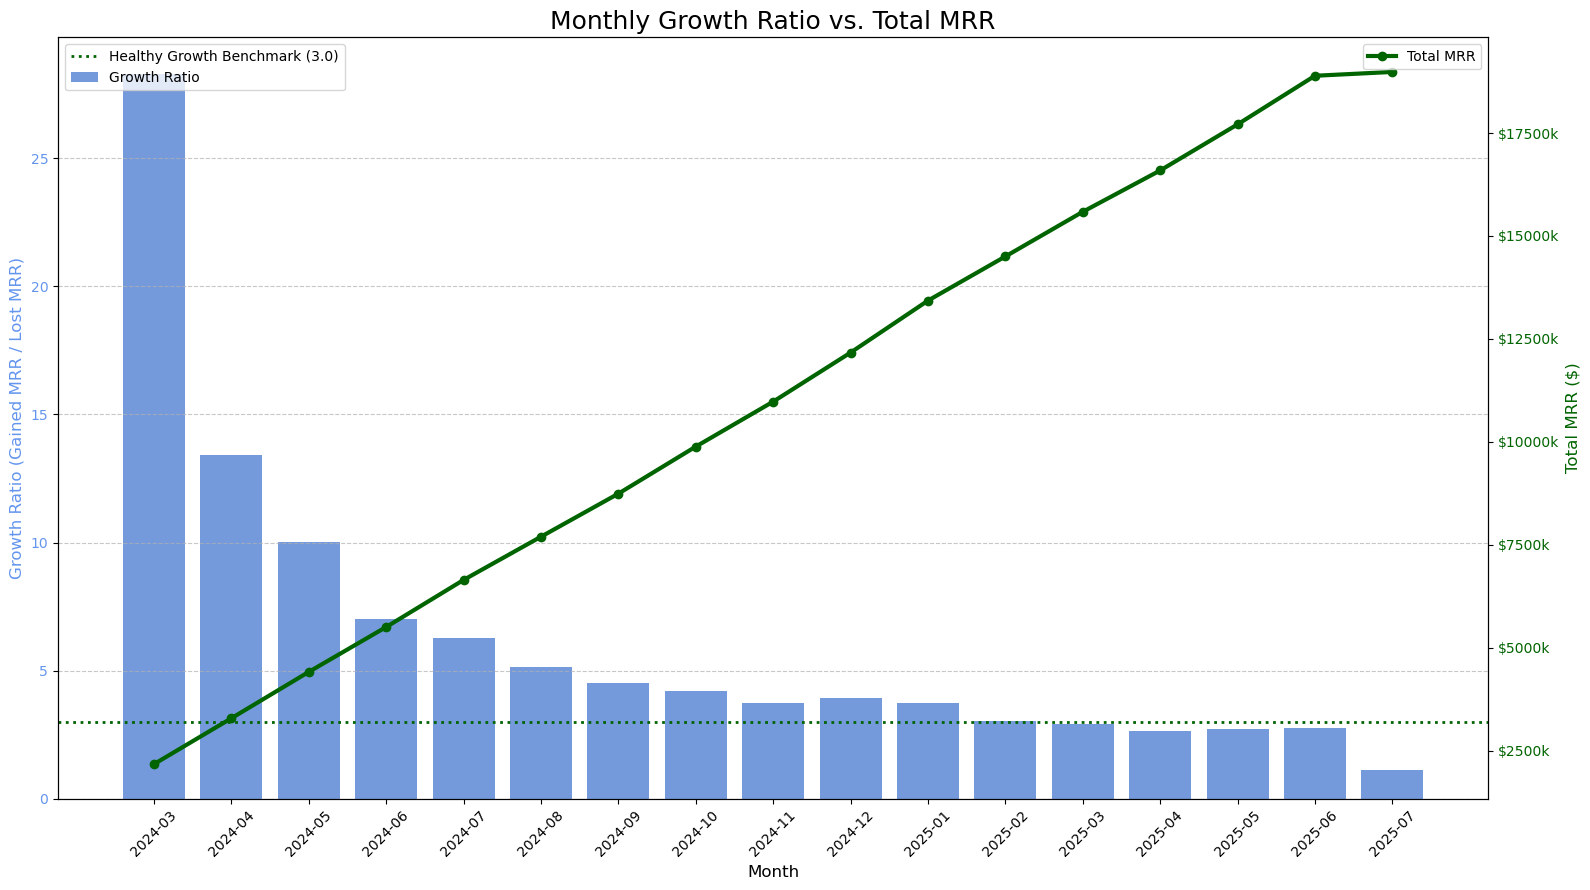

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load All Necessary Data ---
try:
    users_df = pd.read_csv('users.csv')
    billing_df = pd.read_csv('billing.csv')
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- 2. Data Preparation ---
print("Preparing data for KPI calculation...")
billing_df['month'] = pd.to_datetime(billing_df['month'])
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
billing_df = billing_df.sort_values(by=['user_id', 'month'])

# --- 3. Calculate Monthly Revenue Components ---
print("Calculating monthly revenue growth components...")

months = sorted(billing_df['month'].unique())
growth_data = []

# Calculate MRR differences for all users
billing_df['mrr_diff'] = billing_df.groupby('user_id')['mrr'].diff()

for i in range(1, len(months)):
    current_month_date = months[i]
    previous_month_date = months[i-1]

    current_month_df = billing_df[billing_df['month'] == current_month_date]
    previous_month_df = billing_df[billing_df['month'] == previous_month_date]

    current_users = set(current_month_df['user_id'])
    previous_users = set(previous_month_df['user_id'])

    # a) New MRR
    new_user_ids = current_users - previous_users
    new_mrr = current_month_df[current_month_df['user_id'].isin(new_user_ids)]['mrr'].sum()

    # b) Churned MRR
    churned_user_ids = previous_users - current_users
    churned_mrr = previous_month_df[previous_month_df['user_id'].isin(churned_user_ids)]['mrr'].sum()

    # c) Expansion and Contraction MRR
    retained_user_ids = current_users.intersection(previous_users)
    retained_df_current = current_month_df[current_month_df['user_id'].isin(retained_user_ids)].set_index('user_id')
    retained_df_previous = previous_month_df[previous_month_df['user_id'].isin(retained_user_ids)].set_index('user_id')
    
    mrr_diff_retained = retained_df_current['mrr'] - retained_df_previous['mrr']
    
    expansion_mrr = mrr_diff_retained[mrr_diff_retained > 0].sum()
    contraction_mrr = -mrr_diff_retained[mrr_diff_retained < 0].sum() # Make it a positive number

    # d) Calculate Growth Ratio
    revenue_gained = new_mrr + expansion_mrr
    revenue_lost = churned_mrr + contraction_mrr
    
    growth_ratio = revenue_gained / revenue_lost if revenue_lost > 0 else revenue_gained

    # e) Get Total MRR for the month
    total_mrr = current_month_df['mrr'].sum()

    growth_data.append({
        'month': current_month_date,
        'growth_ratio': growth_ratio,
        'total_mrr': total_mrr
    })

monthly_growth_df = pd.DataFrame(growth_data)

print("\n--- Monthly Revenue Growth Summary ---")
print(monthly_growth_df.round(2))

# --- 4. Create the Dual-Axis Visualization ---
print("\nGenerating dual-axis chart for Growth Ratio vs. Total MRR...")

fig, ax1 = plt.subplots(figsize=(16, 9))

# Bar plot for Growth Ratio (left y-axis)
sns.barplot(
    data=monthly_growth_df,
    x=monthly_growth_df['month'].dt.strftime('%Y-%m'),
    y='growth_ratio',
    color='cornflowerblue',
    ax=ax1,
    label='Growth Ratio'
)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Growth Ratio (Gained MRR / Lost MRR)', fontsize=12, color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.axhline(3, color='darkgreen', linestyle=':', label='Healthy Growth Benchmark (3.0)', linewidth=2)
ax1.legend(loc='upper left')

# Line plot for Total MRR (right y-axis)
ax2 = ax1.twinx() # Create a second y-axis that shares the same x-axis
ax2.plot(
    monthly_growth_df['month'].dt.strftime('%Y-%m'),
    monthly_growth_df['total_mrr'],
    color='darkgreen',
    marker='o',
    linewidth=3,
    label='Total MRR'
)
ax2.set_ylabel('Total MRR ($)', fontsize=12, color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x/1000)}k')) # Format as thousands
ax2.legend(loc='upper right')

plt.title('Monthly Growth Ratio vs. Total MRR', fontsize=18)
fig.tight_layout()
plt.savefig('growth_ratio_vs_mrr.png')
print("\nDual-axis chart saved as 'growth_ratio_vs_mrr.png'")

File 'users.csv' loaded successfully!
Calculating new customer signups for each month...

--- Monthly Signup Summary ---
   signup_date  new_signup_count
0   2024-02-29              5664
1   2024-03-31              5918
2   2024-04-30              5896
3   2024-05-31              5993
4   2024-06-30              5705
5   2024-07-31              6046
6   2024-08-31              5982
7   2024-09-30              5973
8   2024-10-31              5991
9   2024-11-30              5812
10  2024-12-31              5904
11  2025-01-31              6030
12  2025-02-28              5524
13  2025-03-31              6043
14  2025-04-30              5723
15  2025-05-31              5929
16  2025-06-30              5867

Generating new signups chart...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/3367764132.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_signups = users_df['user_id'].resample('M').count().reset_index()



New signups chart saved as 'new_signups_chart.png'


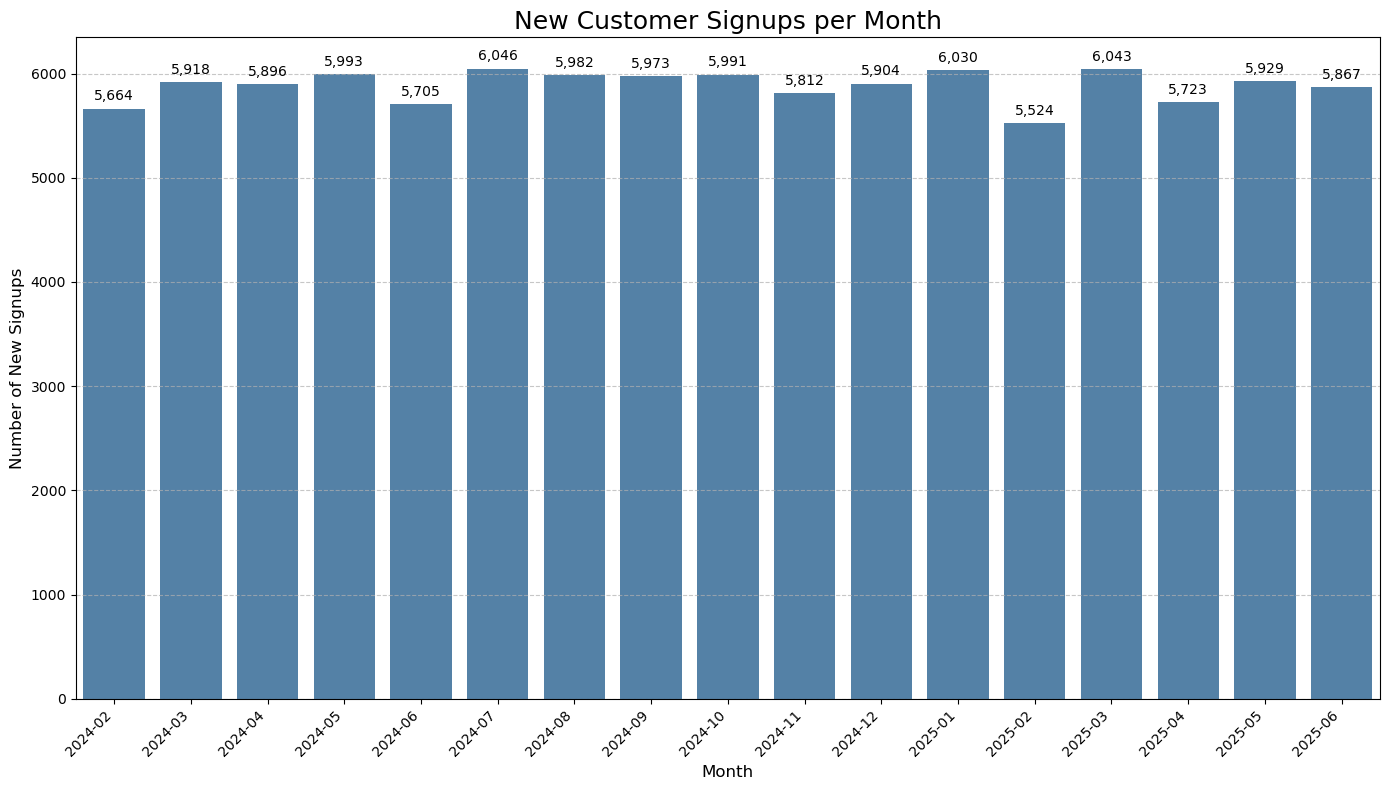

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load User Data ---
try:
    users_df = pd.read_csv('users.csv')
    print("File 'users.csv' loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading file: {e}")
    exit()

# --- 2. Calculate New Signups Per Month ---
print("Calculating new customer signups for each month...")

# a) Ensure 'signup_date' is a datetime object
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])

# b) Set the signup date as the index to allow for time-based resampling
users_df.set_index('signup_date', inplace=True)

# c) Resample the data by month and count the number of users (signups) in each month
monthly_signups = users_df['user_id'].resample('M').count().reset_index()
monthly_signups.rename(columns={'user_id': 'new_signup_count'}, inplace=True)


print("\n--- Monthly Signup Summary ---")
print(monthly_signups)

# --- 3. Create the New Signups Bar Chart ---
print("\nGenerating new signups chart...")

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=monthly_signups,
    x=monthly_signups['signup_date'].dt.strftime('%Y-%m'),
    y='new_signup_count',
    color='steelblue'
)

# Add count labels on top of the bars for clarity
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

# Formatting the plot for clarity
plt.title('New Customer Signups per Month', fontsize=18)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of New Signups', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save the figure
plt.savefig('new_signups_chart.png')
print("\nNew signups chart saved as 'new_signups_chart.png'")

Files 'users.csv' and 'billing.csv' loaded successfully!
Calculating new signups and total MRR for each month...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/9092730.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_signups = users_df.resample('M', on='signup_date')['user_id'].count().reset_index()
/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/9092730.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mrr = billing_df.groupby(pd.Grouper(key='month', freq='M'))['mrr'].sum().reset_index()



--- Correlation Analysis ---
Correlation between New Signups and Total MRR: -0.0158

Generating correlation plot...

Correlation plot saved as 'signups_vs_mrr_correlation.png'


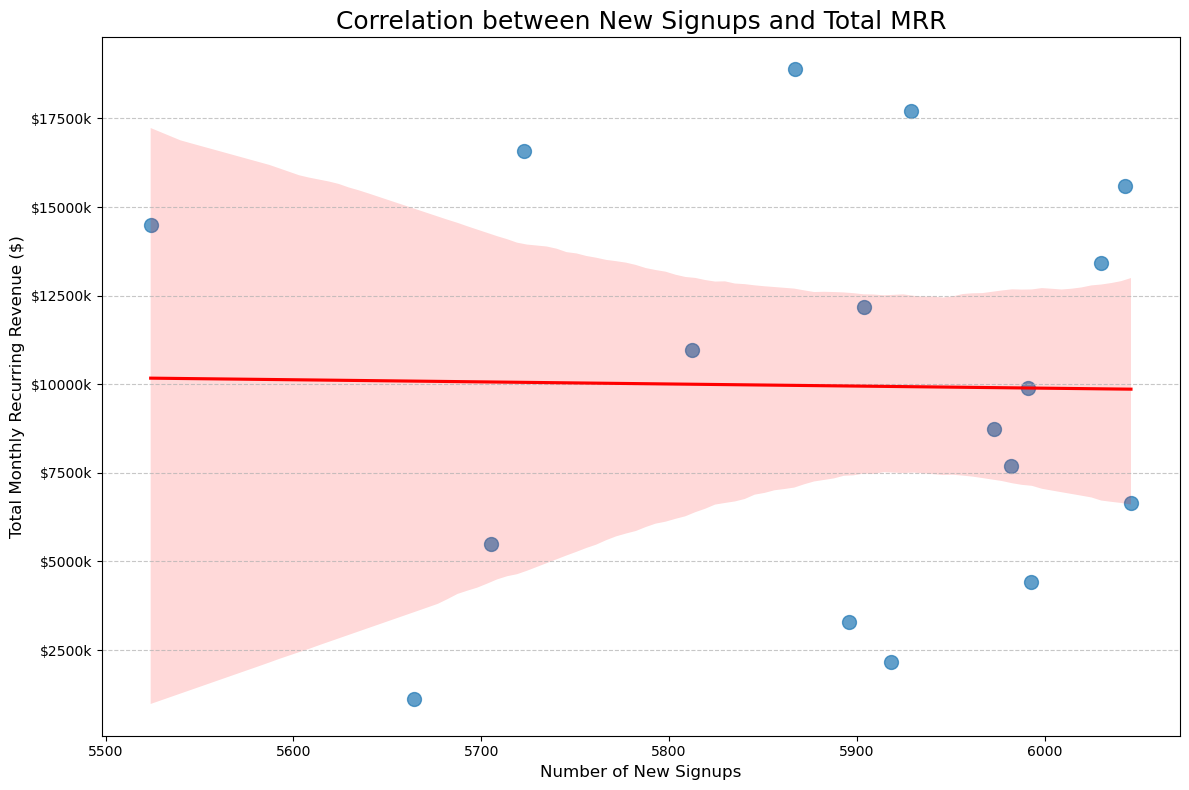

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load All Necessary Data ---
try:
    users_df = pd.read_csv('users.csv')
    billing_df = pd.read_csv('billing.csv')
    print("Files 'users.csv' and 'billing.csv' loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- 2. Calculate New Signups and MRR Per Month ---
print("Calculating new signups and total MRR for each month...")

# a) Calculate New Signups
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
monthly_signups = users_df.resample('M', on='signup_date')['user_id'].count().reset_index()
monthly_signups.rename(columns={'user_id': 'new_signup_count', 'signup_date': 'month'}, inplace=True)

# b) Calculate Total MRR
billing_df['month'] = pd.to_datetime(billing_df['month'])
monthly_mrr = billing_df.groupby(pd.Grouper(key='month', freq='M'))['mrr'].sum().reset_index()
monthly_mrr.rename(columns={'mrr': 'total_mrr'}, inplace=True)

# c) Merge the two dataframes
monthly_kpis = pd.merge(monthly_signups, monthly_mrr, on='month')


# --- 3. Calculate and Display Correlation ---
print("\n--- Correlation Analysis ---")
correlation = monthly_kpis['new_signup_count'].corr(monthly_kpis['total_mrr'])
print(f"Correlation between New Signups and Total MRR: {correlation:.4f}")


# --- 4. Create the Correlation Scatter Plot ---
print("\nGenerating correlation plot...")

plt.figure(figsize=(12, 8))
sns.regplot(
    data=monthly_kpis,
    x='new_signup_count',
    y='total_mrr',
    scatter_kws={'s': 100, 'alpha': 0.7},
    line_kws={'color': 'red'}
)

# Formatting the plot for clarity
plt.title('Correlation between New Signups and Total MRR', fontsize=18)
plt.xlabel('Number of New Signups', fontsize=12)
plt.ylabel('Total Monthly Recurring Revenue ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis labels
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x/1000)}k'))


plt.tight_layout()

# Save the figure
plt.savefig('signups_vs_mrr_correlation.png')
print("\nCorrelation plot saved as 'signups_vs_mrr_correlation.png'")

File 'users.csv' loaded successfully!
Counting users by acquisition channel and enterprise status...
Generating faceted visualization...


/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_71665/3149533494.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(



Faceted chart saved as 'enterprise_vs_nonenterprise_acquisition.png'


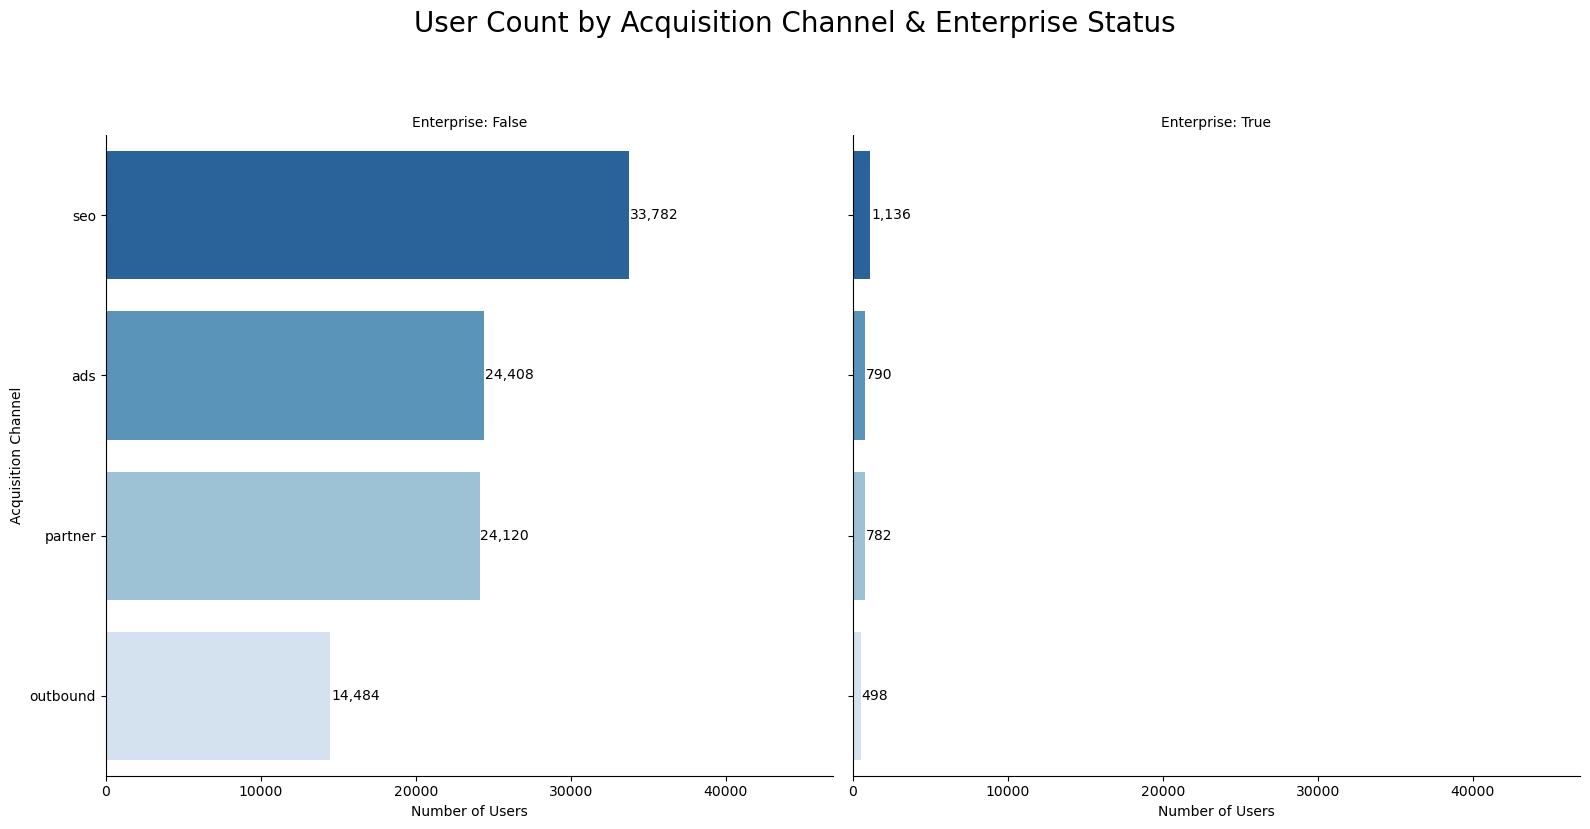

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load User Data ---
try:
    users_df = pd.read_csv('users.csv')
    print("File 'users.csv' loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- 2. Group and Count Users ---
print("Counting users by acquisition channel and enterprise status...")

# Group by both 'is_enterprise' and 'acquisition_channel', then count the users
plot_data = users_df.groupby(['is_enterprise', 'acquisition_channel'])['user_id'].nunique().reset_index(name='user_count')

# Sort the channels within each group by user count for a cleaner plot
plot_data = plot_data.sort_values(['is_enterprise', 'user_count'], ascending=[True, False])

# --- 3. Create the Faceted Visualization ---
print("Generating faceted visualization...")

# Use seaborn's catplot to create a grid of plots (facets)
g = sns.catplot(
    data=plot_data,
    x='user_count',
    y='acquisition_channel',
    col='is_enterprise',  # This creates a separate column of charts
    kind='bar',
    palette='Blues_r',
    height=8,
    aspect=1
)

# --- 4. Format the Plot for Clarity ---
g.fig.suptitle('User Count by Acquisition Channel & Enterprise Status', fontsize=20, y=1.03)
g.set_axis_labels('Number of Users', 'Acquisition Channel')
g.set_titles("Enterprise: {col_name}") # Customize the title for each subplot

# Add data labels to each bar
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_width() + 50, # Position for text
                p.get_y() + p.get_height() / 2.,
                f'{int(p.get_width()):,}', # The text to display
                ha='left',
                va='center')
    # Expand the x-axis to make space for the labels
    ax.set_xlim(0, ax.get_xlim()[1] * 1.15)


g.tight_layout(rect=[0, 0, 1, 0.97])

# Save the figure
plt.savefig('enterprise_vs_nonenterprise_acquisition.png')
print("\nFaceted chart saved as 'enterprise_vs_nonenterprise_acquisition.png'")